In [6]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools

warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [2]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.9,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))

In [3]:
for C_name in Copulae:
    Copulae[C_name].canonical_calibrate(u,v)
    print(C_name,'is done.\n')

Optimization terminated successfully.
         Current function value: -0.436606
         Iterations: 33
         Function evaluations: 67
Gaussian is done.

Sigma is not invertable


KeyboardInterrupt: 

In [4]:
for C_name in Copulae:
    print(C_name,Copulae[C_name].paras)

Gaussian {'rho': 0.7682137557864189}
t_Copula {'rho': 0.7758135540378888, 'nu': 2.0000000000019984}
t_Copula_Capped {'rho': 0.7990729223291435, 'nu': 4.000000000000071}
Clayton {'theta': 1.9376202894747336}
Frank {'theta': 7.1803941336274395}
Gumbel {'theta': 2.262103709019719}
Plackett {'theta': 21.73745587375015}
Gauss Mix Indep {'rho': 0.9257098982437446, 'p': 0.730537802300923}


In [5]:
for C_name in Copulae:
    ln = Copulae[C_name].dependency_likelihood(u,v)
    print(C_name,ln)

Gaussian 0.4445017729067782
t_Copula 0.5175515286733854
t_Copula_Capped 0.507278499083893
Clayton 0.3947361089938826
Frank 0.4132697635994375
Gumbel 0.45685655378875256
Plackett 0.48264136453947476
Gauss Mix Indep 0.5090127119623474


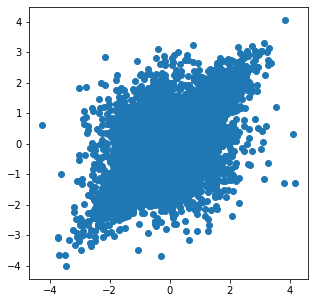

In [23]:
# s = C1.sample(100000)
s = Gaussian_Mix_Independent(C7.paras,
                             stats.norm,
                             stats.norm).sample(10000)
plt.figure(figsize=(5,5))
# plt.scatter(kde_brr.cdf(s[:,0]), kde_btc.cdf(s[:,1]))
plt.scatter(s[:,0], s[:,1])

In [94]:
ecdf = ECDF(rh)

In [24]:
def ERM_estimate_trapezoidal(k, rh):
    rh = np.sort(rh)
    s  = ECDF(rh)(rh)
    d  = s[1:] - s[:-1] 
    toint = ERM_weight(k,s)*rh
    return -np.sum((toint[:-1] + toint[1:])*d)/2

def ES(q, rh):
    b = np.quantile(rh,q)
    return -np.mean(rh[rh<=q])

def wrapper(rs, rf, h, risk_measure):
    rh = rs - h*rf
    return risk_measure(rh)

def optimize_h(C, k_arr, q_arr):
    sample = C.sample(1000000)
    rs = sample[:,0]
    rf = sample[:,1]
    best_h = []
    
    for k in k_arr:
        fn = lambda h: wrapper(rs,rf,h,partial(ERM_estimate_trapezoidal,k))
        best_h.append(scipy.optimize.fmin(fn,1)[0])
        
    for q in q_arr:
        fn = lambda h: wrapper(rs,rf,h,partial(ES,q))
        best_h.append(scipy.optimize.fmin(fn,1)[0])
    return best_h

In [25]:
optimize_h(Gaussian({"rho":0}, kde_brr, kde_btc), [10,20], [0.01,0.1])

Optimization terminated successfully.
         Current function value: 0.072510
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.094907
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.027470
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.002753
         Iterations: 18
         Function evaluations: 37


[-0.011718750000000899,
 -0.012207031250000899,
 -9.765625000088827e-05,
 -0.08242187500000095]

In [30]:
1-np.mean(data.return_brr)/np.mean(data.return_btc)

0.013559786556196496

In [31]:
optimize_h(Gaussian({"rho":0}, stats.norm, stats.norm), [10,20], [0.01,0.1])

Optimization terminated successfully.
         Current function value: 1.503248
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 1.851365
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.790765
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.734457
         Iterations: 18
         Function evaluations: 36


[0.0020507812499991136,
 0.0017578124999991134,
 0.01035156249999912,
 -0.011718750000000899]

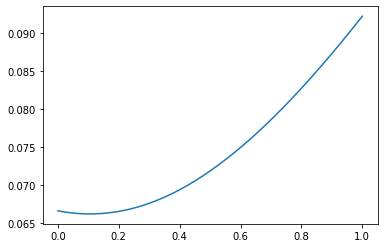

In [18]:
sample = C2.sample(100000)
rs = sample[:,0]
rf = sample[:,1]
best_h = []
    
fn = lambda h: wrapper(rs,rf,h,partial(ERM_estimate_trapezoidal,10))

h_arr = np.linspace(0,1,1000)
result = []
for h in h_arr:
    result.append(fn(h))
plt.plot(h_arr, result)

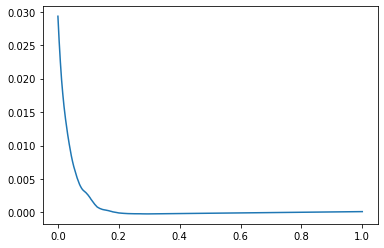

In [19]:
sample = C2.sample(100000)
rs = sample[:,0]
rf = sample[:,1]
best_h = []
    
fn = lambda q: wrapper(rs,rf,h,partial(ES,q))

h_arr = np.linspace(0,1,1000)
result = []
for h in h_arr:
    result.append(fn(h))
plt.plot(h_arr, result)

In [3]:
from riskmeasures import *

In [17]:
optimize_h(C1, [10,20], [0.01,0.05,0.1])

Optimization terminated successfully.
         Current function value: 0.030515
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.040137
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.007941
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000848
         Iterations: 13
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 15
         Function evaluations: 30


[0.8124999999999998,
 0.82119140625,
 0.7632812499999997,
 0.7816406249999996,
 0.6579101562499996]

In [141]:
def run(train):
    print(train.head())
    print(train.tail())
    rs_data = train.iloc[:,2]
    rf_data = train.iloc[:,3]

    kde_brr = KDE(rs_data, "Gaussian")
    kde_btc = KDE(rf_data, "Gaussian")

    kde_brr = KDE(rs_data, "Gaussian", kde_brr.h_brot*2) # get a smoother KDE
    kde_btc = KDE(rf_data, "Gaussian", kde_btc.h_brot*2) 

    u = ECDF(rs_data)(rs_data)
    v = ECDF(rf_data)(rf_data)
    
    # Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
    C1 =                 Gaussian(rho=0.9,       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
    C2 =                 t_Copula(rho=0.1, nu=4, Law_RS=kde_brr, Law_RF=kde_btc) 
    C2c =                t_Copula(rho=0.1, nu=4, Law_RS=kde_brr, Law_RF=kde_btc) 
    C3 =                  Clayton(theta=0.1,     Law_RS=kde_brr, Law_RF=kde_btc)
    C4 =                    Frank(theta=0.1,     Law_RS=kde_brr, Law_RF=kde_btc)
    C5 =                   Gumbel(theta=3,       Law_RS=kde_brr, Law_RF=kde_btc)
    C6 =                 Plackett(theta=10,      Law_RS=kde_brr, Law_RF=kde_btc)
    C7 = Gaussian_Mix_Independent(0.9,0.7,Law_RS=kde_brr, Law_RF=kde_btc)
    Copulae_names = ['Gaussian', 't_Copula','t_Copula Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
    Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
    Copulae = dict(zip(Copulae_names, Copulae_arr))
    
    # Calibrate
    C1.canonical_calibrate(u,v)
    C2.canonical_calibrate(u,v)
    C2c.canonical_calibrate(u,v,4)
    C3.canonical_calibrate(u,v)
    C4.canonical_calibrate(u,v)
    C5.canonical_calibrate(u,v)
    C6.canonical_calibrate(u,v)
    C7.canonical_calibrate(u,v)

    paras = [C1.rho, 
             (C2.rho, C2.nu),
             (C2c.rho, C2c.nu),
             C3.theta,
             C4.theta,
             C5.theta,
             C6.theta,
             (C7.rho, C7.p)]
    
    paras = dict(zip(Copulae_names, paras))
    
    # Likelihood
    ln = [C1.l_fn(C1.rho, u,v),
          C2.l_fn(C2.rho, C2.nu, u,v),
          C2c.l_fn(C2c.rho, C2c.nu, u,v),
          C3.l_fn(C3.theta, u,v),
          C4.l_fn(C4.theta, u,v),
          C5.l_fn(C5.theta, u,v), 
          C6.l_fn(C6.theta, u,v), 
          C7.l_fn(C7.rho, C7.p,u,v)]
    
    ln = dict(zip(Copulae_names, ln))
    
    # best h
    best_h = [optimize_h(C1, [10,20], [0.01,0.05,0.1]),
              optimize_h(C2, [10,20], [0.01,0.05,0.1]), 
              optimize_h(C2c,[10,20], [0.01,0.05,0.1]), 
              optimize_h(C3, [10,20], [0.01,0.05,0.1]),
              optimize_h(C4, [10,20], [0.01,0.05,0.1]),
              optimize_h(C5, [10,20], [0.01,0.05,0.1]),
              optimize_h(C6, [10,20], [0.01,0.05,0.1]), 
              optimize_h(C7, [10,20], [0.01,0.05,0.1])]
    
    best_h = dict(zip(Copulae_names, best_h))
    
    best_h = pd.DataFrame(result[2]).T
    best_h.columns = ['ERM k=10', 'ERM k=20', 'ES q=0.01', 'ES q=0.05', 'ES q=0.1']
    
    calibration_result = pd.DataFrame(result[:2]).T
    calibration_result.columns = ['Parameters', 'Likelihood']
    
    result_pd = pd.concat([best_h, calibration_result], axis=1).reset_index()
    result_pd.columns = ['Copula','ERM k=10', 'ERM k=20', 'ES q=0.01', 'ES q=0.05', 'ES q=0.1', 'Parameters', 'Likelihood']
    result_pd.Copula = result_pd.Copula.astype('category')
    result_pd.Copula.cat.set_categories(Copulae_names, inplace=True)
    result_pd = result_pd.sort_values(['Copula'])
    return result_pd
    
    
    

In [15]:
Copulae_names = ['Gaussian', 't_Copula','t_Copula Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']

paras = [C1.rho, (C2.rho, C2.nu), (C2c.rho, C2c.nu),
         C3.theta, C4.theta, C5.theta, C6.theta,
         (C7.rho, C7.p)]
paras = dict(zip(Copulae_names, paras))

In [21]:
result = run()

Optimization terminated successfully.
         Current function value: -0.436606
         Iterations: 33
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.515522
         Iterations: 198
         Function evaluations: 383
Optimization terminated successfully.
         Current function value: -0.502971
         Iterations: 175
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: -0.394737
         Iterations: 43
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.413272
         Iterations: 47
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.456857
         Iterations: 36
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.482641
         Iterations: 42
         Function evaluations: 92
Optimization terminate

In [69]:
best_h = pd.DataFrame(result[2]).T
best_h.columns = ['ERM k=10', 'ERM k=20', 'ES q=0.01', 'ES q=0.05', 'ES q=0.1']
best_h

,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.1
Gaussian,0.682520,0.710840,0.572656,0.654980,0.630078
t_Copula,0.733691,0.719922,0.704102,0.723437,0.635547
t_Copula Capped,0.732129,0.734473,0.700391,0.712402,0.574023
Clayton,0.544434,0.532129,0.567773,0.726465,0.858789
Frank,0.563086,0.580371,0.505273,0.497656,0.498437
Gumbel,0.774902,0.824707,0.666406,0.600391,0.506836
Plackett,0.632227,0.627344,0.655371,0.574902,0.515625
Gauss Mix Indep,0.634375,0.578418,0.701367,0.589062,0.483789


In [70]:
calibration_result = pd.DataFrame(result[:2]).T
calibration_result.columns = ['Parameters', 'Likelihood']
calibration_result

,Parameters,Likelihood
Clayton,1.93762,0.394736
Frank,7.18039,0.41327
Gauss Mix Indep,"(0.9257098982437446, 0.730537802300923)",0.509013
Gaussian,0.768214,0.444502
Gumbel,2.2621,0.456857
Plackett,21.7375,0.482641
t_Copula,"(0.7758135540378888, 2.0000000000019984)",0.517552
t_Copula Capped,"(0.7990729223291435, 4.000000000000071)",0.507278


In [94]:
result_pd = pd.concat([best_h, calibration_result], axis=1).reset_index()

In [95]:
result_pd.columns = ['Copula','ERM k=10', 'ERM k=20', 'ES q=0.01', 'ES q=0.05', 'ES q=0.1', 'Parameters', 'Likelihood']

In [98]:
result_pd.Copula = result_pd.Copula.astype('category')

In [99]:
result_pd.Copula.cat.set_categories(Copulae_names, inplace=True)

In [101]:
result_pd = result_pd.sort_values(['Copula'])

In [143]:
import os

ls = os.listdir('../processed_data/future_brr_v2/train/')
ls = [l for l in ls if l.endswith('.csv')]
output = []
for file in ls:
    print(file)
    train = pd.read_csv('../processed_data/future_brr_v2/train/'+file)
#     output.append(run(train)) 
    print(train.head())

6.csv
   Unnamed: 0        Date  log return future  log return brr
0         132  2020-02-28          -0.027772       -0.023502
1         133  2020-02-27           0.006730       -0.015298
2         134  2020-02-26          -0.060062       -0.042868
3         135  2020-02-25          -0.032328       -0.034790
4         136  2020-02-24          -0.014264        0.001585
7.csv
   Unnamed: 0        Date  log return future  log return brr
0         151  2020-01-31          -0.028943       -0.008120
1         152  2020-01-30           0.020068        0.006808
2         153  2020-01-29           0.036522        0.031271
3         154  2020-01-28           0.010840        0.027705
4         155  2020-01-27           0.062978        0.033621
5.csv
   Unnamed: 0        Date  log return future  log return brr
0         110  2020-03-31           0.016210        0.021556
1         111  2020-03-30          -0.034119       -0.049132
2         112  2020-03-27          -0.004053        0.005868
3     

In [133]:
print(ls[0]) 
output[0]

6.csv


,Copula,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.1,Parameters,Likelihood
3,Gaussian,0.682520,0.710840,0.572656,0.654980,0.630078,0.768214,0.444502
6,t_Copula,0.733691,0.719922,0.704102,0.723437,0.635547,"(0.7758135540378888, 2.0000000000019984)",0.517552
7,t_Copula Capped,0.732129,0.734473,0.700391,0.712402,0.574023,"(0.7990729223291435, 4.000000000000071)",0.507278
0,Clayton,0.544434,0.532129,0.567773,0.726465,0.858789,1.93762,0.394736
1,Frank,0.563086,0.580371,0.505273,0.497656,0.498437,7.18039,0.41327
4,Gumbel,0.774902,0.824707,0.666406,0.600391,0.506836,2.2621,0.456857
5,Plackett,0.632227,0.627344,0.655371,0.574902,0.515625,21.7375,0.482641
2,Gauss Mix Indep,0.634375,0.578418,0.701367,0.589062,0.483789,"(0.9257098982437446, 0.730537802300923)",0.509013


In [135]:
print(ls[1])
output[1]

7.csv


,Copula,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.1,Parameters,Likelihood
3,Gaussian,0.682520,0.710840,0.572656,0.654980,0.630078,0.768214,0.444502
6,t_Copula,0.733691,0.719922,0.704102,0.723437,0.635547,"(0.7758135540378888, 2.0000000000019984)",0.517552
7,t_Copula Capped,0.732129,0.734473,0.700391,0.712402,0.574023,"(0.7990729223291435, 4.000000000000071)",0.507278
0,Clayton,0.544434,0.532129,0.567773,0.726465,0.858789,1.93762,0.394736
1,Frank,0.563086,0.580371,0.505273,0.497656,0.498437,7.18039,0.41327
4,Gumbel,0.774902,0.824707,0.666406,0.600391,0.506836,2.2621,0.456857
5,Plackett,0.632227,0.627344,0.655371,0.574902,0.515625,21.7375,0.482641
2,Gauss Mix Indep,0.634375,0.578418,0.701367,0.589062,0.483789,"(0.9257098982437446, 0.730537802300923)",0.509013


In [136]:
print(ls[2])
output[2]

5.csv


,Copula,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.1,Parameters,Likelihood
3,Gaussian,0.682520,0.710840,0.572656,0.654980,0.630078,0.768214,0.444502
6,t_Copula,0.733691,0.719922,0.704102,0.723437,0.635547,"(0.7758135540378888, 2.0000000000019984)",0.517552
7,t_Copula Capped,0.732129,0.734473,0.700391,0.712402,0.574023,"(0.7990729223291435, 4.000000000000071)",0.507278
0,Clayton,0.544434,0.532129,0.567773,0.726465,0.858789,1.93762,0.394736
1,Frank,0.563086,0.580371,0.505273,0.497656,0.498437,7.18039,0.41327
4,Gumbel,0.774902,0.824707,0.666406,0.600391,0.506836,2.2621,0.456857
5,Plackett,0.632227,0.627344,0.655371,0.574902,0.515625,21.7375,0.482641
2,Gauss Mix Indep,0.634375,0.578418,0.701367,0.589062,0.483789,"(0.9257098982437446, 0.730537802300923)",0.509013


In [137]:
print(ls[3])
output[3]

4.csv


,Copula,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.1,Parameters,Likelihood
3,Gaussian,0.682520,0.710840,0.572656,0.654980,0.630078,0.768214,0.444502
6,t_Copula,0.733691,0.719922,0.704102,0.723437,0.635547,"(0.7758135540378888, 2.0000000000019984)",0.517552
7,t_Copula Capped,0.732129,0.734473,0.700391,0.712402,0.574023,"(0.7990729223291435, 4.000000000000071)",0.507278
0,Clayton,0.544434,0.532129,0.567773,0.726465,0.858789,1.93762,0.394736
1,Frank,0.563086,0.580371,0.505273,0.497656,0.498437,7.18039,0.41327
4,Gumbel,0.774902,0.824707,0.666406,0.600391,0.506836,2.2621,0.456857
5,Plackett,0.632227,0.627344,0.655371,0.574902,0.515625,21.7375,0.482641
2,Gauss Mix Indep,0.634375,0.578418,0.701367,0.589062,0.483789,"(0.9257098982437446, 0.730537802300923)",0.509013


In [144]:
C8 = Gaussian_Mix_Independent(0.8,0.9, kde_brr, kde_btc)
s = C8.sample(1000)
plt.figure(figsize=(5,5))
plt.scatter(kde_brr.cdf(s[:,0]),kde_btc.cdf(s[:,1]))

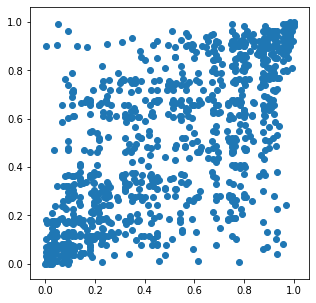

In [142]:
C8 = Gaussian({"rho":0}, stats.norm, stats.norm(loc=-.01, scale=0.03))
s = C8.sample(100000)
h_arr = np.linspace(-10,10,200)
rh = s[:,0] - h_arr [0]*s[:,1]
ERM_estimate_trapezoidal(10,rh)

1.6677988465879932

7.48743718592965


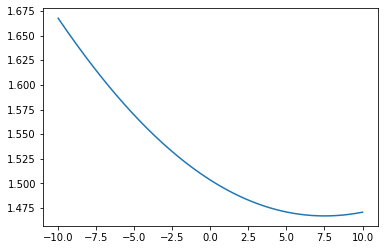

In [143]:
result = []
mode = []
for h in h_arr:
    rh = s[:,0] - h*s[:,1]
    mode.append(stats.mode(rh)[0][0])
    result.append(ERM_estimate_trapezoidal(10,rh))
plt.plot(h_arr,result)
print(h_arr[np.argmin(result)])

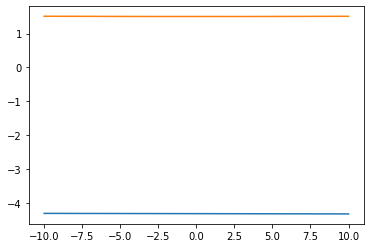

In [129]:
plt.plot(h_arr, mode)
plt.plot(h_arr,result)

In [144]:
import os

ls = os.listdir('../processed_data/future_brr_v2/train/')
ls = [l for l in ls if l.endswith('.csv')]
output = []
for file in ls:
    print(file)
    train = pd.read_csv('../processed_data/future_brr_v2/train/'+file)

6.csv
7.csv
5.csv
4.csv
0.csv
1.csv
3.csv
2.csv
18.csv
16.csv
17.csv
15.csv
14.csv
10.csv
11.csv
13.csv
12.csv
9.csv
8.csv


In [157]:
ls = [l for l in ls if l.endswith('.csv')]
output = []
C = Gaussian({"rho":0.7}, kde_brr, kde_btc)
for file in ls:
    train = pd.read_csv('../processed_data/future_brr_v2/train/'+file)
    kde_brr = KDE(train.iloc[:,2], "Gaussian")
    kde_btc = KDE(train.iloc[:,3], "Gaussian")
    u = kde_brr.cdf(train.iloc[:,2])
    v = kde_btc.cdf(train.iloc[:,3])
    C = Gaussian_Mix_Independent({"rho":0.7, "p":0.7}, kde_brr, kde_btc)
    C.canonical_calibrate(u,v)
    output.append(C.paras)

Optimization terminated successfully.
         Current function value: -0.450585
         Iterations: 74
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.456745
         Iterations: 78
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.471562
         Iterations: 72
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.479309
         Iterations: 73
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.453683
         Iterations: 73
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.436534
         Iterations: 77
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.467938
         Iterations: 68
         Function evaluations: 145
Optimization termina

In [175]:
likelihood = []
for j, file in enumerate(ls):
    train = pd.read_csv('../processed_data/future_brr_v2/train/'+file)
    kde_brr = KDE(train.iloc[:,2], "Gaussian")
    kde_btc = KDE(train.iloc[:,3], "Gaussian")
    u = kde_brr.cdf(train.iloc[:,2])
    v = kde_btc.cdf(train.iloc[:,3])
    likelihood.append(Gaussian_Mix_Independent(output[j], kde_brr, kde_btc).l_fn(output[j]['rho'], output[j]['p'], u,v))

In [203]:
result = pd.DataFrame(output)
result.loc[:,'likelihood'] = likelihood
result.loc[:,'file'] = np.array([int(l[:-4]) for l in ls])
result = result.sort_values('file')

In [221]:
C2.paras.keys()

dict_keys(['rho', 'nu'])

In [11]:
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C1.canonical_calibrate(u,v)

Optimization terminated successfully.
         Current function value: -0.444507
         Iterations: 33
         Function evaluations: 70
CPU times: user 856 ms, sys: 7.4 ms, total: 863 ms
Wall time: 863 ms


array([0.76715476])

In [566]:
data = [np.random.choice(id_arr, size=n) for _ in range(10)]
data = [(u[ids-1], v[ids-1]) for ids in data]

In [568]:
pool.close()

In [590]:
%%time
p=0.8
C1 = Gaussian({"rho":0.7}, stats.norm, stats.norm)
fn = lambda u,v: 1/(p*C1.c(u,v)+1-p)*(C1.c(u,v)-1)
# scipy.integrate.nquad(fn, ((0,1),(0,1)))

CPU times: user 646 µs, sys: 1.25 ms, total: 1.89 ms
Wall time: 1.91 ms


In [591]:
%time fn(0.0,0.0)

CPU times: user 1.69 ms, sys: 1.41 ms, total: 3.1 ms
Wall time: 2.54 ms


-5.000000000000001

In [682]:
p=0.8
def fn(u,v):
    _c = C1.c(u,v)
    return (1/(p*_c+1-p)*(_c-1))**2*_c
# fn(0.6,0.6)
# scipy.integrate.nquad(fn, ((0.9,1),(0.9,1)))

In [684]:
%%time
d = 200
a = np.linspace(0,1,d)
b = np.linspace(0,1,d)
area = (1/d)**2
_in = np.array(list(itertools.product(a, b)))
np.sum([fn(_in[i,0], _in[i,1]) for i in range(len(_in))])*area

CPU times: user 31.1 s, sys: 27 s, total: 58.1 s
Wall time: 53.7 s


0.40664119245755664

In [732]:
def c(u,v,rho):
    X1 = norm.ppf(u)
    X2 = norm.ppf(v)
    return 1/np.sqrt(1-rho**2)*np.exp((rho**2*(X1**2+X2**2)-2*rho*X1*X2)/(2*1-rho**2))

In [842]:
d = 2000
a = np.linspace(0.001,.99,d)
b = np.linspace(0.001,.99,d)
area = (1/d)**2
_in = np.array(list(itertools.product(a, b)))

rho=0.7
X1 = norm.ppf(_in[:,0])
X2 = norm.ppf(_in[:,1])
_c = 1/np.sqrt(1-rho**2)*np.exp(-(rho**2*(X1**2+X2**2)-2*rho*X1*X2)/(2-2*rho**2))
np.sum((1/(p*_c+1-p)*(_c-1))**2*_c)*area

0.40876413597430505

In [846]:
rho=0.7
_u = _in[:,0]
_v = _in[:,1]
dln = (-_u**2*rho+_u*_v*(1+rho**2)-rho*(-1+_v**2+rho**2))/((-1+rho**2)**2)

In [864]:
np.sum((dln**2)/_c*area)
# IMPORTANT! https://www.tandfonline.com/doi/pdf/10.1080/03610920701215159?needAccess=true

518.6597883033214

In [858]:
1/np.sqrt(np.sum(dln**2*_c)*area)/np.sqrt(100)

0.07376453275451095

In [853]:
np.var(dln*_c)

1.6868019658886082

In [844]:
ddln = (-1+rho**4-2*_u*_v*rho*(3+rho**2)+_u**2*(1+3*rho**2)+_v**2*(1+3*rho**2))/(-1+rho**2)**3

In [845]:
np.sum(ddln*_c)*area

4.622125082577885

In [832]:
rho=0.7
((1+rho**2)/((1-rho**2)**2))

5.728565936178393

In [688]:
I = 0.40664119245755664

1/np.sqrt(I)/np.sqrt(len(u))

0.15681742376286928

In [683]:
d = 200
a = np.linspace(0,0.5,d/2)
b = np.linspace(0,1,d)
area = (1/d)**2
_in = np.array(list(itertools.product(a, b)))
h = [fn(_in[i,0], _in[i,1]) for i in range(len(_in))]
np.sum(h)*area*2
# len(_in)

0.40540561592398316

In [674]:
1/np.sqrt(.405)/np.sqrt(100)

0.15713484026367724

In [551]:
id_arr = np.linspace(1,len(u), len(u)).astype(int)
n = 100
theta_arr = []
from tqdm import tqdm
for _ in tqdm(range(2000)):
    ids = np.random.choice(id_arr, size=n)
    theta_arr.append(C7.canonical_calibrate(u[ids-1],v[ids-1]))






  0%|          | 0/2000 [00:00<?, ?it/s]




  0%|          | 1/2000 [00:05<2:49:24,  5.08s/it]

Optimization terminated successfully.
         Current function value: -0.374028
         Iterations: 66
         Function evaluations: 138







  0%|          | 2/2000 [00:08<2:36:15,  4.69s/it]

Optimization terminated successfully.
         Current function value: -0.470915
         Iterations: 95
         Function evaluations: 189







  0%|          | 3/2000 [00:14<2:45:27,  4.97s/it]

Optimization terminated successfully.
         Current function value: -0.543108
         Iterations: 72
         Function evaluations: 147







  0%|          | 4/2000 [00:19<2:46:28,  5.00s/it]

Optimization terminated successfully.
         Current function value: -0.399141
         Iterations: 64
         Function evaluations: 133







  0%|          | 5/2000 [00:24<2:49:19,  5.09s/it]

Optimization terminated successfully.
         Current function value: -0.451048
         Iterations: 70
         Function evaluations: 141


KeyboardInterrupt: 

0.8931345595621235

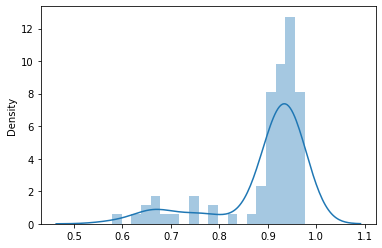

In [546]:
sns.distplot(np.array(theta_arr)[:,0])
np.mean(np.array(theta_arr)[:,0])

In [554]:
%time C7.canonical_calibrate(u[ids-1],v[ids-1])

Optimization terminated successfully.
         Current function value: -0.266907
         Iterations: 111
         Function evaluations: 219
CPU times: user 4.21 s, sys: 20.8 ms, total: 4.23 s
Wall time: 4.24 s


array([0.68648498, 1.        ])

0.7307411333242398

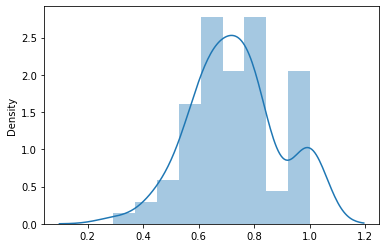

In [545]:
sns.distplot(np.array(theta_arr)[:,1])
np.mean(np.array(theta_arr)[:,1])

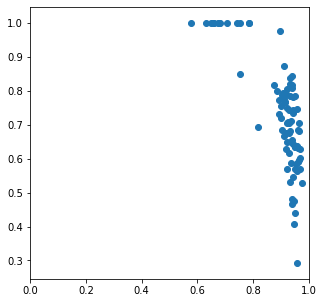

In [550]:
plt.figure(figsize=(5,5))
plt.xlim((0,1))
plt.scatter(np.array(theta_arr)[:,0], np.array(theta_arr)[:,1])

0.5582530011502297 0.9999999999999898


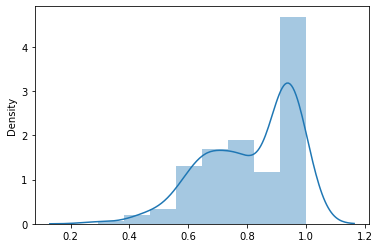

In [539]:
sns.distplot(theta_arr)
print(np.quantile(theta_arr,q=0.05), np.quantile(theta_arr,q=0.95))

In [29]:
np.mean(theta_arr)

0.7672198866332891

In [16]:
id_arr = np.linspace(0,len(u)-1, len(u)).astype(int)
n = 100
theta_arr1 = []
brr = np.array(data.return_brr)
btc = np.array(data.return_btc)
C1  = Gaussian(dict(rho=0.9), Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!

from tqdm import tqdm
for _ in tqdm(range(2000)):
    ids = np.random.choice(id_arr, size=n)
    u = ECDF(brr[ids])(brr[ids])
    v = ECDF(btc[ids])(btc[ids])
    C1  = Gaussian(dict(rho=0.9), Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
    theta_arr1.append(C1.canonical_calibrate(u,v)[0])


  0%|          | 2/2000 [00:00<07:23,  4.50it/s]

Optimization terminated successfully.
         Current function value: -0.358688
         Iterations: 35
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.402586
         Iterations: 33
         Function evaluations: 68



  0%|          | 4/2000 [00:00<07:04,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.315667
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.450796
         Iterations: 32
         Function evaluations: 68



  0%|          | 5/2000 [00:01<06:58,  4.76it/s]


Optimization terminated successfully.
         Current function value: -0.480943
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.177326
         Iterations: 35
         Function evaluations: 74


  0%|          | 8/2000 [00:01<06:39,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.442156
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.429492
         Iterations: 33
         Function evaluations: 69



  0%|          | 10/2000 [00:01<06:17,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.473109
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.606489
         Iterations: 31
         Function evaluations: 66



  1%|          | 12/2000 [00:02<06:27,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.343043
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.396084
         Iterations: 34
         Function evaluations: 72



  1%|          | 14/2000 [00:02<06:22,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.475256
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.430818
         Iterations: 32
         Function evaluations: 69



  1%|          | 15/2000 [00:02<06:24,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.450054
         Iterations: 32
         Function evaluations: 66



  1%|          | 17/2000 [00:03<06:30,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.667600
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.450802
         Iterations: 32
         Function evaluations: 70



  1%|          | 18/2000 [00:03<06:44,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.601935
         Iterations: 32
         Function evaluations: 66



  1%|          | 19/2000 [00:03<07:02,  4.69it/s]

Optimization terminated successfully.
         Current function value: -0.355044
         Iterations: 33
         Function evaluations: 70



  1%|          | 20/2000 [00:04<07:16,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.693655
         Iterations: 32
         Function evaluations: 68



  1%|          | 22/2000 [00:04<07:09,  4.60it/s]

Optimization terminated successfully.
         Current function value: -0.370407
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.471308
         Iterations: 33
         Function evaluations: 69



  1%|          | 23/2000 [00:04<07:14,  4.55it/s]

Optimization terminated successfully.
         Current function value: -0.365631
         Iterations: 34
         Function evaluations: 73



  1%|          | 24/2000 [00:04<07:06,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.409582
         Iterations: 33
         Function evaluations: 71



  1%|▏         | 25/2000 [00:05<07:14,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.388386
         Iterations: 34
         Function evaluations: 73



  1%|▏         | 27/2000 [00:05<06:51,  4.79it/s]

Optimization terminated successfully.
         Current function value: -0.557465
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.287718
         Iterations: 34
         Function evaluations: 72



  1%|▏         | 29/2000 [00:05<06:37,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.464222
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.384141
         Iterations: 33
         Function evaluations: 70



  2%|▏         | 30/2000 [00:06<06:39,  4.93it/s]

Optimization terminated successfully.
         Current function value: -0.553343
         Iterations: 33
         Function evaluations: 71



  2%|▏         | 32/2000 [00:06<06:27,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.240732
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.617409
         Iterations: 31
         Function evaluations: 64



  2%|▏         | 33/2000 [00:06<06:32,  5.01it/s]


Optimization terminated successfully.
         Current function value: -0.305970
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.623232
         Iterations: 31
         Function evaluations: 66


  2%|▏         | 35/2000 [00:07<06:31,  5.02it/s]


Optimization terminated successfully.
         Current function value: -0.433223
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.443361
         Iterations: 32
         Function evaluations: 68


  2%|▏         | 38/2000 [00:07<06:26,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.420618
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.399419
         Iterations: 32
         Function evaluations: 68



  2%|▏         | 40/2000 [00:08<06:25,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.409226
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.426398
         Iterations: 32
         Function evaluations: 67



  2%|▏         | 41/2000 [00:08<06:25,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.443161
         Iterations: 32
         Function evaluations: 68



  2%|▏         | 42/2000 [00:08<06:41,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.273186
         Iterations: 34
         Function evaluations: 72



  2%|▏         | 43/2000 [00:08<06:46,  4.81it/s]

Optimization terminated successfully.
         Current function value: -0.287355
         Iterations: 34
         Function evaluations: 72



  2%|▏         | 46/2000 [00:09<06:23,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.540884
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.413117
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.505128
         Iterations: 33
         Function evaluations: 70



  2%|▏         | 48/2000 [00:09<06:29,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.482055
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.320464
         Iterations: 33
         Function evaluations: 70



  2%|▏         | 49/2000 [00:09<06:29,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.449860
         Iterations: 32
         Function evaluations: 68



  2%|▎         | 50/2000 [00:10<06:30,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.316663
         Iterations: 33
         Function evaluations: 72



  3%|▎         | 51/2000 [00:10<06:42,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.501812
         Iterations: 32
         Function evaluations: 68



  3%|▎         | 52/2000 [00:10<06:51,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.472653
         Iterations: 33
         Function evaluations: 70



  3%|▎         | 53/2000 [00:10<06:55,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.297213
         Iterations: 33
         Function evaluations: 71



  3%|▎         | 55/2000 [00:11<06:45,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.293396
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.497844
         Iterations: 32
         Function evaluations: 69



  3%|▎         | 57/2000 [00:11<06:33,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.265665
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.401749
         Iterations: 33
         Function evaluations: 71



  3%|▎         | 58/2000 [00:11<06:43,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.437103
         Iterations: 32
         Function evaluations: 68



  3%|▎         | 59/2000 [00:12<06:47,  4.77it/s]

Optimization terminated successfully.
         Current function value: -0.502778
         Iterations: 32
         Function evaluations: 69



  3%|▎         | 60/2000 [00:12<06:54,  4.68it/s]


Optimization terminated successfully.
         Current function value: -0.267926
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.328019
         Iterations: 33
         Function evaluations: 70


  3%|▎         | 63/2000 [00:12<06:23,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.426462
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.401880
         Iterations: 33
         Function evaluations: 68



  3%|▎         | 65/2000 [00:13<06:18,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.372249
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.429976
         Iterations: 33
         Function evaluations: 69



  3%|▎         | 67/2000 [00:13<06:09,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.448071
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.250994
         Iterations: 33
         Function evaluations: 70



  3%|▎         | 69/2000 [00:14<06:28,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.449193
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.354797
         Iterations: 33
         Function evaluations: 71



  4%|▎         | 71/2000 [00:14<06:26,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.313072
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.248382
         Iterations: 34
         Function evaluations: 72



  4%|▎         | 72/2000 [00:14<06:36,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.516352
         Iterations: 32
         Function evaluations: 68



  4%|▎         | 73/2000 [00:14<06:35,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.335615
         Iterations: 33
         Function evaluations: 71



  4%|▎         | 74/2000 [00:15<06:33,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.327923
         Iterations: 34
         Function evaluations: 72



  4%|▍         | 76/2000 [00:15<06:26,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.375975
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.363074
         Iterations: 33
         Function evaluations: 70



  4%|▍         | 77/2000 [00:15<06:25,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.489586
         Iterations: 32
         Function evaluations: 67



  4%|▍         | 78/2000 [00:15<06:46,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.408400
         Iterations: 34
         Function evaluations: 73



  4%|▍         | 79/2000 [00:16<06:52,  4.65it/s]

Optimization terminated successfully.
         Current function value: -0.591376
         Iterations: 32
         Function evaluations: 69



  4%|▍         | 80/2000 [00:16<06:58,  4.58it/s]

Optimization terminated successfully.
         Current function value: -0.327754
         Iterations: 33
         Function evaluations: 71



  4%|▍         | 81/2000 [00:16<06:52,  4.65it/s]


Optimization terminated successfully.
         Current function value: -0.399387
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.413877
         Iterations: 34
         Function evaluations: 70


  4%|▍         | 84/2000 [00:17<06:27,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.349435
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.399086
         Iterations: 34
         Function evaluations: 71



  4%|▍         | 85/2000 [00:17<06:32,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.487765
         Iterations: 32
         Function evaluations: 67



  4%|▍         | 87/2000 [00:17<06:24,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.470245
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.430359
         Iterations: 32
         Function evaluations: 67



  4%|▍         | 89/2000 [00:18<06:11,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.497906
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.434327
         Iterations: 33
         Function evaluations: 69



  5%|▍         | 91/2000 [00:18<06:07,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.357852
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.397126
         Iterations: 34
         Function evaluations: 72



  5%|▍         | 93/2000 [00:18<06:07,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.471091
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.401606
         Iterations: 35
         Function evaluations: 73



  5%|▍         | 95/2000 [00:19<06:05,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.419564
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.285087
         Iterations: 33
         Function evaluations: 70



  5%|▍         | 97/2000 [00:19<05:54,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.398093
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.663317
         Iterations: 31
         Function evaluations: 65



  5%|▍         | 99/2000 [00:20<05:54,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.348523
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.520832
         Iterations: 32
         Function evaluations: 66



  5%|▌         | 101/2000 [00:20<05:52,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.459783
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.324567
         Iterations: 33
         Function evaluations: 70



  5%|▌         | 103/2000 [00:20<05:52,  5.38it/s]

Optimization terminated successfully.
         Current function value: -0.503698
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.460018
         Iterations: 32
         Function evaluations: 69



  5%|▌         | 105/2000 [00:21<05:51,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.348055
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.490382
         Iterations: 32
         Function evaluations: 67



  5%|▌         | 107/2000 [00:21<05:49,  5.41it/s]

Optimization terminated successfully.
         Current function value: -0.619297
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.432194
         Iterations: 32
         Function evaluations: 68



  5%|▌         | 109/2000 [00:21<06:01,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.416970
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.325838
         Iterations: 33
         Function evaluations: 70



  6%|▌         | 111/2000 [00:22<05:53,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.296691
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.543180
         Iterations: 32
         Function evaluations: 67



  6%|▌         | 113/2000 [00:22<05:53,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.313229
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.415858
         Iterations: 34
         Function evaluations: 72



  6%|▌         | 115/2000 [00:23<06:04,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.333124
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.374711
         Iterations: 33
         Function evaluations: 70



  6%|▌         | 117/2000 [00:23<05:58,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.652033
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.504592
         Iterations: 32
         Function evaluations: 69



  6%|▌         | 118/2000 [00:23<05:58,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.376589
         Iterations: 33
         Function evaluations: 69



  6%|▌         | 120/2000 [00:24<05:58,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.362190
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.427851
         Iterations: 32
         Function evaluations: 67



  6%|▌         | 122/2000 [00:24<05:53,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.424913
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.559825
         Iterations: 31
         Function evaluations: 67



  6%|▌         | 124/2000 [00:24<05:56,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.535320
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.512022
         Iterations: 33
         Function evaluations: 69



  6%|▋         | 126/2000 [00:25<06:14,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.343420
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.375827
         Iterations: 33
         Function evaluations: 70



  6%|▋         | 127/2000 [00:25<06:12,  5.03it/s]


Optimization terminated successfully.
         Current function value: -0.557803
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.365849
         Iterations: 34
         Function evaluations: 73


  6%|▋         | 129/2000 [00:25<06:22,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.363376
         Iterations: 33
         Function evaluations: 70



  6%|▋         | 130/2000 [00:26<06:54,  4.52it/s]

Optimization terminated successfully.
         Current function value: -0.378310
         Iterations: 34
         Function evaluations: 73



  7%|▋         | 131/2000 [00:26<07:12,  4.32it/s]

Optimization terminated successfully.
         Current function value: -0.348038
         Iterations: 35
         Function evaluations: 73



  7%|▋         | 133/2000 [00:26<06:40,  4.67it/s]

Optimization terminated successfully.
         Current function value: -0.424931
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.792826
         Iterations: 32
         Function evaluations: 66



  7%|▋         | 134/2000 [00:26<06:26,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.331721
         Iterations: 33
         Function evaluations: 69



  7%|▋         | 136/2000 [00:27<06:23,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.451491
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.399167
         Iterations: 33
         Function evaluations: 70



  7%|▋         | 137/2000 [00:27<06:23,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.566883
         Iterations: 32
         Function evaluations: 70



  7%|▋         | 138/2000 [00:27<06:27,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.416026
         Iterations: 33
         Function evaluations: 70



  7%|▋         | 140/2000 [00:28<06:21,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.329416
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.490868
         Iterations: 32
         Function evaluations: 67



  7%|▋         | 141/2000 [00:28<06:30,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.396222
         Iterations: 33
         Function evaluations: 71



  7%|▋         | 143/2000 [00:28<06:41,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.398852
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.442156
         Iterations: 33
         Function evaluations: 70



  7%|▋         | 145/2000 [00:29<06:23,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.467603
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.504695
         Iterations: 32
         Function evaluations: 68



  7%|▋         | 147/2000 [00:29<06:22,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.425504
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.412134
         Iterations: 33
         Function evaluations: 70



  7%|▋         | 149/2000 [00:30<06:16,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.379496
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.556496
         Iterations: 31
         Function evaluations: 66



  8%|▊         | 150/2000 [00:30<06:22,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.301387
         Iterations: 34
         Function evaluations: 72



  8%|▊         | 152/2000 [00:30<06:14,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.409692
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.336554
         Iterations: 33
         Function evaluations: 69



  8%|▊         | 153/2000 [00:30<06:07,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.517475
         Iterations: 32
         Function evaluations: 66



  8%|▊         | 154/2000 [00:31<06:13,  4.94it/s]


Optimization terminated successfully.
         Current function value: -0.276393
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.583423
         Iterations: 32
         Function evaluations: 69


  8%|▊         | 157/2000 [00:31<06:06,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.324041
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.336993
         Iterations: 33
         Function evaluations: 70



  8%|▊         | 158/2000 [00:31<06:05,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.401258
         Iterations: 32
         Function evaluations: 68



  8%|▊         | 160/2000 [00:32<06:07,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.276336
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.425213
         Iterations: 33
         Function evaluations: 71



  8%|▊         | 162/2000 [00:32<06:06,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.418448
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.410249
         Iterations: 33
         Function evaluations: 71



  8%|▊         | 164/2000 [00:33<06:05,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.340022
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.529771
         Iterations: 32
         Function evaluations: 68



  8%|▊         | 166/2000 [00:33<05:58,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.354626
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.455967
         Iterations: 32
         Function evaluations: 68



  8%|▊         | 168/2000 [00:33<05:54,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.429337
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.439548
         Iterations: 33
         Function evaluations: 71



  8%|▊         | 170/2000 [00:34<05:57,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.584954
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.356348
         Iterations: 34
         Function evaluations: 72



  9%|▊         | 172/2000 [00:34<05:45,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.374922
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.736643
         Iterations: 30
         Function evaluations: 63



  9%|▊         | 173/2000 [00:34<05:49,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.401206
         Iterations: 33
         Function evaluations: 70



  9%|▊         | 174/2000 [00:35<06:19,  4.81it/s]

Optimization terminated successfully.
         Current function value: -0.336807
         Iterations: 34
         Function evaluations: 71



  9%|▉         | 175/2000 [00:35<06:45,  4.50it/s]

Optimization terminated successfully.
         Current function value: -0.315368
         Iterations: 33
         Function evaluations: 71



  9%|▉         | 177/2000 [00:35<06:25,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.392553
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.382520
         Iterations: 34
         Function evaluations: 70



  9%|▉         | 178/2000 [00:35<06:33,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.450767
         Iterations: 33
         Function evaluations: 70



  9%|▉         | 179/2000 [00:36<06:37,  4.58it/s]

Optimization terminated successfully.
         Current function value: -0.411805
         Iterations: 32
         Function evaluations: 69



  9%|▉         | 181/2000 [00:36<06:21,  4.77it/s]

Optimization terminated successfully.
         Current function value: -0.525160
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.535771
         Iterations: 32
         Function evaluations: 68



  9%|▉         | 182/2000 [00:36<06:37,  4.58it/s]

Optimization terminated successfully.
         Current function value: -0.266696
         Iterations: 34
         Function evaluations: 72



  9%|▉         | 184/2000 [00:37<06:26,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.435234
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.521727
         Iterations: 32
         Function evaluations: 69



  9%|▉         | 185/2000 [00:37<06:28,  4.68it/s]


Optimization terminated successfully.
         Current function value: -0.455784
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.358729
         Iterations: 34
         Function evaluations: 73


  9%|▉         | 188/2000 [00:38<06:08,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.523774
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.480824
         Iterations: 32
         Function evaluations: 68



 10%|▉         | 190/2000 [00:38<05:53,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.334569
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.660186
         Iterations: 32
         Function evaluations: 67



 10%|▉         | 191/2000 [00:38<06:21,  4.74it/s]


Optimization terminated successfully.
         Current function value: -0.291199
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.498613
         Iterations: 34
         Function evaluations: 72


 10%|▉         | 194/2000 [00:39<05:57,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.315045
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.442540
         Iterations: 32
         Function evaluations: 67



 10%|▉         | 195/2000 [00:39<05:50,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.594318
         Iterations: 32
         Function evaluations: 67



 10%|▉         | 196/2000 [00:39<06:10,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.436157
         Iterations: 32
         Function evaluations: 67



 10%|▉         | 197/2000 [00:39<06:23,  4.70it/s]


Optimization terminated successfully.
         Current function value: -0.253810
         Iterations: 36
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.335110
         Iterations: 34
         Function evaluations: 71


 10%|▉         | 199/2000 [00:40<06:06,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.550873
         Iterations: 32
         Function evaluations: 66



 10%|█         | 200/2000 [00:40<06:20,  4.72it/s]

Optimization terminated successfully.
         Current function value: -0.305590
         Iterations: 33
         Function evaluations: 69



 10%|█         | 201/2000 [00:40<06:23,  4.69it/s]

Optimization terminated successfully.
         Current function value: -0.439498
         Iterations: 32
         Function evaluations: 67



 10%|█         | 202/2000 [00:40<06:25,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.517520
         Iterations: 32
         Function evaluations: 67



 10%|█         | 203/2000 [00:41<06:23,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.390891
         Iterations: 33
         Function evaluations: 68



 10%|█         | 205/2000 [00:41<06:07,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.384738
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.414929
         Iterations: 32
         Function evaluations: 67



 10%|█         | 207/2000 [00:41<05:56,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.230433
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.469396
         Iterations: 32
         Function evaluations: 67



 10%|█         | 209/2000 [00:42<05:49,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.347195
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.294975
         Iterations: 33
         Function evaluations: 70



 11%|█         | 211/2000 [00:42<05:49,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.486446
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.431043
         Iterations: 33
         Function evaluations: 71



 11%|█         | 213/2000 [00:43<05:41,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.418380
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.359168
         Iterations: 33
         Function evaluations: 69



 11%|█         | 215/2000 [00:43<05:46,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.376571
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.378062
         Iterations: 34
         Function evaluations: 72



 11%|█         | 217/2000 [00:43<05:46,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.298735
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.285773
         Iterations: 33
         Function evaluations: 70



 11%|█         | 219/2000 [00:44<05:36,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.584500
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.472638
         Iterations: 32
         Function evaluations: 68



 11%|█         | 221/2000 [00:44<05:44,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.473035
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.341842
         Iterations: 34
         Function evaluations: 72



 11%|█         | 223/2000 [00:45<05:43,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.637022
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.385232
         Iterations: 33
         Function evaluations: 70



 11%|█▏        | 225/2000 [00:45<05:35,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.370028
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.442241
         Iterations: 32
         Function evaluations: 67



 11%|█▏        | 226/2000 [00:45<05:34,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.413040
         Iterations: 32
         Function evaluations: 68



 11%|█▏        | 227/2000 [00:45<05:45,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.441006
         Iterations: 32
         Function evaluations: 69



 11%|█▏        | 228/2000 [00:45<05:54,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.548980
         Iterations: 31
         Function evaluations: 66



 12%|█▏        | 230/2000 [00:46<05:53,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.347531
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.489634
         Iterations: 32
         Function evaluations: 69



 12%|█▏        | 232/2000 [00:46<05:43,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.419763
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.524968
         Iterations: 32
         Function evaluations: 67



 12%|█▏        | 234/2000 [00:47<05:41,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.358268
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.401345
         Iterations: 33
         Function evaluations: 68



 12%|█▏        | 235/2000 [00:47<05:37,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.453768
         Iterations: 32
         Function evaluations: 68



 12%|█▏        | 237/2000 [00:47<05:45,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.316642
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.495068
         Iterations: 32
         Function evaluations: 67



 12%|█▏        | 239/2000 [00:48<05:35,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.357505
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.431723
         Iterations: 33
         Function evaluations: 69



 12%|█▏        | 241/2000 [00:48<05:30,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.385506
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.570394
         Iterations: 32
         Function evaluations: 68



 12%|█▏        | 242/2000 [00:48<05:34,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.507277
         Iterations: 33
         Function evaluations: 70



 12%|█▏        | 243/2000 [00:48<05:42,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.533749
         Iterations: 31
         Function evaluations: 64



 12%|█▏        | 245/2000 [00:49<05:52,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.334931
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.457883
         Iterations: 32
         Function evaluations: 68



 12%|█▏        | 247/2000 [00:49<05:52,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.380559
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.634502
         Iterations: 31
         Function evaluations: 67



 12%|█▏        | 248/2000 [00:49<06:05,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.494622
         Iterations: 34
         Function evaluations: 72



 12%|█▎        | 250/2000 [00:50<06:05,  4.78it/s]

Optimization terminated successfully.
         Current function value: -0.471594
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.633528
         Iterations: 31
         Function evaluations: 66



 13%|█▎        | 251/2000 [00:50<06:07,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.290150
         Iterations: 34
         Function evaluations: 73



 13%|█▎        | 253/2000 [00:51<06:01,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.554907
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.436564
         Iterations: 32
         Function evaluations: 67



 13%|█▎        | 255/2000 [00:51<05:51,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.375088
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.420540
         Iterations: 34
         Function evaluations: 71



 13%|█▎        | 257/2000 [00:51<05:40,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.545355
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.521890
         Iterations: 32
         Function evaluations: 68



 13%|█▎        | 259/2000 [00:52<05:45,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.343171
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.413015
         Iterations: 32
         Function evaluations: 69



 13%|█▎        | 261/2000 [00:52<05:35,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.426390
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.455642
         Iterations: 32
         Function evaluations: 66



 13%|█▎        | 262/2000 [00:52<05:55,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.348726
         Iterations: 33
         Function evaluations: 69



 13%|█▎        | 263/2000 [00:53<06:12,  4.67it/s]

Optimization terminated successfully.
         Current function value: -0.198787
         Iterations: 35
         Function evaluations: 74



 13%|█▎        | 265/2000 [00:53<05:54,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.556998
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.414777
         Iterations: 32
         Function evaluations: 66



 13%|█▎        | 266/2000 [00:53<06:01,  4.80it/s]


Optimization terminated successfully.
         Current function value: -0.337561
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.507620
         Iterations: 32
         Function evaluations: 67


 13%|█▎        | 268/2000 [00:54<06:04,  4.76it/s]


Optimization terminated successfully.
         Current function value: -0.520979
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.463343
         Iterations: 32
         Function evaluations: 69


 14%|█▎        | 271/2000 [00:54<05:33,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.484352
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.592246
         Iterations: 31
         Function evaluations: 64



 14%|█▎        | 273/2000 [00:54<05:25,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.442553
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.573213
         Iterations: 31
         Function evaluations: 65



 14%|█▍        | 275/2000 [00:55<05:24,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.400359
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.516972
         Iterations: 32
         Function evaluations: 67



 14%|█▍        | 276/2000 [00:55<05:29,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.303875
         Iterations: 33
         Function evaluations: 71



 14%|█▍        | 278/2000 [00:55<05:32,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.317879
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.558138
         Iterations: 31
         Function evaluations: 65



 14%|█▍        | 280/2000 [00:56<05:32,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.576081
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.533281
         Iterations: 32
         Function evaluations: 66



 14%|█▍        | 281/2000 [00:56<06:08,  4.67it/s]

Optimization terminated successfully.
         Current function value: -0.387748
         Iterations: 34
         Function evaluations: 73



 14%|█▍        | 283/2000 [00:57<06:05,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.466395
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.357670
         Iterations: 34
         Function evaluations: 74



 14%|█▍        | 284/2000 [00:57<06:03,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.556188
         Iterations: 32
         Function evaluations: 69



 14%|█▍        | 285/2000 [00:57<06:11,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.340819
         Iterations: 33
         Function evaluations: 70



 14%|█▍        | 287/2000 [00:57<06:02,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.489711
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.517323
         Iterations: 31
         Function evaluations: 65



 14%|█▍        | 289/2000 [00:58<05:45,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.533498
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.431210
         Iterations: 32
         Function evaluations: 67



 15%|█▍        | 291/2000 [00:58<05:47,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.343725
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.475449
         Iterations: 32
         Function evaluations: 69



 15%|█▍        | 293/2000 [00:59<05:51,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.342058
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.362601
         Iterations: 33
         Function evaluations: 67



 15%|█▍        | 295/2000 [00:59<05:34,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.357482
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.393347
         Iterations: 32
         Function evaluations: 68



 15%|█▍        | 296/2000 [00:59<06:02,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.552553
         Iterations: 34
         Function evaluations: 72



 15%|█▍        | 297/2000 [00:59<06:21,  4.47it/s]

Optimization terminated successfully.
         Current function value: -0.481547
         Iterations: 32
         Function evaluations: 69



 15%|█▍        | 299/2000 [01:00<06:12,  4.57it/s]

Optimization terminated successfully.
         Current function value: -0.498826
         Iterations: 32
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.302174
         Iterations: 33
         Function evaluations: 69



 15%|█▌        | 301/2000 [01:00<05:54,  4.79it/s]

Optimization terminated successfully.
         Current function value: -0.445925
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.531059
         Iterations: 31
         Function evaluations: 65



 15%|█▌        | 303/2000 [01:01<05:35,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.543874
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.574691
         Iterations: 31
         Function evaluations: 66



 15%|█▌        | 305/2000 [01:01<05:31,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.511589
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.391555
         Iterations: 34
         Function evaluations: 73



 15%|█▌        | 307/2000 [01:01<05:29,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.387428
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.484399
         Iterations: 32
         Function evaluations: 68



 15%|█▌        | 308/2000 [01:02<05:41,  4.95it/s]


Optimization terminated successfully.
         Current function value: -0.479253
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.268434
         Iterations: 35
         Function evaluations: 73


 16%|█▌        | 310/2000 [01:02<05:46,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.391888
         Iterations: 33
         Function evaluations: 70



 16%|█▌        | 311/2000 [01:02<05:52,  4.79it/s]

Optimization terminated successfully.
         Current function value: -0.386215
         Iterations: 33
         Function evaluations: 69



 16%|█▌        | 313/2000 [01:03<05:36,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.320948
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.547916
         Iterations: 32
         Function evaluations: 67



 16%|█▌        | 315/2000 [01:03<05:33,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.580613
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.429088
         Iterations: 33
         Function evaluations: 70



 16%|█▌        | 317/2000 [01:04<05:35,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.344446
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.468484
         Iterations: 33
         Function evaluations: 70



 16%|█▌        | 319/2000 [01:04<05:29,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.506084
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.367634
         Iterations: 33
         Function evaluations: 71



 16%|█▌        | 320/2000 [01:04<05:23,  5.19it/s]


Optimization terminated successfully.
         Current function value: -0.466515
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.408213
         Iterations: 34
         Function evaluations: 72


 16%|█▌        | 322/2000 [01:05<05:41,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.394330
         Iterations: 33
         Function evaluations: 69



 16%|█▌        | 324/2000 [01:05<05:37,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.444570
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.336846
         Iterations: 33
         Function evaluations: 69



 16%|█▋        | 325/2000 [01:05<05:37,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.254289
         Iterations: 35
         Function evaluations: 72



 16%|█▋        | 327/2000 [01:06<05:33,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.328215
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.436608
         Iterations: 32
         Function evaluations: 67



 16%|█▋        | 328/2000 [01:06<05:31,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.404814
         Iterations: 33
         Function evaluations: 68



 16%|█▋        | 329/2000 [01:06<05:39,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.621388
         Iterations: 31
         Function evaluations: 67



 17%|█▋        | 331/2000 [01:06<05:23,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.487278
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.812763
         Iterations: 31
         Function evaluations: 65



 17%|█▋        | 333/2000 [01:07<05:18,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.383859
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.497412
         Iterations: 32
         Function evaluations: 70



 17%|█▋        | 335/2000 [01:07<05:23,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.392061
         Iterations: 35
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.313740
         Iterations: 33
         Function evaluations: 69



 17%|█▋        | 337/2000 [01:07<05:27,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.369549
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.373484
         Iterations: 33
         Function evaluations: 71



 17%|█▋        | 339/2000 [01:08<05:28,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.422485
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.413084
         Iterations: 32
         Function evaluations: 67



 17%|█▋        | 340/2000 [01:08<05:21,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.515604
         Iterations: 32
         Function evaluations: 66



 17%|█▋        | 341/2000 [01:08<05:33,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.414894
         Iterations: 33
         Function evaluations: 69



 17%|█▋        | 342/2000 [01:08<05:35,  4.95it/s]


Optimization terminated successfully.
         Current function value: -0.562621
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.379653
         Iterations: 34
         Function evaluations: 72


 17%|█▋        | 345/2000 [01:09<05:22,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.391575
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.461432
         Iterations: 32
         Function evaluations: 69



 17%|█▋        | 347/2000 [01:09<05:16,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.426128
         Iterations: 34
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.720333
         Iterations: 30
         Function evaluations: 63



 17%|█▋        | 349/2000 [01:10<05:17,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.572482
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.592298
         Iterations: 31
         Function evaluations: 67



 18%|█▊        | 351/2000 [01:10<05:16,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.344103
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.585130
         Iterations: 32
         Function evaluations: 67



 18%|█▊        | 352/2000 [01:10<05:24,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.362329
         Iterations: 33
         Function evaluations: 69



 18%|█▊        | 354/2000 [01:11<05:19,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.383398
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.536657
         Iterations: 32
         Function evaluations: 67



 18%|█▊        | 355/2000 [01:11<05:32,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.526427
         Iterations: 32
         Function evaluations: 68



 18%|█▊        | 356/2000 [01:11<05:46,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.358765
         Iterations: 33
         Function evaluations: 69



 18%|█▊        | 357/2000 [01:11<05:45,  4.75it/s]


Optimization terminated successfully.
         Current function value: -0.467984
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.387315
         Iterations: 35
         Function evaluations: 74


 18%|█▊        | 359/2000 [01:12<05:35,  4.90it/s]


Optimization terminated successfully.
         Current function value: -0.412677
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.338106
         Iterations: 33
         Function evaluations: 72


 18%|█▊        | 362/2000 [01:12<05:17,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.608013
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.367404
         Iterations: 33
         Function evaluations: 68



 18%|█▊        | 364/2000 [01:13<05:11,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.533824
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.306563
         Iterations: 33
         Function evaluations: 71



 18%|█▊        | 366/2000 [01:13<05:15,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.414534
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.412052
         Iterations: 33
         Function evaluations: 68



 18%|█▊        | 368/2000 [01:14<05:09,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.424663
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.478292
         Iterations: 32
         Function evaluations: 68



 18%|█▊        | 370/2000 [01:14<05:11,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.383751
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.278332
         Iterations: 34
         Function evaluations: 71



 19%|█▊        | 372/2000 [01:14<05:18,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.380013
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.402117
         Iterations: 34
         Function evaluations: 73



 19%|█▊        | 374/2000 [01:15<05:11,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.490899
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.514616
         Iterations: 32
         Function evaluations: 68



 19%|█▉        | 376/2000 [01:15<05:09,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.554486
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.463703
         Iterations: 32
         Function evaluations: 66



 19%|█▉        | 378/2000 [01:16<05:08,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.556841
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.486829
         Iterations: 32
         Function evaluations: 68



 19%|█▉        | 380/2000 [01:16<05:10,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.349908
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.381611
         Iterations: 33
         Function evaluations: 70



 19%|█▉        | 382/2000 [01:16<05:04,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.423754
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.334250
         Iterations: 33
         Function evaluations: 69



 19%|█▉        | 384/2000 [01:17<05:02,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.606948
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.395771
         Iterations: 33
         Function evaluations: 71



 19%|█▉        | 385/2000 [01:17<05:02,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.359749
         Iterations: 33
         Function evaluations: 69



 19%|█▉        | 387/2000 [01:17<05:19,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.408595
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.321693
         Iterations: 34
         Function evaluations: 71



 19%|█▉        | 389/2000 [01:18<05:09,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.260205
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.457050
         Iterations: 32
         Function evaluations: 67



 20%|█▉        | 391/2000 [01:18<05:08,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.382076
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.345513
         Iterations: 34
         Function evaluations: 72



 20%|█▉        | 393/2000 [01:18<05:03,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.458998
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.460046
         Iterations: 33
         Function evaluations: 69



 20%|█▉        | 395/2000 [01:19<05:00,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.446851
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.430565
         Iterations: 32
         Function evaluations: 67



 20%|█▉        | 397/2000 [01:19<05:01,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.435266
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.477418
         Iterations: 34
         Function evaluations: 71



 20%|█▉        | 399/2000 [01:20<04:58,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.421813
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.443067
         Iterations: 32
         Function evaluations: 67



 20%|██        | 401/2000 [01:20<05:02,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.365303
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.292019
         Iterations: 33
         Function evaluations: 70



 20%|██        | 403/2000 [01:20<05:07,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.380485
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.422914
         Iterations: 32
         Function evaluations: 69



 20%|██        | 405/2000 [01:21<04:57,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.449727
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.482369
         Iterations: 32
         Function evaluations: 66



 20%|██        | 407/2000 [01:21<05:04,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.347100
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.340714
         Iterations: 34
         Function evaluations: 71



 20%|██        | 409/2000 [01:21<04:56,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.594570
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.617127
         Iterations: 31
         Function evaluations: 66



 21%|██        | 411/2000 [01:22<04:51,  5.45it/s]

Optimization terminated successfully.
         Current function value: -0.370917
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.441444
         Iterations: 32
         Function evaluations: 66



 21%|██        | 413/2000 [01:22<04:51,  5.44it/s]

Optimization terminated successfully.
         Current function value: -0.455043
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.409531
         Iterations: 32
         Function evaluations: 67



 21%|██        | 415/2000 [01:23<04:55,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.425835
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.320073
         Iterations: 33
         Function evaluations: 68



 21%|██        | 417/2000 [01:23<04:56,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.554362
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.403869
         Iterations: 33
         Function evaluations: 70



 21%|██        | 419/2000 [01:23<04:56,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.554043
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.352525
         Iterations: 33
         Function evaluations: 68



 21%|██        | 421/2000 [01:24<04:56,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.433262
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.329578
         Iterations: 33
         Function evaluations: 69



 21%|██        | 422/2000 [01:24<05:02,  5.22it/s]


Optimization terminated successfully.
         Current function value: -0.308673
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.434824
         Iterations: 33
         Function evaluations: 72


 21%|██▏       | 425/2000 [01:24<04:54,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.468022
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.428350
         Iterations: 33
         Function evaluations: 68



 21%|██▏       | 427/2000 [01:25<04:52,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.364077
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.496593
         Iterations: 32
         Function evaluations: 69



 21%|██▏       | 429/2000 [01:25<04:54,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.384448
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.362501
         Iterations: 33
         Function evaluations: 70



 22%|██▏       | 431/2000 [01:26<04:52,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.413058
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.616578
         Iterations: 32
         Function evaluations: 67



 22%|██▏       | 433/2000 [01:26<04:51,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.467179
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.266184
         Iterations: 34
         Function evaluations: 71



 22%|██▏       | 434/2000 [01:26<04:51,  5.37it/s]


Optimization terminated successfully.
         Current function value: -0.509132
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.561170
         Iterations: 34
         Function evaluations: 72


 22%|██▏       | 437/2000 [01:27<04:54,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.557356
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.400466
         Iterations: 34
         Function evaluations: 70



 22%|██▏       | 439/2000 [01:27<04:51,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.483977
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.485328
         Iterations: 32
         Function evaluations: 67



 22%|██▏       | 441/2000 [01:27<04:49,  5.38it/s]

Optimization terminated successfully.
         Current function value: -0.493922
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.471473
         Iterations: 32
         Function evaluations: 66



 22%|██▏       | 443/2000 [01:28<04:54,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.329660
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.320441
         Iterations: 33
         Function evaluations: 71



 22%|██▏       | 445/2000 [01:28<05:01,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.334723
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.383948
         Iterations: 33
         Function evaluations: 71



 22%|██▏       | 447/2000 [01:29<04:51,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.435836
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.521969
         Iterations: 32
         Function evaluations: 68



 22%|██▏       | 449/2000 [01:29<04:57,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.435785
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.382651
         Iterations: 34
         Function evaluations: 71



 23%|██▎       | 451/2000 [01:29<04:56,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.316295
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.484926
         Iterations: 32
         Function evaluations: 67



 23%|██▎       | 453/2000 [01:30<04:57,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.383098
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.475890
         Iterations: 32
         Function evaluations: 68



 23%|██▎       | 455/2000 [01:30<04:55,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.580604
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.313552
         Iterations: 33
         Function evaluations: 70



 23%|██▎       | 457/2000 [01:30<04:47,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.611205
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.436022
         Iterations: 32
         Function evaluations: 67



 23%|██▎       | 459/2000 [01:31<04:42,  5.45it/s]

Optimization terminated successfully.
         Current function value: -0.468071
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.424599
         Iterations: 33
         Function evaluations: 69



 23%|██▎       | 461/2000 [01:31<04:45,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.462126
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.505791
         Iterations: 32
         Function evaluations: 68



 23%|██▎       | 463/2000 [01:32<04:47,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.540923
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.345257
         Iterations: 34
         Function evaluations: 73



 23%|██▎       | 465/2000 [01:32<04:48,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.372105
         Iterations: 35
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.496403
         Iterations: 32
         Function evaluations: 67



 23%|██▎       | 467/2000 [01:32<04:51,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.401291
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.347122
         Iterations: 33
         Function evaluations: 70



 23%|██▎       | 469/2000 [01:33<04:45,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.498760
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.488197
         Iterations: 32
         Function evaluations: 69



 24%|██▎       | 471/2000 [01:33<04:44,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.408878
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.489491
         Iterations: 32
         Function evaluations: 67



 24%|██▎       | 473/2000 [01:33<04:52,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.421946
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.378971
         Iterations: 34
         Function evaluations: 71



 24%|██▍       | 475/2000 [01:34<04:48,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.398710
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.576956
         Iterations: 31
         Function evaluations: 67



 24%|██▍       | 477/2000 [01:34<04:56,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.391272
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.366973
         Iterations: 34
         Function evaluations: 74



 24%|██▍       | 479/2000 [01:35<04:51,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.321034
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.313181
         Iterations: 33
         Function evaluations: 69



 24%|██▍       | 481/2000 [01:35<04:44,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.348905
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.376687
         Iterations: 33
         Function evaluations: 70



 24%|██▍       | 483/2000 [01:35<05:03,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.377852
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.340490
         Iterations: 33
         Function evaluations: 71



 24%|██▍       | 485/2000 [01:36<04:55,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.453558
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.435796
         Iterations: 33
         Function evaluations: 71



 24%|██▍       | 487/2000 [01:36<04:54,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.408834
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.473127
         Iterations: 32
         Function evaluations: 69



 24%|██▍       | 489/2000 [01:37<04:47,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.406824
         Iterations: 33
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.445021
         Iterations: 33
         Function evaluations: 69



 25%|██▍       | 491/2000 [01:37<04:43,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.488874
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.394111
         Iterations: 34
         Function evaluations: 70



 25%|██▍       | 492/2000 [01:37<04:39,  5.39it/s]


Optimization terminated successfully.
         Current function value: -0.640633
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.373010
         Iterations: 35
         Function evaluations: 74


 25%|██▍       | 495/2000 [01:38<04:38,  5.40it/s]

Optimization terminated successfully.
         Current function value: -0.292248
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.496922
         Iterations: 32
         Function evaluations: 67



 25%|██▍       | 497/2000 [01:38<04:38,  5.40it/s]

Optimization terminated successfully.
         Current function value: -0.466573
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.437643
         Iterations: 33
         Function evaluations: 69



 25%|██▍       | 499/2000 [01:38<04:40,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.405544
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.379089
         Iterations: 33
         Function evaluations: 71



 25%|██▌       | 501/2000 [01:39<04:37,  5.40it/s]

Optimization terminated successfully.
         Current function value: -0.461231
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.340832
         Iterations: 33
         Function evaluations: 69



 25%|██▌       | 503/2000 [01:39<04:45,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.374841
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.523831
         Iterations: 32
         Function evaluations: 68



 25%|██▌       | 505/2000 [01:40<04:39,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.439004
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.467792
         Iterations: 32
         Function evaluations: 66



 25%|██▌       | 507/2000 [01:40<04:38,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.555442
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.355052
         Iterations: 34
         Function evaluations: 72



 25%|██▌       | 509/2000 [01:40<04:43,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.314006
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.423334
         Iterations: 33
         Function evaluations: 68



 26%|██▌       | 511/2000 [01:41<04:40,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.549061
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.462465
         Iterations: 33
         Function evaluations: 69



 26%|██▌       | 513/2000 [01:41<04:45,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.397456
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.338729
         Iterations: 34
         Function evaluations: 74



 26%|██▌       | 515/2000 [01:41<04:45,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.348693
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.413832
         Iterations: 33
         Function evaluations: 70



 26%|██▌       | 517/2000 [01:42<04:44,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.439489
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.452064
         Iterations: 32
         Function evaluations: 69



 26%|██▌       | 519/2000 [01:42<04:42,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.447498
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.451769
         Iterations: 32
         Function evaluations: 68



 26%|██▌       | 521/2000 [01:43<04:37,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.305953
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.548319
         Iterations: 32
         Function evaluations: 66



 26%|██▌       | 523/2000 [01:43<04:39,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.535348
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.383789
         Iterations: 34
         Function evaluations: 72



 26%|██▋       | 525/2000 [01:43<04:45,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.409395
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.314654
         Iterations: 34
         Function evaluations: 72



 26%|██▋       | 527/2000 [01:44<04:40,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.403463
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.414120
         Iterations: 33
         Function evaluations: 68



 26%|██▋       | 529/2000 [01:44<04:37,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.433729
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.356296
         Iterations: 33
         Function evaluations: 71



 27%|██▋       | 531/2000 [01:45<04:40,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.504141
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.276425
         Iterations: 34
         Function evaluations: 72



 27%|██▋       | 533/2000 [01:45<04:38,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.433737
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.500571
         Iterations: 32
         Function evaluations: 66



 27%|██▋       | 535/2000 [01:45<04:37,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.474495
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.383497
         Iterations: 34
         Function evaluations: 72



 27%|██▋       | 537/2000 [01:46<04:33,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.389231
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.396111
         Iterations: 33
         Function evaluations: 69



 27%|██▋       | 539/2000 [01:46<04:32,  5.36it/s]

Optimization terminated successfully.
         Current function value: -0.466828
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.546606
         Iterations: 31
         Function evaluations: 66



 27%|██▋       | 541/2000 [01:46<04:35,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.364187
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.278253
         Iterations: 33
         Function evaluations: 70



 27%|██▋       | 543/2000 [01:47<04:39,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.482730
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.404586
         Iterations: 33
         Function evaluations: 71



 27%|██▋       | 544/2000 [01:47<04:37,  5.24it/s]


Optimization terminated successfully.
         Current function value: -0.400996
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.454958
         Iterations: 33
         Function evaluations: 68


 27%|██▋       | 547/2000 [01:48<04:26,  5.46it/s]

Optimization terminated successfully.
         Current function value: -0.440317
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.639898
         Iterations: 31
         Function evaluations: 64



 27%|██▋       | 549/2000 [01:48<04:24,  5.48it/s]

Optimization terminated successfully.
         Current function value: -0.424585
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.425626
         Iterations: 32
         Function evaluations: 67



 28%|██▊       | 551/2000 [01:48<04:27,  5.43it/s]

Optimization terminated successfully.
         Current function value: -0.357486
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.449462
         Iterations: 32
         Function evaluations: 68



 28%|██▊       | 553/2000 [01:49<04:24,  5.47it/s]

Optimization terminated successfully.
         Current function value: -0.265634
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.360304
         Iterations: 33
         Function evaluations: 69



 28%|██▊       | 555/2000 [01:49<04:25,  5.43it/s]

Optimization terminated successfully.
         Current function value: -0.300775
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.484576
         Iterations: 32
         Function evaluations: 69



 28%|██▊       | 557/2000 [01:49<04:24,  5.46it/s]

Optimization terminated successfully.
         Current function value: -0.585992
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.348856
         Iterations: 33
         Function evaluations: 69



 28%|██▊       | 559/2000 [01:50<04:21,  5.52it/s]

Optimization terminated successfully.
         Current function value: -0.371332
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.542973
         Iterations: 31
         Function evaluations: 67



 28%|██▊       | 561/2000 [01:50<04:26,  5.41it/s]

Optimization terminated successfully.
         Current function value: -0.412037
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.330901
         Iterations: 33
         Function evaluations: 69



 28%|██▊       | 563/2000 [01:51<04:23,  5.46it/s]

Optimization terminated successfully.
         Current function value: -0.395756
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.415072
         Iterations: 32
         Function evaluations: 67



 28%|██▊       | 565/2000 [01:51<04:19,  5.52it/s]

Optimization terminated successfully.
         Current function value: -0.498605
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.419069
         Iterations: 33
         Function evaluations: 69



 28%|██▊       | 567/2000 [01:51<04:24,  5.42it/s]

Optimization terminated successfully.
         Current function value: -0.613327
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.462718
         Iterations: 33
         Function evaluations: 69



 28%|██▊       | 569/2000 [01:52<04:28,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.367889
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.337463
         Iterations: 33
         Function evaluations: 71



 29%|██▊       | 571/2000 [01:52<04:20,  5.48it/s]

Optimization terminated successfully.
         Current function value: -0.436201
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.553517
         Iterations: 32
         Function evaluations: 67



 29%|██▊       | 573/2000 [01:52<04:23,  5.42it/s]

Optimization terminated successfully.
         Current function value: -0.350318
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.480514
         Iterations: 32
         Function evaluations: 68



 29%|██▉       | 575/2000 [01:53<04:19,  5.49it/s]

Optimization terminated successfully.
         Current function value: -0.359141
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.424405
         Iterations: 32
         Function evaluations: 66



 29%|██▉       | 577/2000 [01:53<04:21,  5.43it/s]

Optimization terminated successfully.
         Current function value: -0.382665
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.518408
         Iterations: 32
         Function evaluations: 68



 29%|██▉       | 579/2000 [01:53<04:20,  5.45it/s]

Optimization terminated successfully.
         Current function value: -0.424789
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.498051
         Iterations: 33
         Function evaluations: 70



 29%|██▉       | 581/2000 [01:54<04:28,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.402149
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.362863
         Iterations: 34
         Function evaluations: 72



 29%|██▉       | 583/2000 [01:54<04:26,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.452085
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.382365
         Iterations: 33
         Function evaluations: 71



 29%|██▉       | 585/2000 [01:55<04:28,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.514064
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.400487
         Iterations: 33
         Function evaluations: 71



 29%|██▉       | 587/2000 [01:55<04:31,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.590760
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.396823
         Iterations: 34
         Function evaluations: 73



 29%|██▉       | 589/2000 [01:55<04:30,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.421137
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.469586
         Iterations: 32
         Function evaluations: 67



 30%|██▉       | 591/2000 [01:56<04:23,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.558019
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.393368
         Iterations: 32
         Function evaluations: 68



 30%|██▉       | 593/2000 [01:56<04:29,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.397157
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.415723
         Iterations: 32
         Function evaluations: 68



 30%|██▉       | 594/2000 [01:56<04:34,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.474588
         Iterations: 34
         Function evaluations: 72



 30%|██▉       | 596/2000 [01:57<04:34,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.301705
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.449904
         Iterations: 32
         Function evaluations: 67



 30%|██▉       | 598/2000 [01:57<04:25,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.536647
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.439236
         Iterations: 32
         Function evaluations: 67



 30%|███       | 600/2000 [01:58<04:27,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.536713
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.460067
         Iterations: 34
         Function evaluations: 72



 30%|███       | 602/2000 [01:58<04:21,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.400345
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.365172
         Iterations: 34
         Function evaluations: 70



 30%|███       | 604/2000 [01:58<04:21,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.542839
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.415469
         Iterations: 33
         Function evaluations: 69



 30%|███       | 605/2000 [01:58<04:22,  5.32it/s]


Optimization terminated successfully.
         Current function value: -0.549555
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.386625
         Iterations: 33
         Function evaluations: 71


 30%|███       | 608/2000 [01:59<04:19,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.599756
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.517460
         Iterations: 32
         Function evaluations: 69



 30%|███       | 610/2000 [01:59<04:20,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.448645
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.473588
         Iterations: 32
         Function evaluations: 67



 31%|███       | 612/2000 [02:00<04:19,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.322323
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.610983
         Iterations: 32
         Function evaluations: 68



 31%|███       | 614/2000 [02:00<04:17,  5.38it/s]

Optimization terminated successfully.
         Current function value: -0.833670
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.439225
         Iterations: 32
         Function evaluations: 67



 31%|███       | 616/2000 [02:00<04:15,  5.41it/s]

Optimization terminated successfully.
         Current function value: -0.625030
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.307291
         Iterations: 33
         Function evaluations: 71



 31%|███       | 618/2000 [02:01<04:14,  5.42it/s]

Optimization terminated successfully.
         Current function value: -0.574511
         Iterations: 31
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.517627
         Iterations: 32
         Function evaluations: 67



 31%|███       | 620/2000 [02:01<04:22,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.227557
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.382783
         Iterations: 33
         Function evaluations: 69



 31%|███       | 622/2000 [02:02<04:21,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.335789
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.498719
         Iterations: 33
         Function evaluations: 70



 31%|███       | 624/2000 [02:02<04:22,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.448229
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.382048
         Iterations: 34
         Function evaluations: 72



 31%|███▏      | 626/2000 [02:02<04:18,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.416650
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.511202
         Iterations: 32
         Function evaluations: 67



 31%|███▏      | 628/2000 [02:03<04:18,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.478418
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.377904
         Iterations: 33
         Function evaluations: 69



 32%|███▏      | 630/2000 [02:03<04:16,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.528305
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.632164
         Iterations: 31
         Function evaluations: 67



 32%|███▏      | 632/2000 [02:04<04:10,  5.47it/s]

Optimization terminated successfully.
         Current function value: -0.400174
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.712454
         Iterations: 30
         Function evaluations: 61



 32%|███▏      | 634/2000 [02:04<04:13,  5.38it/s]

Optimization terminated successfully.
         Current function value: -0.419269
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.449629
         Iterations: 32
         Function evaluations: 67



 32%|███▏      | 636/2000 [02:04<04:17,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.394820
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.352491
         Iterations: 33
         Function evaluations: 70



 32%|███▏      | 638/2000 [02:05<04:16,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.530240
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.392713
         Iterations: 33
         Function evaluations: 69



 32%|███▏      | 640/2000 [02:05<04:17,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.430531
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.314750
         Iterations: 33
         Function evaluations: 69



 32%|███▏      | 642/2000 [02:05<04:19,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.207226
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.354003
         Iterations: 33
         Function evaluations: 69



 32%|███▏      | 644/2000 [02:06<04:14,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.628389
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.324887
         Iterations: 33
         Function evaluations: 70



 32%|███▏      | 646/2000 [02:06<04:14,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.475535
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.409278
         Iterations: 33
         Function evaluations: 70



 32%|███▏      | 648/2000 [02:07<04:14,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.264697
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.438152
         Iterations: 32
         Function evaluations: 67



 32%|███▎      | 650/2000 [02:07<04:13,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.522531
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.385604
         Iterations: 33
         Function evaluations: 70



 33%|███▎      | 652/2000 [02:07<04:15,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.426580
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.448619
         Iterations: 32
         Function evaluations: 67



 33%|███▎      | 654/2000 [02:08<04:15,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.548159
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.479673
         Iterations: 34
         Function evaluations: 74



 33%|███▎      | 656/2000 [02:08<04:11,  5.33it/s]

Optimization terminated successfully.
         Current function value: -0.354504
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.487187
         Iterations: 32
         Function evaluations: 66



 33%|███▎      | 658/2000 [02:08<04:09,  5.38it/s]

Optimization terminated successfully.
         Current function value: -0.393453
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.455986
         Iterations: 32
         Function evaluations: 67



 33%|███▎      | 660/2000 [02:09<04:07,  5.42it/s]

Optimization terminated successfully.
         Current function value: -0.495576
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.501110
         Iterations: 32
         Function evaluations: 67



 33%|███▎      | 662/2000 [02:09<04:10,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.405854
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.557478
         Iterations: 32
         Function evaluations: 67



 33%|███▎      | 664/2000 [02:10<04:14,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.454542
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.425569
         Iterations: 34
         Function evaluations: 73



 33%|███▎      | 666/2000 [02:10<04:12,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.401245
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.424070
         Iterations: 32
         Function evaluations: 69



 33%|███▎      | 668/2000 [02:10<04:14,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.434094
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.567623
         Iterations: 32
         Function evaluations: 67



 34%|███▎      | 670/2000 [02:11<04:10,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.462329
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.514037
         Iterations: 33
         Function evaluations: 69



 34%|███▎      | 672/2000 [02:11<04:11,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.430658
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.454070
         Iterations: 33
         Function evaluations: 70



 34%|███▎      | 674/2000 [02:11<04:10,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.498901
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.580762
         Iterations: 31
         Function evaluations: 66



 34%|███▍      | 676/2000 [02:12<04:17,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.397156
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.401690
         Iterations: 33
         Function evaluations: 69



 34%|███▍      | 678/2000 [02:12<04:23,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.271656
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.367697
         Iterations: 33
         Function evaluations: 70



 34%|███▍      | 680/2000 [02:13<04:10,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.479425
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.616647
         Iterations: 31
         Function evaluations: 64



 34%|███▍      | 682/2000 [02:13<04:14,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.544972
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.266560
         Iterations: 34
         Function evaluations: 73



 34%|███▍      | 683/2000 [02:13<04:16,  5.13it/s]


Optimization terminated successfully.
         Current function value: -0.410686
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.412507
         Iterations: 35
         Function evaluations: 73


 34%|███▍      | 685/2000 [02:14<04:14,  5.18it/s]


Optimization terminated successfully.
         Current function value: -0.567131
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.339111
         Iterations: 33
         Function evaluations: 72


 34%|███▍      | 687/2000 [02:14<04:20,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.395169
         Iterations: 33
         Function evaluations: 71



 34%|███▍      | 688/2000 [02:14<04:32,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.450204
         Iterations: 33
         Function evaluations: 71



 34%|███▍      | 689/2000 [02:14<04:30,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.438531
         Iterations: 32
         Function evaluations: 69



 34%|███▍      | 690/2000 [02:15<04:39,  4.69it/s]

Optimization terminated successfully.
         Current function value: -0.320233
         Iterations: 33
         Function evaluations: 70



 35%|███▍      | 691/2000 [02:15<04:47,  4.55it/s]

Optimization terminated successfully.
         Current function value: -0.322121
         Iterations: 33
         Function evaluations: 70



 35%|███▍      | 693/2000 [02:15<04:35,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.532689
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.485037
         Iterations: 32
         Function evaluations: 67



 35%|███▍      | 694/2000 [02:16<04:28,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.446712
         Iterations: 32
         Function evaluations: 68



 35%|███▍      | 695/2000 [02:16<04:28,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.582838
         Iterations: 31
         Function evaluations: 65



 35%|███▍      | 697/2000 [02:16<04:23,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.376591
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.442549
         Iterations: 32
         Function evaluations: 66



 35%|███▍      | 698/2000 [02:16<04:21,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.561757
         Iterations: 32
         Function evaluations: 67



 35%|███▍      | 699/2000 [02:17<04:25,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.318648
         Iterations: 33
         Function evaluations: 70



 35%|███▌      | 700/2000 [02:17<04:28,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.499818
         Iterations: 32
         Function evaluations: 66



 35%|███▌      | 701/2000 [02:17<04:29,  4.81it/s]

Optimization terminated successfully.
         Current function value: -0.491735
         Iterations: 32
         Function evaluations: 69



 35%|███▌      | 702/2000 [02:17<04:33,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.316490
         Iterations: 34
         Function evaluations: 71



 35%|███▌      | 703/2000 [02:17<04:31,  4.78it/s]

Optimization terminated successfully.
         Current function value: -0.438291
         Iterations: 32
         Function evaluations: 68



 35%|███▌      | 704/2000 [02:18<04:40,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.507348
         Iterations: 32
         Function evaluations: 68



 35%|███▌      | 706/2000 [02:18<04:29,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.282165
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.411350
         Iterations: 34
         Function evaluations: 72



 35%|███▌      | 708/2000 [02:18<04:22,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.392978
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.454305
         Iterations: 32
         Function evaluations: 68



 35%|███▌      | 709/2000 [02:19<04:18,  5.00it/s]


Optimization terminated successfully.
         Current function value: -0.457049
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.491991
         Iterations: 33
         Function evaluations: 69


 36%|███▌      | 712/2000 [02:19<04:12,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.674878
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.364968
         Iterations: 33
         Function evaluations: 69



 36%|███▌      | 714/2000 [02:20<04:08,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.444913
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.491224
         Iterations: 32
         Function evaluations: 68



 36%|███▌      | 716/2000 [02:20<04:07,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.456426
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.424588
         Iterations: 33
         Function evaluations: 70



 36%|███▌      | 718/2000 [02:20<04:03,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.612522
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.366748
         Iterations: 33
         Function evaluations: 70



 36%|███▌      | 720/2000 [02:21<04:01,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.337848
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.354069
         Iterations: 33
         Function evaluations: 71



 36%|███▌      | 722/2000 [02:21<04:01,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.577163
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.280047
         Iterations: 34
         Function evaluations: 72



 36%|███▌      | 724/2000 [02:21<04:00,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.452453
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.320653
         Iterations: 33
         Function evaluations: 69



 36%|███▋      | 726/2000 [02:22<03:56,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.303112
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.311558
         Iterations: 33
         Function evaluations: 71



 36%|███▋      | 728/2000 [02:22<03:51,  5.49it/s]

Optimization terminated successfully.
         Current function value: -0.699280
         Iterations: 30
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -0.400264
         Iterations: 34
         Function evaluations: 73



 36%|███▋      | 729/2000 [02:22<03:50,  5.52it/s]

Optimization terminated successfully.
         Current function value: -0.377817
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.394204
         Iterations: 34
         Function evaluations: 71



 37%|███▋      | 732/2000 [02:23<04:06,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.355866
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.359913
         Iterations: 33
         Function evaluations: 70



 37%|███▋      | 734/2000 [02:23<04:01,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.590556
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.498337
         Iterations: 32
         Function evaluations: 68



 37%|███▋      | 735/2000 [02:24<04:00,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.574992
         Iterations: 31
         Function evaluations: 65



 37%|███▋      | 737/2000 [02:24<04:03,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.493186
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.535413
         Iterations: 32
         Function evaluations: 67



 37%|███▋      | 739/2000 [02:24<03:57,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.305904
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.310395
         Iterations: 33
         Function evaluations: 70



 37%|███▋      | 740/2000 [02:24<04:03,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.252446
         Iterations: 34
         Function evaluations: 73



 37%|███▋      | 742/2000 [02:25<04:02,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.344496
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.446092
         Iterations: 32
         Function evaluations: 67



 37%|███▋      | 744/2000 [02:25<04:07,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.397258
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.346089
         Iterations: 33
         Function evaluations: 71



 37%|███▋      | 746/2000 [02:26<04:00,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.581315
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.530775
         Iterations: 32
         Function evaluations: 68



 37%|███▋      | 748/2000 [02:26<03:57,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.529620
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.460788
         Iterations: 32
         Function evaluations: 67



 38%|███▊      | 750/2000 [02:26<04:02,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.316541
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.513533
         Iterations: 33
         Function evaluations: 70



 38%|███▊      | 751/2000 [02:27<03:59,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.370442
         Iterations: 33
         Function evaluations: 68



 38%|███▊      | 753/2000 [02:27<04:04,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.294908
         Iterations: 36
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.414896
         Iterations: 32
         Function evaluations: 68



 38%|███▊      | 755/2000 [02:27<04:00,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.521986
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.464252
         Iterations: 32
         Function evaluations: 68



 38%|███▊      | 757/2000 [02:28<03:56,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.449634
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.611257
         Iterations: 31
         Function evaluations: 66



 38%|███▊      | 759/2000 [02:28<03:59,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.423901
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.542068
         Iterations: 32
         Function evaluations: 68



 38%|███▊      | 761/2000 [02:29<03:57,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.269648
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.435513
         Iterations: 32
         Function evaluations: 68



 38%|███▊      | 763/2000 [02:29<03:57,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.374115
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.431369
         Iterations: 33
         Function evaluations: 71



 38%|███▊      | 765/2000 [02:29<03:58,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.283933
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.550106
         Iterations: 31
         Function evaluations: 66



 38%|███▊      | 767/2000 [02:30<03:56,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.487659
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.339844
         Iterations: 33
         Function evaluations: 69



 38%|███▊      | 769/2000 [02:30<03:59,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.457229
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.352802
         Iterations: 33
         Function evaluations: 70



 39%|███▊      | 771/2000 [02:30<03:48,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.590010
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.553264
         Iterations: 31
         Function evaluations: 66



 39%|███▊      | 773/2000 [02:31<03:53,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.336678
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.276685
         Iterations: 34
         Function evaluations: 70



 39%|███▉      | 775/2000 [02:31<03:57,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.247331
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.557316
         Iterations: 32
         Function evaluations: 68



 39%|███▉      | 777/2000 [02:32<03:56,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.418170
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.370282
         Iterations: 33
         Function evaluations: 70



 39%|███▉      | 779/2000 [02:32<03:50,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.508869
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.462269
         Iterations: 33
         Function evaluations: 68



 39%|███▉      | 781/2000 [02:32<03:50,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.389045
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.513094
         Iterations: 33
         Function evaluations: 69



 39%|███▉      | 783/2000 [02:33<03:52,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.485654
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.464631
         Iterations: 34
         Function evaluations: 71



 39%|███▉      | 785/2000 [02:33<03:54,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.381941
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.476534
         Iterations: 33
         Function evaluations: 70



 39%|███▉      | 787/2000 [02:34<03:50,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.452827
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.440149
         Iterations: 32
         Function evaluations: 66



 39%|███▉      | 789/2000 [02:34<03:52,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.403919
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.527382
         Iterations: 32
         Function evaluations: 69



 40%|███▉      | 791/2000 [02:34<03:51,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.384287
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.467631
         Iterations: 32
         Function evaluations: 69



 40%|███▉      | 793/2000 [02:35<03:49,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.522970
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.424494
         Iterations: 32
         Function evaluations: 68



 40%|███▉      | 795/2000 [02:35<03:45,  5.34it/s]

Optimization terminated successfully.
         Current function value: -0.401993
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.545930
         Iterations: 31
         Function evaluations: 65



 40%|███▉      | 797/2000 [02:35<03:49,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.527365
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.371620
         Iterations: 34
         Function evaluations: 72



 40%|███▉      | 799/2000 [02:36<03:48,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.347321
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.508221
         Iterations: 33
         Function evaluations: 70



 40%|████      | 801/2000 [02:36<03:48,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.490381
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.444743
         Iterations: 32
         Function evaluations: 68



 40%|████      | 803/2000 [02:37<03:45,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.438345
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.440606
         Iterations: 32
         Function evaluations: 67



 40%|████      | 805/2000 [02:37<03:45,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.547041
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.259855
         Iterations: 33
         Function evaluations: 70



 40%|████      | 807/2000 [02:37<03:48,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.374258
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.527265
         Iterations: 32
         Function evaluations: 67



 40%|████      | 809/2000 [02:38<03:45,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.521110
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.433938
         Iterations: 33
         Function evaluations: 69



 41%|████      | 811/2000 [02:38<03:45,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.315820
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.440930
         Iterations: 32
         Function evaluations: 69



 41%|████      | 813/2000 [02:38<03:46,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.252537
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.338019
         Iterations: 33
         Function evaluations: 68



 41%|████      | 815/2000 [02:39<03:49,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.276583
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.380319
         Iterations: 34
         Function evaluations: 71



 41%|████      | 817/2000 [02:39<03:47,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.604321
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.459079
         Iterations: 33
         Function evaluations: 70



 41%|████      | 819/2000 [02:40<03:45,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.422796
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.407871
         Iterations: 32
         Function evaluations: 67



 41%|████      | 820/2000 [02:40<03:47,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.298749
         Iterations: 33
         Function evaluations: 70



 41%|████      | 822/2000 [02:40<03:47,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.398703
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.449754
         Iterations: 33
         Function evaluations: 70



 41%|████      | 824/2000 [02:41<03:45,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.349664
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.470295
         Iterations: 32
         Function evaluations: 68



 41%|████▏     | 826/2000 [02:41<03:45,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.296967
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.371154
         Iterations: 33
         Function evaluations: 71



 41%|████▏     | 828/2000 [02:41<03:43,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.541929
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.436522
         Iterations: 32
         Function evaluations: 66



 42%|████▏     | 830/2000 [02:42<03:41,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.435988
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.313017
         Iterations: 33
         Function evaluations: 70



 42%|████▏     | 832/2000 [02:42<03:44,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.491505
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.584195
         Iterations: 33
         Function evaluations: 71



 42%|████▏     | 834/2000 [02:43<03:45,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.529214
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.619527
         Iterations: 32
         Function evaluations: 69



 42%|████▏     | 836/2000 [02:43<03:41,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.250423
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.369766
         Iterations: 33
         Function evaluations: 68



 42%|████▏     | 837/2000 [02:43<03:43,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.407365
         Iterations: 33
         Function evaluations: 69



 42%|████▏     | 839/2000 [02:43<03:43,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.399667
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.394975
         Iterations: 33
         Function evaluations: 70



 42%|████▏     | 841/2000 [02:44<03:46,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.516392
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.421399
         Iterations: 34
         Function evaluations: 73



 42%|████▏     | 843/2000 [02:44<03:46,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.250460
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.428298
         Iterations: 33
         Function evaluations: 70



 42%|████▏     | 845/2000 [02:45<03:45,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.461677
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.352239
         Iterations: 33
         Function evaluations: 71



 42%|████▏     | 847/2000 [02:45<03:42,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.222145
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.399349
         Iterations: 33
         Function evaluations: 68



 42%|████▏     | 849/2000 [02:45<03:40,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.491324
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.411419
         Iterations: 33
         Function evaluations: 70



 43%|████▎     | 851/2000 [02:46<03:38,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.398782
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.470565
         Iterations: 32
         Function evaluations: 68



 43%|████▎     | 853/2000 [02:46<03:32,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.552688
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.651967
         Iterations: 31
         Function evaluations: 65



 43%|████▎     | 855/2000 [02:47<03:35,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.248735
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.583124
         Iterations: 31
         Function evaluations: 66



 43%|████▎     | 856/2000 [02:47<03:36,  5.29it/s]

Optimization terminated successfully.
         Current function value: -0.311158
         Iterations: 34
         Function evaluations: 71



 43%|████▎     | 858/2000 [02:47<03:39,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.435622
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.510548
         Iterations: 32
         Function evaluations: 68



 43%|████▎     | 860/2000 [02:48<03:41,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.416517
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.228531
         Iterations: 34
         Function evaluations: 72



 43%|████▎     | 862/2000 [02:48<03:42,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.429398
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.335816
         Iterations: 34
         Function evaluations: 71



 43%|████▎     | 864/2000 [02:48<03:34,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.525578
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.549811
         Iterations: 31
         Function evaluations: 64



 43%|████▎     | 866/2000 [02:49<03:34,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.509199
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.600272
         Iterations: 31
         Function evaluations: 67



 43%|████▎     | 868/2000 [02:49<03:32,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.642128
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.485324
         Iterations: 33
         Function evaluations: 71



 44%|████▎     | 870/2000 [02:49<03:36,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.435453
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.287059
         Iterations: 34
         Function evaluations: 72



 44%|████▎     | 872/2000 [02:50<03:30,  5.37it/s]

Optimization terminated successfully.
         Current function value: -0.457455
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.540718
         Iterations: 32
         Function evaluations: 67



 44%|████▎     | 874/2000 [02:50<03:32,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.451500
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.356024
         Iterations: 33
         Function evaluations: 70



 44%|████▍     | 876/2000 [02:51<03:36,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.529583
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.412518
         Iterations: 34
         Function evaluations: 72



 44%|████▍     | 878/2000 [02:51<03:36,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.420341
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.331311
         Iterations: 33
         Function evaluations: 69



 44%|████▍     | 880/2000 [02:51<03:36,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.399980
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.393949
         Iterations: 33
         Function evaluations: 70



 44%|████▍     | 882/2000 [02:52<03:34,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.367402
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.548518
         Iterations: 32
         Function evaluations: 66



 44%|████▍     | 884/2000 [02:52<03:34,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.290358
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.428258
         Iterations: 32
         Function evaluations: 67



 44%|████▍     | 886/2000 [02:53<03:35,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.403434
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.366824
         Iterations: 33
         Function evaluations: 70



 44%|████▍     | 888/2000 [02:53<03:32,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.517066
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.421665
         Iterations: 33
         Function evaluations: 69



 44%|████▍     | 890/2000 [02:53<03:30,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.441250
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.546650
         Iterations: 31
         Function evaluations: 66



 45%|████▍     | 892/2000 [02:54<03:32,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.375444
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.342223
         Iterations: 33
         Function evaluations: 70



 45%|████▍     | 893/2000 [02:54<03:38,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.405632
         Iterations: 34
         Function evaluations: 73



 45%|████▍     | 895/2000 [02:54<03:38,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.226626
         Iterations: 36
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.439735
         Iterations: 32
         Function evaluations: 69



 45%|████▍     | 897/2000 [02:55<03:32,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.397073
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.418624
         Iterations: 32
         Function evaluations: 67



 45%|████▍     | 899/2000 [02:55<03:33,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.401547
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.437140
         Iterations: 33
         Function evaluations: 70



 45%|████▌     | 901/2000 [02:55<03:30,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.418752
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.511381
         Iterations: 32
         Function evaluations: 67



 45%|████▌     | 903/2000 [02:56<03:26,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.367000
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.393359
         Iterations: 33
         Function evaluations: 69



 45%|████▌     | 905/2000 [02:56<03:27,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.280041
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.538030
         Iterations: 31
         Function evaluations: 65



 45%|████▌     | 907/2000 [02:57<03:26,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.637186
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.520518
         Iterations: 32
         Function evaluations: 67



 45%|████▌     | 908/2000 [02:57<03:29,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.433270
         Iterations: 32
         Function evaluations: 66



 46%|████▌     | 910/2000 [02:57<03:32,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.516036
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.477709
         Iterations: 33
         Function evaluations: 68



 46%|████▌     | 912/2000 [02:58<03:32,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.504127
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.287847
         Iterations: 33
         Function evaluations: 70



 46%|████▌     | 914/2000 [02:58<03:34,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.393451
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.427593
         Iterations: 33
         Function evaluations: 71



 46%|████▌     | 916/2000 [02:58<03:32,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.361064
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.644296
         Iterations: 31
         Function evaluations: 65



 46%|████▌     | 918/2000 [02:59<03:31,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.355996
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.405314
         Iterations: 33
         Function evaluations: 70



 46%|████▌     | 920/2000 [02:59<03:27,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.426666
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.471930
         Iterations: 32
         Function evaluations: 67



 46%|████▌     | 922/2000 [02:59<03:29,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.418115
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.347218
         Iterations: 34
         Function evaluations: 71



 46%|████▌     | 924/2000 [03:00<03:24,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.476429
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.406758
         Iterations: 32
         Function evaluations: 68



 46%|████▋     | 926/2000 [03:00<03:25,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.469759
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.542322
         Iterations: 32
         Function evaluations: 69



 46%|████▋     | 928/2000 [03:01<03:23,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.292131
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.329406
         Iterations: 33
         Function evaluations: 68



 46%|████▋     | 930/2000 [03:01<03:20,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.588367
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.598924
         Iterations: 31
         Function evaluations: 66



 47%|████▋     | 932/2000 [03:01<03:26,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.472602
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.353668
         Iterations: 33
         Function evaluations: 72



 47%|████▋     | 934/2000 [03:02<03:25,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.461906
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.523156
         Iterations: 33
         Function evaluations: 70



 47%|████▋     | 936/2000 [03:02<03:25,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.266426
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.344565
         Iterations: 33
         Function evaluations: 69



 47%|████▋     | 938/2000 [03:03<03:26,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.411612
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.490568
         Iterations: 33
         Function evaluations: 69



 47%|████▋     | 940/2000 [03:03<03:24,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.358976
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.478972
         Iterations: 33
         Function evaluations: 69



 47%|████▋     | 942/2000 [03:03<03:22,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.404548
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.578191
         Iterations: 31
         Function evaluations: 65



 47%|████▋     | 943/2000 [03:04<03:24,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.360869
         Iterations: 33
         Function evaluations: 69



 47%|████▋     | 945/2000 [03:04<03:25,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.390958
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.734566
         Iterations: 32
         Function evaluations: 67



 47%|████▋     | 947/2000 [03:04<03:23,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.555819
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.354704
         Iterations: 33
         Function evaluations: 69



 47%|████▋     | 949/2000 [03:05<03:23,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.406393
         Iterations: 35
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.553477
         Iterations: 31
         Function evaluations: 67



 48%|████▊     | 951/2000 [03:05<03:21,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.317334
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.320921
         Iterations: 33
         Function evaluations: 70



 48%|████▊     | 953/2000 [03:05<03:20,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.440693
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.503711
         Iterations: 32
         Function evaluations: 69



 48%|████▊     | 955/2000 [03:06<03:17,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.362664
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.564267
         Iterations: 31
         Function evaluations: 66



 48%|████▊     | 957/2000 [03:06<03:19,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.521096
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.379338
         Iterations: 33
         Function evaluations: 69



 48%|████▊     | 959/2000 [03:07<03:18,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.444696
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.315794
         Iterations: 34
         Function evaluations: 71



 48%|████▊     | 960/2000 [03:07<03:18,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.431802
         Iterations: 32
         Function evaluations: 68



 48%|████▊     | 962/2000 [03:07<03:19,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.321786
         Iterations: 36
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.445997
         Iterations: 32
         Function evaluations: 69



 48%|████▊     | 964/2000 [03:08<03:21,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.409213
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.282868
         Iterations: 34
         Function evaluations: 72



 48%|████▊     | 966/2000 [03:08<03:18,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.562775
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.420022
         Iterations: 33
         Function evaluations: 70



 48%|████▊     | 968/2000 [03:08<03:19,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.312451
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.518314
         Iterations: 32
         Function evaluations: 68



 48%|████▊     | 970/2000 [03:09<03:19,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.550502
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.296439
         Iterations: 33
         Function evaluations: 70



 49%|████▊     | 972/2000 [03:09<03:23,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.315034
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.365261
         Iterations: 34
         Function evaluations: 73



 49%|████▊     | 974/2000 [03:10<03:22,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.423596
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.396711
         Iterations: 33
         Function evaluations: 70



 49%|████▉     | 976/2000 [03:10<03:20,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.429084
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.315814
         Iterations: 34
         Function evaluations: 72



 49%|████▉     | 978/2000 [03:10<03:19,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.441135
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.337400
         Iterations: 33
         Function evaluations: 70



 49%|████▉     | 980/2000 [03:11<03:15,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.591521
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.540134
         Iterations: 32
         Function evaluations: 69



 49%|████▉     | 982/2000 [03:11<03:11,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.619259
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.536704
         Iterations: 32
         Function evaluations: 69



 49%|████▉     | 984/2000 [03:11<03:13,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.444789
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.492003
         Iterations: 32
         Function evaluations: 67



 49%|████▉     | 985/2000 [03:12<03:16,  5.16it/s]


Optimization terminated successfully.
         Current function value: -0.382920
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.347447
         Iterations: 33
         Function evaluations: 71


 49%|████▉     | 988/2000 [03:12<03:16,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.327510
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.376734
         Iterations: 33
         Function evaluations: 70



 50%|████▉     | 990/2000 [03:13<03:13,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.724936
         Iterations: 30
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.329863
         Iterations: 33
         Function evaluations: 70



 50%|████▉     | 992/2000 [03:13<03:07,  5.39it/s]

Optimization terminated successfully.
         Current function value: -0.594211
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.729428
         Iterations: 31
         Function evaluations: 65



 50%|████▉     | 994/2000 [03:13<03:07,  5.35it/s]

Optimization terminated successfully.
         Current function value: -0.699256
         Iterations: 30
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.512519
         Iterations: 32
         Function evaluations: 67



 50%|████▉     | 996/2000 [03:14<03:11,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.399211
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.346223
         Iterations: 33
         Function evaluations: 71



 50%|████▉     | 998/2000 [03:14<03:12,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.538100
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.300623
         Iterations: 34
         Function evaluations: 73



 50%|█████     | 1000/2000 [03:15<03:14,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.370700
         Iterations: 35
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.386837
         Iterations: 33
         Function evaluations: 71



 50%|█████     | 1002/2000 [03:15<03:14,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.378536
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.517218
         Iterations: 32
         Function evaluations: 69



 50%|█████     | 1004/2000 [03:15<03:14,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.266257
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.461491
         Iterations: 32
         Function evaluations: 67



 50%|█████     | 1006/2000 [03:16<03:10,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.454274
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.411929
         Iterations: 32
         Function evaluations: 68



 50%|█████     | 1008/2000 [03:16<03:08,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.551728
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.377362
         Iterations: 33
         Function evaluations: 68



 50%|█████     | 1010/2000 [03:16<03:11,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.345252
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.545673
         Iterations: 32
         Function evaluations: 68



 51%|█████     | 1012/2000 [03:17<03:11,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.317917
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.432695
         Iterations: 33
         Function evaluations: 70



 51%|█████     | 1014/2000 [03:17<03:12,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.429564
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.442731
         Iterations: 33
         Function evaluations: 67



 51%|█████     | 1016/2000 [03:18<03:10,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.365771
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.423157
         Iterations: 34
         Function evaluations: 71



 51%|█████     | 1018/2000 [03:18<03:08,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.485499
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.355096
         Iterations: 33
         Function evaluations: 71



 51%|█████     | 1020/2000 [03:18<03:08,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.318686
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.530860
         Iterations: 32
         Function evaluations: 68



 51%|█████     | 1022/2000 [03:19<03:06,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.321415
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.562052
         Iterations: 31
         Function evaluations: 64



 51%|█████     | 1024/2000 [03:19<03:07,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.457099
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.438496
         Iterations: 33
         Function evaluations: 70



 51%|█████▏    | 1025/2000 [03:19<03:07,  5.21it/s]


Optimization terminated successfully.
         Current function value: -0.558601
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.288138
         Iterations: 34
         Function evaluations: 71


 51%|█████▏    | 1028/2000 [03:20<03:05,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.612914
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.321628
         Iterations: 33
         Function evaluations: 69



 52%|█████▏    | 1030/2000 [03:20<03:03,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.338708
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.491317
         Iterations: 32
         Function evaluations: 66



 52%|█████▏    | 1032/2000 [03:21<03:04,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.272694
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.423634
         Iterations: 33
         Function evaluations: 69



 52%|█████▏    | 1034/2000 [03:21<03:06,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.449333
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.245328
         Iterations: 34
         Function evaluations: 70



 52%|█████▏    | 1036/2000 [03:21<03:05,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.524082
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.513286
         Iterations: 32
         Function evaluations: 68



 52%|█████▏    | 1038/2000 [03:22<03:08,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.464255
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.360910
         Iterations: 34
         Function evaluations: 71



 52%|█████▏    | 1040/2000 [03:22<03:07,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.419051
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.431036
         Iterations: 32
         Function evaluations: 68



 52%|█████▏    | 1042/2000 [03:23<03:08,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.373349
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.330985
         Iterations: 33
         Function evaluations: 69



 52%|█████▏    | 1044/2000 [03:23<03:08,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.389736
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.581937
         Iterations: 31
         Function evaluations: 64



 52%|█████▏    | 1045/2000 [03:23<03:08,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.535184
         Iterations: 32
         Function evaluations: 67



 52%|█████▏    | 1047/2000 [03:24<03:09,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.348056
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.437406
         Iterations: 32
         Function evaluations: 68



 52%|█████▏    | 1049/2000 [03:24<03:04,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.352272
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.557577
         Iterations: 31
         Function evaluations: 65



 53%|█████▎    | 1051/2000 [03:24<03:04,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.420512
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.369460
         Iterations: 34
         Function evaluations: 71



 53%|█████▎    | 1053/2000 [03:25<03:02,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.485708
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.303670
         Iterations: 33
         Function evaluations: 69



 53%|█████▎    | 1055/2000 [03:25<02:59,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.382731
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.437682
         Iterations: 32
         Function evaluations: 68



 53%|█████▎    | 1057/2000 [03:26<02:59,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.548806
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.471499
         Iterations: 32
         Function evaluations: 66



 53%|█████▎    | 1059/2000 [03:26<03:03,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.363088
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.394042
         Iterations: 33
         Function evaluations: 70



 53%|█████▎    | 1060/2000 [03:26<03:05,  5.07it/s]


Optimization terminated successfully.
         Current function value: -0.358007
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.339567
         Iterations: 34
         Function evaluations: 72


 53%|█████▎    | 1062/2000 [03:27<03:04,  5.08it/s]


Optimization terminated successfully.
         Current function value: -0.302968
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.350269
         Iterations: 34
         Function evaluations: 72


 53%|█████▎    | 1065/2000 [03:27<03:01,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.574971
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.350974
         Iterations: 33
         Function evaluations: 70



 53%|█████▎    | 1067/2000 [03:28<03:00,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.532613
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.466669
         Iterations: 33
         Function evaluations: 69



 53%|█████▎    | 1069/2000 [03:28<02:59,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.470642
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.362679
         Iterations: 33
         Function evaluations: 69



 54%|█████▎    | 1070/2000 [03:28<03:04,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.370361
         Iterations: 34
         Function evaluations: 72



 54%|█████▎    | 1072/2000 [03:29<03:02,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.368034
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.374885
         Iterations: 33
         Function evaluations: 69



 54%|█████▎    | 1074/2000 [03:29<02:59,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.356312
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.464798
         Iterations: 33
         Function evaluations: 68



 54%|█████▍    | 1076/2000 [03:29<03:00,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.315537
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.418396
         Iterations: 32
         Function evaluations: 66



 54%|█████▍    | 1078/2000 [03:30<03:00,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.411785
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.362437
         Iterations: 34
         Function evaluations: 72



 54%|█████▍    | 1080/2000 [03:30<03:00,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.369190
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.283790
         Iterations: 34
         Function evaluations: 71



 54%|█████▍    | 1082/2000 [03:30<02:58,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.438890
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.392396
         Iterations: 33
         Function evaluations: 69



 54%|█████▍    | 1084/2000 [03:31<03:00,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.489403
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.485235
         Iterations: 32
         Function evaluations: 70



 54%|█████▍    | 1085/2000 [03:31<03:00,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.361440
         Iterations: 34
         Function evaluations: 70



 54%|█████▍    | 1087/2000 [03:31<02:59,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.376064
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.461972
         Iterations: 33
         Function evaluations: 70



 54%|█████▍    | 1089/2000 [03:32<02:59,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.401264
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.474134
         Iterations: 32
         Function evaluations: 67



 55%|█████▍    | 1091/2000 [03:32<03:01,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.435553
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.514694
         Iterations: 33
         Function evaluations: 71



 55%|█████▍    | 1093/2000 [03:33<03:02,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.196033
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.315902
         Iterations: 34
         Function evaluations: 72



 55%|█████▍    | 1095/2000 [03:33<02:59,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.476053
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.516982
         Iterations: 32
         Function evaluations: 69



 55%|█████▍    | 1097/2000 [03:33<02:57,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.280960
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.344318
         Iterations: 34
         Function evaluations: 71



 55%|█████▍    | 1099/2000 [03:34<02:57,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.490832
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.556081
         Iterations: 31
         Function evaluations: 66



 55%|█████▌    | 1101/2000 [03:34<03:00,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.385424
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.466513
         Iterations: 33
         Function evaluations: 69



 55%|█████▌    | 1103/2000 [03:35<02:54,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.575181
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.466397
         Iterations: 32
         Function evaluations: 67



 55%|█████▌    | 1105/2000 [03:35<02:53,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.375261
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.457593
         Iterations: 32
         Function evaluations: 67



 55%|█████▌    | 1107/2000 [03:35<02:53,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.324590
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.427032
         Iterations: 32
         Function evaluations: 68



 55%|█████▌    | 1109/2000 [03:36<02:51,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.456415
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.529556
         Iterations: 32
         Function evaluations: 67



 56%|█████▌    | 1110/2000 [03:36<02:52,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.313802
         Iterations: 33
         Function evaluations: 69



 56%|█████▌    | 1112/2000 [03:36<02:52,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.362360
         Iterations: 36
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.565956
         Iterations: 32
         Function evaluations: 68



 56%|█████▌    | 1114/2000 [03:37<02:51,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.425191
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.471581
         Iterations: 32
         Function evaluations: 67



 56%|█████▌    | 1116/2000 [03:37<02:51,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.425695
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.465327
         Iterations: 33
         Function evaluations: 70



 56%|█████▌    | 1118/2000 [03:38<02:50,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.390889
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.537709
         Iterations: 32
         Function evaluations: 66



 56%|█████▌    | 1120/2000 [03:38<02:50,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.642497
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.326872
         Iterations: 33
         Function evaluations: 70



 56%|█████▌    | 1122/2000 [03:38<02:50,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.612217
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.441576
         Iterations: 32
         Function evaluations: 70



 56%|█████▌    | 1124/2000 [03:39<02:50,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.414067
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.441036
         Iterations: 33
         Function evaluations: 70



 56%|█████▋    | 1125/2000 [03:39<02:52,  5.06it/s]


Optimization terminated successfully.
         Current function value: -0.406908
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.324652
         Iterations: 34
         Function evaluations: 72


 56%|█████▋    | 1128/2000 [03:40<02:49,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.503101
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.445405
         Iterations: 33
         Function evaluations: 71



 56%|█████▋    | 1130/2000 [03:40<02:46,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.518045
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.451307
         Iterations: 32
         Function evaluations: 66



 57%|█████▋    | 1132/2000 [03:40<02:45,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.465811
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.752424
         Iterations: 30
         Function evaluations: 64



 57%|█████▋    | 1134/2000 [03:41<02:48,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.408250
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.459639
         Iterations: 33
         Function evaluations: 69



 57%|█████▋    | 1136/2000 [03:41<02:48,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.335479
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.611746
         Iterations: 33
         Function evaluations: 68



 57%|█████▋    | 1138/2000 [03:41<02:50,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.543464
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.355904
         Iterations: 33
         Function evaluations: 70



 57%|█████▋    | 1140/2000 [03:42<02:48,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.371819
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.346939
         Iterations: 33
         Function evaluations: 69



 57%|█████▋    | 1141/2000 [03:42<02:45,  5.18it/s]


Optimization terminated successfully.
         Current function value: -0.418689
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.308360
         Iterations: 33
         Function evaluations: 70


 57%|█████▋    | 1144/2000 [03:43<02:42,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.341125
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.400442
         Iterations: 32
         Function evaluations: 68



 57%|█████▋    | 1146/2000 [03:43<02:42,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.378859
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.460653
         Iterations: 32
         Function evaluations: 69



 57%|█████▋    | 1147/2000 [03:43<02:42,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.445191
         Iterations: 33
         Function evaluations: 69



 57%|█████▋    | 1149/2000 [03:44<02:47,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.320568
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.363626
         Iterations: 34
         Function evaluations: 71



 58%|█████▊    | 1151/2000 [03:44<02:42,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.604791
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.558126
         Iterations: 32
         Function evaluations: 68



 58%|█████▊    | 1153/2000 [03:44<02:46,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.441868
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.362538
         Iterations: 33
         Function evaluations: 72



 58%|█████▊    | 1155/2000 [03:45<02:43,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.357330
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.497232
         Iterations: 32
         Function evaluations: 66



 58%|█████▊    | 1156/2000 [03:45<02:43,  5.17it/s]


Optimization terminated successfully.
         Current function value: -0.372587
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.369811
         Iterations: 33
         Function evaluations: 70


 58%|█████▊    | 1159/2000 [03:46<02:39,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.479408
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.626534
         Iterations: 31
         Function evaluations: 65



 58%|█████▊    | 1161/2000 [03:46<02:39,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.398514
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.431230
         Iterations: 32
         Function evaluations: 68



 58%|█████▊    | 1163/2000 [03:46<02:43,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.508998
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.376782
         Iterations: 33
         Function evaluations: 69



 58%|█████▊    | 1165/2000 [03:47<02:40,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.343741
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.561875
         Iterations: 32
         Function evaluations: 67



 58%|█████▊    | 1166/2000 [03:47<02:39,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.374800
         Iterations: 33
         Function evaluations: 69



 58%|█████▊    | 1168/2000 [03:47<02:41,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.578137
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.341479
         Iterations: 33
         Function evaluations: 69



 58%|█████▊    | 1170/2000 [03:48<02:44,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.378555
         Iterations: 36
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.378622
         Iterations: 33
         Function evaluations: 68



 59%|█████▊    | 1172/2000 [03:48<02:45,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.274031
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.488133
         Iterations: 33
         Function evaluations: 70



 59%|█████▊    | 1174/2000 [03:48<02:40,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.328727
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.586572
         Iterations: 31
         Function evaluations: 66



 59%|█████▉    | 1176/2000 [03:49<02:43,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.308553
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.375217
         Iterations: 33
         Function evaluations: 71



 59%|█████▉    | 1177/2000 [03:49<02:46,  4.94it/s]


Optimization terminated successfully.
         Current function value: -0.363618
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.300806
         Iterations: 33
         Function evaluations: 70


 59%|█████▉    | 1180/2000 [03:50<02:40,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.466473
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.435301
         Iterations: 32
         Function evaluations: 68



 59%|█████▉    | 1182/2000 [03:50<02:40,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.389873
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.410827
         Iterations: 34
         Function evaluations: 70



 59%|█████▉    | 1183/2000 [03:50<02:39,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.555810
         Iterations: 31
         Function evaluations: 66



 59%|█████▉    | 1185/2000 [03:51<02:41,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.399967
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.521155
         Iterations: 33
         Function evaluations: 70



 59%|█████▉    | 1186/2000 [03:51<02:40,  5.08it/s]


Optimization terminated successfully.
         Current function value: -0.382002
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.410142
         Iterations: 34
         Function evaluations: 72


 59%|█████▉    | 1189/2000 [03:51<02:37,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.428125
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.535650
         Iterations: 32
         Function evaluations: 66



 60%|█████▉    | 1191/2000 [03:52<02:35,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.494683
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.451584
         Iterations: 32
         Function evaluations: 68



 60%|█████▉    | 1193/2000 [03:52<02:35,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.504100
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.479575
         Iterations: 32
         Function evaluations: 68



 60%|█████▉    | 1195/2000 [03:53<02:37,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.417440
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.398114
         Iterations: 34
         Function evaluations: 72



 60%|█████▉    | 1197/2000 [03:53<02:37,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.338952
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.388466
         Iterations: 33
         Function evaluations: 71



 60%|█████▉    | 1198/2000 [03:53<02:38,  5.05it/s]


Optimization terminated successfully.
         Current function value: -0.361993
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.390592
         Iterations: 33
         Function evaluations: 70


 60%|██████    | 1201/2000 [03:54<02:36,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.532090
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.389293
         Iterations: 34
         Function evaluations: 71



 60%|██████    | 1203/2000 [03:54<02:36,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.477077
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.467352
         Iterations: 33
         Function evaluations: 70



 60%|██████    | 1205/2000 [03:55<02:34,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.432059
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.577997
         Iterations: 33
         Function evaluations: 70



 60%|██████    | 1207/2000 [03:55<02:35,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.412352
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.360389
         Iterations: 33
         Function evaluations: 70



 60%|██████    | 1209/2000 [03:55<02:35,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.450771
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.386125
         Iterations: 33
         Function evaluations: 71



 61%|██████    | 1211/2000 [03:56<02:32,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.678251
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.479281
         Iterations: 33
         Function evaluations: 69



 61%|██████    | 1213/2000 [03:56<02:31,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.472154
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.405433
         Iterations: 34
         Function evaluations: 72



 61%|██████    | 1215/2000 [03:57<02:32,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.362140
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.373331
         Iterations: 34
         Function evaluations: 72



 61%|██████    | 1217/2000 [03:57<02:34,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.446752
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.428816
         Iterations: 32
         Function evaluations: 68



 61%|██████    | 1219/2000 [03:57<02:30,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.562814
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.448885
         Iterations: 32
         Function evaluations: 67



 61%|██████    | 1221/2000 [03:58<02:30,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.332402
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.481784
         Iterations: 33
         Function evaluations: 70



 61%|██████    | 1223/2000 [03:58<02:31,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.450673
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.606067
         Iterations: 33
         Function evaluations: 69



 61%|██████▏   | 1225/2000 [03:58<02:28,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.443834
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.526300
         Iterations: 32
         Function evaluations: 67



 61%|██████▏   | 1227/2000 [03:59<02:26,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.577472
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.566889
         Iterations: 31
         Function evaluations: 64



 61%|██████▏   | 1229/2000 [03:59<02:29,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.318920
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.378706
         Iterations: 33
         Function evaluations: 68



 62%|██████▏   | 1231/2000 [04:00<02:31,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.542559
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.376565
         Iterations: 34
         Function evaluations: 71



 62%|██████▏   | 1232/2000 [04:00<02:30,  5.12it/s]


Optimization terminated successfully.
         Current function value: -0.567742
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.419543
         Iterations: 34
         Function evaluations: 72


 62%|██████▏   | 1235/2000 [04:00<02:24,  5.30it/s]

Optimization terminated successfully.
         Current function value: -0.703392
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.492625
         Iterations: 32
         Function evaluations: 67



 62%|██████▏   | 1237/2000 [04:01<02:27,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.404973
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.389498
         Iterations: 32
         Function evaluations: 68



 62%|██████▏   | 1238/2000 [04:01<02:27,  5.18it/s]


Optimization terminated successfully.
         Current function value: -0.550042
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.456201
         Iterations: 33
         Function evaluations: 71


 62%|██████▏   | 1240/2000 [04:01<02:28,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.601783
         Iterations: 32
         Function evaluations: 69



 62%|██████▏   | 1242/2000 [04:02<02:24,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.316837
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.630840
         Iterations: 31
         Function evaluations: 65



 62%|██████▏   | 1244/2000 [04:02<02:23,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.394952
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.434467
         Iterations: 32
         Function evaluations: 69



 62%|██████▏   | 1246/2000 [04:03<02:24,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.493657
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.329121
         Iterations: 33
         Function evaluations: 70



 62%|██████▏   | 1248/2000 [04:03<02:24,  5.20it/s]

Optimization terminated successfully.
         Current function value: -0.388272
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.519699
         Iterations: 33
         Function evaluations: 69



 62%|██████▏   | 1249/2000 [04:03<02:26,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.393061
         Iterations: 33
         Function evaluations: 70



 63%|██████▎   | 1251/2000 [04:03<02:25,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.316554
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.444401
         Iterations: 32
         Function evaluations: 68



 63%|██████▎   | 1253/2000 [04:04<02:23,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.473330
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.445180
         Iterations: 32
         Function evaluations: 67



 63%|██████▎   | 1255/2000 [04:04<02:25,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.375282
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.466699
         Iterations: 33
         Function evaluations: 69



 63%|██████▎   | 1257/2000 [04:05<02:26,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.446942
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.419894
         Iterations: 33
         Function evaluations: 70



 63%|██████▎   | 1259/2000 [04:05<02:25,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.367482
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.461530
         Iterations: 33
         Function evaluations: 69



 63%|██████▎   | 1260/2000 [04:05<02:26,  5.07it/s]


Optimization terminated successfully.
         Current function value: -0.627924
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.273170
         Iterations: 34
         Function evaluations: 73


 63%|██████▎   | 1263/2000 [04:06<02:21,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.401895
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.517365
         Iterations: 33
         Function evaluations: 67



 63%|██████▎   | 1265/2000 [04:06<02:20,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.563141
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.395717
         Iterations: 33
         Function evaluations: 70



 63%|██████▎   | 1267/2000 [04:07<02:20,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.340044
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.566161
         Iterations: 31
         Function evaluations: 64



 63%|██████▎   | 1269/2000 [04:07<02:20,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.447401
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.401453
         Iterations: 33
         Function evaluations: 70



 64%|██████▎   | 1270/2000 [04:07<02:18,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.462170
         Iterations: 32
         Function evaluations: 66



 64%|██████▎   | 1272/2000 [04:08<02:24,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.267015
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.283737
         Iterations: 34
         Function evaluations: 74



 64%|██████▎   | 1274/2000 [04:08<02:20,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.454617
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.419710
         Iterations: 32
         Function evaluations: 68



 64%|██████▍   | 1276/2000 [04:08<02:23,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.254940
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.385183
         Iterations: 33
         Function evaluations: 71



 64%|██████▍   | 1278/2000 [04:09<02:21,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.413352
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.491409
         Iterations: 33
         Function evaluations: 68



 64%|██████▍   | 1280/2000 [04:09<02:20,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.408577
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.322739
         Iterations: 33
         Function evaluations: 70



 64%|██████▍   | 1282/2000 [04:10<02:20,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.480706
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.487237
         Iterations: 32
         Function evaluations: 67



 64%|██████▍   | 1284/2000 [04:10<02:22,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.336451
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.337143
         Iterations: 33
         Function evaluations: 70



 64%|██████▍   | 1285/2000 [04:10<02:22,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.367626
         Iterations: 33
         Function evaluations: 71



 64%|██████▍   | 1287/2000 [04:11<02:22,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.318408
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.310316
         Iterations: 33
         Function evaluations: 71



 64%|██████▍   | 1289/2000 [04:11<02:17,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.578592
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.468031
         Iterations: 32
         Function evaluations: 68



 65%|██████▍   | 1291/2000 [04:11<02:17,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.508064
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.518651
         Iterations: 32
         Function evaluations: 67



 65%|██████▍   | 1293/2000 [04:12<02:16,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.522220
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.352292
         Iterations: 33
         Function evaluations: 71



 65%|██████▍   | 1295/2000 [04:12<02:16,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.470847
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.411382
         Iterations: 32
         Function evaluations: 68



 65%|██████▍   | 1297/2000 [04:12<02:16,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.380010
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.329112
         Iterations: 33
         Function evaluations: 70



 65%|██████▍   | 1299/2000 [04:13<02:13,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.390727
         Iterations: 33
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.631086
         Iterations: 31
         Function evaluations: 65



 65%|██████▌   | 1301/2000 [04:13<02:17,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.218662
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.478096
         Iterations: 32
         Function evaluations: 66



 65%|██████▌   | 1303/2000 [04:14<02:16,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.595178
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.357610
         Iterations: 33
         Function evaluations: 69



 65%|██████▌   | 1305/2000 [04:14<02:17,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.324493
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.299841
         Iterations: 33
         Function evaluations: 70



 65%|██████▌   | 1307/2000 [04:14<02:13,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.544443
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.628307
         Iterations: 31
         Function evaluations: 65



 65%|██████▌   | 1309/2000 [04:15<02:14,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.363402
         Iterations: 34
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.298248
         Iterations: 33
         Function evaluations: 69



 66%|██████▌   | 1311/2000 [04:15<02:15,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.348171
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.660034
         Iterations: 31
         Function evaluations: 67



 66%|██████▌   | 1313/2000 [04:16<02:12,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.417442
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.427670
         Iterations: 32
         Function evaluations: 66



 66%|██████▌   | 1315/2000 [04:16<02:10,  5.25it/s]

Optimization terminated successfully.
         Current function value: -0.327829
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.437487
         Iterations: 32
         Function evaluations: 67



 66%|██████▌   | 1317/2000 [04:16<02:11,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.367589
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.359942
         Iterations: 33
         Function evaluations: 70



 66%|██████▌   | 1319/2000 [04:17<02:11,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.503869
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.392870
         Iterations: 33
         Function evaluations: 69



 66%|██████▌   | 1320/2000 [04:17<02:09,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.498402
         Iterations: 32
         Function evaluations: 67



 66%|██████▌   | 1322/2000 [04:17<02:11,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.428489
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.419108
         Iterations: 32
         Function evaluations: 68



 66%|██████▌   | 1324/2000 [04:18<02:09,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.451148
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.416571
         Iterations: 33
         Function evaluations: 69



 66%|██████▋   | 1326/2000 [04:18<02:08,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.402706
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.496037
         Iterations: 32
         Function evaluations: 67



 66%|██████▋   | 1328/2000 [04:18<02:08,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.254764
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.375153
         Iterations: 33
         Function evaluations: 69



 66%|██████▋   | 1330/2000 [04:19<02:09,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.435976
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.415869
         Iterations: 33
         Function evaluations: 72



 67%|██████▋   | 1331/2000 [04:19<02:10,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.364301
         Iterations: 33
         Function evaluations: 69



 67%|██████▋   | 1333/2000 [04:19<02:10,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.511483
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.303040
         Iterations: 35
         Function evaluations: 73



 67%|██████▋   | 1335/2000 [04:20<02:09,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.457611
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.386465
         Iterations: 33
         Function evaluations: 72



 67%|██████▋   | 1337/2000 [04:20<02:09,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.317361
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.518199
         Iterations: 32
         Function evaluations: 68



 67%|██████▋   | 1339/2000 [04:21<02:09,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.362684
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.340701
         Iterations: 33
         Function evaluations: 71



 67%|██████▋   | 1341/2000 [04:21<02:09,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.578334
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.344626
         Iterations: 33
         Function evaluations: 71



 67%|██████▋   | 1343/2000 [04:21<02:07,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.375977
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.335478
         Iterations: 33
         Function evaluations: 70



 67%|██████▋   | 1345/2000 [04:22<01:59,  5.49it/s]

Optimization terminated successfully.
         Current function value: -0.326736
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.493456
         Iterations: 32
         Function evaluations: 68



 67%|██████▋   | 1347/2000 [04:22<01:56,  5.59it/s]

Optimization terminated successfully.
         Current function value: -0.281835
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.553219
         Iterations: 32
         Function evaluations: 67



 67%|██████▋   | 1349/2000 [04:22<01:54,  5.69it/s]

Optimization terminated successfully.
         Current function value: -0.390101
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.418915
         Iterations: 32
         Function evaluations: 68



 68%|██████▊   | 1350/2000 [04:23<01:54,  5.69it/s]

Optimization terminated successfully.
         Current function value: -0.486162
         Iterations: 32
         Function evaluations: 68



 68%|██████▊   | 1352/2000 [04:23<02:05,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.516629
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.311355
         Iterations: 33
         Function evaluations: 70



 68%|██████▊   | 1354/2000 [04:23<02:07,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.379442
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.309220
         Iterations: 33
         Function evaluations: 70



 68%|██████▊   | 1356/2000 [04:24<02:05,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.601977
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.518167
         Iterations: 32
         Function evaluations: 67



 68%|██████▊   | 1358/2000 [04:24<02:06,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.425402
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.465663
         Iterations: 32
         Function evaluations: 66



 68%|██████▊   | 1359/2000 [04:24<02:11,  4.87it/s]


Optimization terminated successfully.
         Current function value: -0.438407
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.301032
         Iterations: 34
         Function evaluations: 72


 68%|██████▊   | 1362/2000 [04:25<02:06,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.484239
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.423076
         Iterations: 33
         Function evaluations: 69



 68%|██████▊   | 1364/2000 [04:25<02:07,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.312400
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.470963
         Iterations: 32
         Function evaluations: 68



 68%|██████▊   | 1366/2000 [04:26<02:04,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.383833
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.475952
         Iterations: 32
         Function evaluations: 68



 68%|██████▊   | 1368/2000 [04:26<02:03,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.462595
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.357240
         Iterations: 33
         Function evaluations: 68



 68%|██████▊   | 1370/2000 [04:27<02:03,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.369995
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.483267
         Iterations: 32
         Function evaluations: 69



 69%|██████▊   | 1372/2000 [04:27<02:01,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.552766
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.364369
         Iterations: 33
         Function evaluations: 70



 69%|██████▊   | 1374/2000 [04:27<02:02,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.485989
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.582457
         Iterations: 31
         Function evaluations: 68



 69%|██████▉   | 1375/2000 [04:28<02:02,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.580284
         Iterations: 31
         Function evaluations: 66



 69%|██████▉   | 1377/2000 [04:28<02:03,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.278065
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.327745
         Iterations: 33
         Function evaluations: 70



 69%|██████▉   | 1378/2000 [04:28<02:04,  4.98it/s]


Optimization terminated successfully.
         Current function value: -0.334999
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.409970
         Iterations: 33
         Function evaluations: 70


 69%|██████▉   | 1381/2000 [04:29<02:01,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.424007
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.451162
         Iterations: 32
         Function evaluations: 69



 69%|██████▉   | 1383/2000 [04:29<02:00,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.412286
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.462548
         Iterations: 32
         Function evaluations: 67



 69%|██████▉   | 1385/2000 [04:30<02:01,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.539519
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.449854
         Iterations: 32
         Function evaluations: 68



 69%|██████▉   | 1387/2000 [04:30<02:01,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.435451
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.443531
         Iterations: 32
         Function evaluations: 67



 69%|██████▉   | 1389/2000 [04:30<02:00,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.454302
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.523021
         Iterations: 32
         Function evaluations: 67



 70%|██████▉   | 1391/2000 [04:31<02:00,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.447823
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.491340
         Iterations: 32
         Function evaluations: 69



 70%|██████▉   | 1393/2000 [04:31<01:59,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.626393
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.419497
         Iterations: 32
         Function evaluations: 67



 70%|██████▉   | 1395/2000 [04:32<02:00,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.481471
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.432872
         Iterations: 33
         Function evaluations: 70



 70%|██████▉   | 1397/2000 [04:32<01:59,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.491056
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.343192
         Iterations: 33
         Function evaluations: 70



 70%|██████▉   | 1398/2000 [04:32<01:57,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.576725
         Iterations: 31
         Function evaluations: 66



 70%|███████   | 1400/2000 [04:33<01:57,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.397970
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.320538
         Iterations: 33
         Function evaluations: 69



 70%|███████   | 1401/2000 [04:33<01:58,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.354369
         Iterations: 34
         Function evaluations: 71



 70%|███████   | 1403/2000 [04:33<01:57,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.384546
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.433040
         Iterations: 33
         Function evaluations: 68



 70%|███████   | 1405/2000 [04:34<01:57,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.349213
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.400903
         Iterations: 32
         Function evaluations: 68



 70%|███████   | 1407/2000 [04:34<01:57,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.470695
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.389670
         Iterations: 33
         Function evaluations: 71



 70%|███████   | 1409/2000 [04:34<01:55,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.421056
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.534664
         Iterations: 32
         Function evaluations: 68



 70%|███████   | 1410/2000 [04:35<01:55,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.406149
         Iterations: 32
         Function evaluations: 68



 71%|███████   | 1412/2000 [04:35<01:56,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.248936
         Iterations: 36
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.424467
         Iterations: 33
         Function evaluations: 69



 71%|███████   | 1413/2000 [04:35<01:58,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.325100
         Iterations: 35
         Function evaluations: 74



 71%|███████   | 1415/2000 [04:36<01:55,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.301841
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.593242
         Iterations: 32
         Function evaluations: 67



 71%|███████   | 1417/2000 [04:36<01:54,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.424161
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.323595
         Iterations: 33
         Function evaluations: 69



 71%|███████   | 1419/2000 [04:36<01:54,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.501084
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.413653
         Iterations: 33
         Function evaluations: 70



 71%|███████   | 1421/2000 [04:37<01:52,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.506675
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.394831
         Iterations: 33
         Function evaluations: 68



 71%|███████   | 1423/2000 [04:37<01:51,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.430473
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.408634
         Iterations: 33
         Function evaluations: 68



 71%|███████▏  | 1425/2000 [04:38<01:52,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.442974
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.472840
         Iterations: 32
         Function evaluations: 66



 71%|███████▏  | 1427/2000 [04:38<01:48,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.699755
         Iterations: 30
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.471954
         Iterations: 33
         Function evaluations: 68



 71%|███████▏  | 1428/2000 [04:38<01:48,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.478838
         Iterations: 32
         Function evaluations: 67



 72%|███████▏  | 1430/2000 [04:38<01:51,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.463487
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.386559
         Iterations: 34
         Function evaluations: 73



 72%|███████▏  | 1432/2000 [04:39<01:49,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.520758
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.605372
         Iterations: 32
         Function evaluations: 67



 72%|███████▏  | 1434/2000 [04:39<01:51,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.464510
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.507602
         Iterations: 32
         Function evaluations: 67



 72%|███████▏  | 1436/2000 [04:40<01:49,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.373577
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.637160
         Iterations: 31
         Function evaluations: 65



 72%|███████▏  | 1438/2000 [04:40<01:49,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.409825
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.538266
         Iterations: 32
         Function evaluations: 67



 72%|███████▏  | 1439/2000 [04:40<01:49,  5.11it/s]


Optimization terminated successfully.
         Current function value: -0.464976
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.526973
         Iterations: 32
         Function evaluations: 68


 72%|███████▏  | 1442/2000 [04:41<01:45,  5.31it/s]

Optimization terminated successfully.
         Current function value: -0.455458
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.628816
         Iterations: 31
         Function evaluations: 64



 72%|███████▏  | 1443/2000 [04:41<01:46,  5.23it/s]


Optimization terminated successfully.
         Current function value: -0.554027
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.502503
         Iterations: 33
         Function evaluations: 70


 72%|███████▏  | 1446/2000 [04:42<01:44,  5.28it/s]

Optimization terminated successfully.
         Current function value: -0.330653
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.437862
         Iterations: 32
         Function evaluations: 67



 72%|███████▏  | 1448/2000 [04:42<01:47,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.292791
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.329743
         Iterations: 34
         Function evaluations: 71



 72%|███████▎  | 1450/2000 [04:42<01:46,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.546925
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.473669
         Iterations: 32
         Function evaluations: 67



 73%|███████▎  | 1452/2000 [04:43<01:47,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.529798
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.453674
         Iterations: 32
         Function evaluations: 70



 73%|███████▎  | 1454/2000 [04:43<01:46,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.269713
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.434456
         Iterations: 32
         Function evaluations: 67



 73%|███████▎  | 1456/2000 [04:44<01:48,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.436048
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.403787
         Iterations: 33
         Function evaluations: 72



 73%|███████▎  | 1458/2000 [04:44<01:49,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.376127
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.282901
         Iterations: 33
         Function evaluations: 70



 73%|███████▎  | 1460/2000 [04:44<01:45,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.519968
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.427493
         Iterations: 32
         Function evaluations: 68



 73%|███████▎  | 1462/2000 [04:45<01:45,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.289503
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.564148
         Iterations: 31
         Function evaluations: 67



 73%|███████▎  | 1464/2000 [04:45<01:44,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.269074
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.433605
         Iterations: 32
         Function evaluations: 67



 73%|███████▎  | 1466/2000 [04:46<01:44,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.443224
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.486499
         Iterations: 32
         Function evaluations: 67



 73%|███████▎  | 1468/2000 [04:46<01:43,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.561026
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.505680
         Iterations: 32
         Function evaluations: 68



 74%|███████▎  | 1470/2000 [04:46<01:45,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.258814
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.475201
         Iterations: 32
         Function evaluations: 67



 74%|███████▎  | 1472/2000 [04:47<01:44,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.441753
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.486714
         Iterations: 32
         Function evaluations: 68



 74%|███████▎  | 1473/2000 [04:47<01:45,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.359205
         Iterations: 33
         Function evaluations: 70



 74%|███████▍  | 1475/2000 [04:47<01:45,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.453729
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.501210
         Iterations: 32
         Function evaluations: 67



 74%|███████▍  | 1477/2000 [04:48<01:42,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.408611
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.368574
         Iterations: 33
         Function evaluations: 69



 74%|███████▍  | 1479/2000 [04:48<01:43,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.511660
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.504419
         Iterations: 32
         Function evaluations: 69



 74%|███████▍  | 1481/2000 [04:49<01:44,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.414893
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.375799
         Iterations: 34
         Function evaluations: 71



 74%|███████▍  | 1483/2000 [04:49<01:39,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.486899
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.590730
         Iterations: 31
         Function evaluations: 64



 74%|███████▍  | 1484/2000 [04:49<01:40,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.465520
         Iterations: 32
         Function evaluations: 67



 74%|███████▍  | 1486/2000 [04:49<01:38,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.512235
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.571922
         Iterations: 31
         Function evaluations: 66



 74%|███████▍  | 1488/2000 [04:50<01:37,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.511336
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.448553
         Iterations: 33
         Function evaluations: 68



 74%|███████▍  | 1490/2000 [04:50<01:40,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.404089
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.398365
         Iterations: 33
         Function evaluations: 68



 75%|███████▍  | 1492/2000 [04:51<01:40,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.364402
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.433286
         Iterations: 32
         Function evaluations: 68



 75%|███████▍  | 1494/2000 [04:51<01:40,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.319780
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.329073
         Iterations: 33
         Function evaluations: 69



 75%|███████▍  | 1496/2000 [04:51<01:41,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.481773
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.441718
         Iterations: 33
         Function evaluations: 70



 75%|███████▍  | 1497/2000 [04:52<01:40,  5.00it/s]


Optimization terminated successfully.
         Current function value: -0.495947
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.298892
         Iterations: 33
         Function evaluations: 70


 75%|███████▌  | 1500/2000 [04:52<01:38,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.356169
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.360740
         Iterations: 33
         Function evaluations: 70



 75%|███████▌  | 1502/2000 [04:53<01:37,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.545627
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.423846
         Iterations: 33
         Function evaluations: 70



 75%|███████▌  | 1503/2000 [04:53<01:37,  5.11it/s]


Optimization terminated successfully.
         Current function value: -0.375010
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.425987
         Iterations: 33
         Function evaluations: 68


 75%|███████▌  | 1505/2000 [04:53<01:37,  5.08it/s]


Optimization terminated successfully.
         Current function value: -0.422789
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.302780
         Iterations: 33
         Function evaluations: 69


 75%|███████▌  | 1508/2000 [04:54<01:35,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.307775
         Iterations: 34
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.508012
         Iterations: 32
         Function evaluations: 67



 76%|███████▌  | 1510/2000 [04:54<01:35,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.345814
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.540650
         Iterations: 31
         Function evaluations: 65



 76%|███████▌  | 1511/2000 [04:54<01:34,  5.19it/s]


Optimization terminated successfully.
         Current function value: -0.453417
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.374351
         Iterations: 33
         Function evaluations: 71


 76%|███████▌  | 1514/2000 [04:55<01:33,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.349532
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.337264
         Iterations: 33
         Function evaluations: 69



 76%|███████▌  | 1515/2000 [04:55<01:32,  5.22it/s]

Optimization terminated successfully.
         Current function value: -0.475957
         Iterations: 32
         Function evaluations: 66



 76%|███████▌  | 1517/2000 [04:56<01:34,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.415326
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.361881
         Iterations: 33
         Function evaluations: 69



 76%|███████▌  | 1519/2000 [04:56<01:32,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.421899
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.383171
         Iterations: 33
         Function evaluations: 70



 76%|███████▌  | 1521/2000 [04:56<01:34,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.452153
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.411704
         Iterations: 33
         Function evaluations: 69



 76%|███████▌  | 1523/2000 [04:57<01:36,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.321797
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.529617
         Iterations: 33
         Function evaluations: 69



 76%|███████▋  | 1525/2000 [04:57<01:33,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.429390
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.452506
         Iterations: 32
         Function evaluations: 69



 76%|███████▋  | 1527/2000 [04:58<01:34,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.506383
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.279007
         Iterations: 34
         Function evaluations: 70



 76%|███████▋  | 1529/2000 [04:58<01:32,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.678852
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.432582
         Iterations: 33
         Function evaluations: 69



 76%|███████▋  | 1530/2000 [04:58<01:32,  5.08it/s]


Optimization terminated successfully.
         Current function value: -0.445023
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.349176
         Iterations: 34
         Function evaluations: 71


 77%|███████▋  | 1533/2000 [04:59<01:32,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.456510
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.505844
         Iterations: 33
         Function evaluations: 71



 77%|███████▋  | 1534/2000 [04:59<01:32,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.619224
         Iterations: 31
         Function evaluations: 66



 77%|███████▋  | 1536/2000 [04:59<01:33,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.252341
         Iterations: 35
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.332643
         Iterations: 33
         Function evaluations: 70



 77%|███████▋  | 1538/2000 [05:00<01:30,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.566470
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.510453
         Iterations: 32
         Function evaluations: 67



 77%|███████▋  | 1539/2000 [05:00<01:32,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.444556
         Iterations: 33
         Function evaluations: 71



 77%|███████▋  | 1542/2000 [05:01<01:28,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.536083
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.265953
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.413281
         Iterations: 32
         Function evaluations: 67



 77%|███████▋  | 1544/2000 [05:01<01:27,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.480377
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.652346
         Iterations: 31
         Function evaluations: 64



 77%|███████▋  | 1546/2000 [05:01<01:28,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.380338
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.518750
         Iterations: 32
         Function evaluations: 68



 77%|███████▋  | 1548/2000 [05:02<01:28,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.484360
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.356544
         Iterations: 33
         Function evaluations: 67



 77%|███████▋  | 1549/2000 [05:02<01:30,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.344193
         Iterations: 33
         Function evaluations: 71



 78%|███████▊  | 1551/2000 [05:02<01:28,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.198444
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.339303
         Iterations: 33
         Function evaluations: 70



 78%|███████▊  | 1553/2000 [05:03<01:27,  5.11it/s]

Optimization terminated successfully.
         Current function value: -0.342652
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.711774
         Iterations: 30
         Function evaluations: 66



 78%|███████▊  | 1555/2000 [05:03<01:27,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.360786
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.396054
         Iterations: 33
         Function evaluations: 68



 78%|███████▊  | 1557/2000 [05:03<01:28,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.304095
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.415561
         Iterations: 33
         Function evaluations: 70



 78%|███████▊  | 1559/2000 [05:04<01:27,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.226600
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.557208
         Iterations: 32
         Function evaluations: 68



 78%|███████▊  | 1560/2000 [05:04<01:27,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.335643
         Iterations: 33
         Function evaluations: 69



 78%|███████▊  | 1562/2000 [05:04<01:24,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.527389
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.456400
         Iterations: 32
         Function evaluations: 65



 78%|███████▊  | 1564/2000 [05:05<01:25,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.510213
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.357690
         Iterations: 34
         Function evaluations: 72



 78%|███████▊  | 1565/2000 [05:05<01:26,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.423415
         Iterations: 33
         Function evaluations: 70



 78%|███████▊  | 1567/2000 [05:05<01:26,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.358798
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.342664
         Iterations: 34
         Function evaluations: 73



 78%|███████▊  | 1569/2000 [05:06<01:23,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.541101
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.478011
         Iterations: 32
         Function evaluations: 66



 79%|███████▊  | 1571/2000 [05:06<01:22,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.415478
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.400515
         Iterations: 32
         Function evaluations: 66



 79%|███████▊  | 1572/2000 [05:06<01:23,  5.14it/s]


Optimization terminated successfully.
         Current function value: -0.503243
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.415251
         Iterations: 34
         Function evaluations: 71


 79%|███████▉  | 1575/2000 [05:07<01:22,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.499808
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.300501
         Iterations: 33
         Function evaluations: 70



 79%|███████▉  | 1576/2000 [05:07<01:23,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.669979
         Iterations: 32
         Function evaluations: 69



 79%|███████▉  | 1578/2000 [05:08<01:23,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.405218
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.441284
         Iterations: 33
         Function evaluations: 69



 79%|███████▉  | 1580/2000 [05:08<01:24,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.271151
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.498770
         Iterations: 32
         Function evaluations: 68



 79%|███████▉  | 1581/2000 [05:08<01:24,  4.98it/s]


Optimization terminated successfully.
         Current function value: -0.576378
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.297629
         Iterations: 33
         Function evaluations: 71


 79%|███████▉  | 1584/2000 [05:09<01:22,  5.07it/s]

Optimization terminated successfully.
         Current function value: -0.361839
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.448167
         Iterations: 32
         Function evaluations: 67



 79%|███████▉  | 1586/2000 [05:09<01:22,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.455638
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.431275
         Iterations: 32
         Function evaluations: 68



 79%|███████▉  | 1587/2000 [05:09<01:21,  5.06it/s]


Optimization terminated successfully.
         Current function value: -0.375187
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.303457
         Iterations: 33
         Function evaluations: 72


 80%|███████▉  | 1590/2000 [05:10<01:19,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.582018
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.366090
         Iterations: 33
         Function evaluations: 70



 80%|███████▉  | 1592/2000 [05:10<01:19,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.470925
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.564783
         Iterations: 31
         Function evaluations: 66



 80%|███████▉  | 1594/2000 [05:11<01:19,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.419959
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.296252
         Iterations: 33
         Function evaluations: 70



 80%|███████▉  | 1596/2000 [05:11<01:20,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.381416
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.377837
         Iterations: 33
         Function evaluations: 70



 80%|███████▉  | 1597/2000 [05:11<01:19,  5.04it/s]


Optimization terminated successfully.
         Current function value: -0.388609
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.411790
         Iterations: 33
         Function evaluations: 72


 80%|████████  | 1600/2000 [05:12<01:18,  5.10it/s]

Optimization terminated successfully.
         Current function value: -0.415604
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.424003
         Iterations: 34
         Function evaluations: 73



 80%|████████  | 1602/2000 [05:12<01:17,  5.13it/s]

Optimization terminated successfully.
         Current function value: -0.432903
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.498298
         Iterations: 33
         Function evaluations: 68



 80%|████████  | 1604/2000 [05:13<01:16,  5.15it/s]

Optimization terminated successfully.
         Current function value: -0.474531
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.461671
         Iterations: 32
         Function evaluations: 67



 80%|████████  | 1606/2000 [05:13<01:16,  5.14it/s]

Optimization terminated successfully.
         Current function value: -0.345045
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.477120
         Iterations: 32
         Function evaluations: 67



 80%|████████  | 1608/2000 [05:14<01:15,  5.17it/s]

Optimization terminated successfully.
         Current function value: -0.614700
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.693473
         Iterations: 31
         Function evaluations: 65



 80%|████████  | 1609/2000 [05:14<01:16,  5.12it/s]

Optimization terminated successfully.
         Current function value: -0.448480
         Iterations: 33
         Function evaluations: 69



 81%|████████  | 1611/2000 [05:14<01:16,  5.06it/s]

Optimization terminated successfully.
         Current function value: -0.394851
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.384896
         Iterations: 34
         Function evaluations: 72



 81%|████████  | 1613/2000 [05:15<01:17,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.551470
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.568319
         Iterations: 32
         Function evaluations: 68



 81%|████████  | 1615/2000 [05:15<01:16,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.300266
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.431501
         Iterations: 33
         Function evaluations: 69



 81%|████████  | 1617/2000 [05:15<01:17,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.435540
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.375816
         Iterations: 33
         Function evaluations: 70



 81%|████████  | 1619/2000 [05:16<01:15,  5.05it/s]

Optimization terminated successfully.
         Current function value: -0.325681
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.595746
         Iterations: 31
         Function evaluations: 66



 81%|████████  | 1621/2000 [05:16<01:15,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.382447
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.382012
         Iterations: 33
         Function evaluations: 68



 81%|████████  | 1622/2000 [05:16<01:14,  5.07it/s]


Optimization terminated successfully.
         Current function value: -0.655527
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.600917
         Iterations: 34
         Function evaluations: 71


 81%|████████▏ | 1625/2000 [05:17<01:12,  5.19it/s]

Optimization terminated successfully.
         Current function value: -0.415694
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.516782
         Iterations: 32
         Function evaluations: 67



 81%|████████▏ | 1627/2000 [05:17<01:14,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.367288
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.336472
         Iterations: 33
         Function evaluations: 69



 81%|████████▏ | 1629/2000 [05:18<01:11,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.480428
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.424370
         Iterations: 32
         Function evaluations: 67



 82%|████████▏ | 1631/2000 [05:18<01:10,  5.27it/s]

Optimization terminated successfully.
         Current function value: -0.555470
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.602257
         Iterations: 31
         Function evaluations: 66



 82%|████████▏ | 1633/2000 [05:18<01:09,  5.26it/s]

Optimization terminated successfully.
         Current function value: -0.561875
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.557695
         Iterations: 32
         Function evaluations: 68



 82%|████████▏ | 1635/2000 [05:19<01:10,  5.16it/s]

Optimization terminated successfully.
         Current function value: -0.552463
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.417259
         Iterations: 33
         Function evaluations: 71



 82%|████████▏ | 1637/2000 [05:19<01:09,  5.23it/s]

Optimization terminated successfully.
         Current function value: -0.434215
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.573465
         Iterations: 32
         Function evaluations: 67



 82%|████████▏ | 1639/2000 [05:20<01:07,  5.32it/s]

Optimization terminated successfully.
         Current function value: -0.441106
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.574293
         Iterations: 31
         Function evaluations: 65



 82%|████████▏ | 1641/2000 [05:20<01:08,  5.21it/s]

Optimization terminated successfully.
         Current function value: -0.504428
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.374884
         Iterations: 33
         Function evaluations: 70



 82%|████████▏ | 1643/2000 [05:20<01:08,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.282681
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.387254
         Iterations: 33
         Function evaluations: 71



 82%|████████▏ | 1645/2000 [05:21<01:07,  5.24it/s]

Optimization terminated successfully.
         Current function value: -0.423029
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.483435
         Iterations: 32
         Function evaluations: 67



 82%|████████▏ | 1647/2000 [05:21<01:08,  5.18it/s]

Optimization terminated successfully.
         Current function value: -0.598860
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.508564
         Iterations: 32
         Function evaluations: 68



 82%|████████▏ | 1648/2000 [05:21<01:14,  4.72it/s]


Optimization terminated successfully.
         Current function value: -0.391823
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.382145
         Iterations: 33
         Function evaluations: 71


 82%|████████▎ | 1650/2000 [05:22<01:13,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.439596
         Iterations: 33
         Function evaluations: 67



 83%|████████▎ | 1651/2000 [05:22<01:16,  4.56it/s]

Optimization terminated successfully.
         Current function value: -0.294209
         Iterations: 33
         Function evaluations: 67



 83%|████████▎ | 1652/2000 [05:22<01:19,  4.37it/s]

Optimization terminated successfully.
         Current function value: -0.381138
         Iterations: 34
         Function evaluations: 71



 83%|████████▎ | 1653/2000 [05:23<01:18,  4.44it/s]


Optimization terminated successfully.
         Current function value: -0.420227
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.397697
         Iterations: 33
         Function evaluations: 69


 83%|████████▎ | 1656/2000 [05:23<01:11,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.453837
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.599414
         Iterations: 32
         Function evaluations: 69



 83%|████████▎ | 1657/2000 [05:23<01:10,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.590213
         Iterations: 31
         Function evaluations: 65



 83%|████████▎ | 1658/2000 [05:24<01:11,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.357523
         Iterations: 35
         Function evaluations: 74



 83%|████████▎ | 1659/2000 [05:24<01:10,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.441166
         Iterations: 32
         Function evaluations: 68



 83%|████████▎ | 1660/2000 [05:24<01:14,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.431076
         Iterations: 32
         Function evaluations: 69



 83%|████████▎ | 1661/2000 [05:24<01:17,  4.40it/s]


Optimization terminated successfully.
         Current function value: -0.529153
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.583341
         Iterations: 31
         Function evaluations: 65


 83%|████████▎ | 1664/2000 [05:25<01:08,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.510811
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.721115
         Iterations: 31
         Function evaluations: 65



 83%|████████▎ | 1665/2000 [05:25<01:09,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.471476
         Iterations: 32
         Function evaluations: 67



 83%|████████▎ | 1666/2000 [05:25<01:11,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.431925
         Iterations: 32
         Function evaluations: 68



 83%|████████▎ | 1668/2000 [05:26<01:08,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.483231
         Iterations: 36
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.332222
         Iterations: 33
         Function evaluations: 70



 83%|████████▎ | 1669/2000 [05:26<01:07,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.525652
         Iterations: 32
         Function evaluations: 66



 84%|████████▎ | 1670/2000 [05:26<01:11,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.368235
         Iterations: 33
         Function evaluations: 71



 84%|████████▎ | 1672/2000 [05:27<01:08,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.372735
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.450499
         Iterations: 32
         Function evaluations: 68



 84%|████████▎ | 1674/2000 [05:27<01:06,  4.93it/s]

Optimization terminated successfully.
         Current function value: -0.433217
         Iterations: 32
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.442422
         Iterations: 32
         Function evaluations: 67



 84%|████████▍ | 1676/2000 [05:27<01:05,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.483999
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.431414
         Iterations: 32
         Function evaluations: 69



 84%|████████▍ | 1677/2000 [05:28<01:05,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.491100
         Iterations: 32
         Function evaluations: 69



 84%|████████▍ | 1678/2000 [05:28<01:06,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.376564
         Iterations: 34
         Function evaluations: 71



 84%|████████▍ | 1679/2000 [05:28<01:06,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.402193
         Iterations: 32
         Function evaluations: 68



 84%|████████▍ | 1680/2000 [05:28<01:11,  4.46it/s]

Optimization terminated successfully.
         Current function value: -0.437012
         Iterations: 33
         Function evaluations: 69



 84%|████████▍ | 1681/2000 [05:28<01:15,  4.22it/s]

Optimization terminated successfully.
         Current function value: -0.475098
         Iterations: 33
         Function evaluations: 70



 84%|████████▍ | 1682/2000 [05:29<01:18,  4.03it/s]

Optimization terminated successfully.
         Current function value: -0.362601
         Iterations: 33
         Function evaluations: 70



 84%|████████▍ | 1684/2000 [05:29<01:10,  4.45it/s]

Optimization terminated successfully.
         Current function value: -0.430780
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.361927
         Iterations: 33
         Function evaluations: 70



 84%|████████▍ | 1686/2000 [05:30<01:05,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.386990
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.395542
         Iterations: 33
         Function evaluations: 69



 84%|████████▍ | 1687/2000 [05:30<01:04,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.385903
         Iterations: 34
         Function evaluations: 72



 84%|████████▍ | 1688/2000 [05:30<01:04,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.531060
         Iterations: 33
         Function evaluations: 69



 84%|████████▍ | 1690/2000 [05:30<01:04,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.339471
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.303564
         Iterations: 33
         Function evaluations: 69



 85%|████████▍ | 1692/2000 [05:31<01:02,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.478429
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.439646
         Iterations: 32
         Function evaluations: 67



 85%|████████▍ | 1694/2000 [05:31<01:01,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.371242
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.562247
         Iterations: 32
         Function evaluations: 67



 85%|████████▍ | 1695/2000 [05:31<01:03,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.361016
         Iterations: 34
         Function evaluations: 72



 85%|████████▍ | 1697/2000 [05:32<01:00,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.368570
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.416764
         Iterations: 33
         Function evaluations: 69



 85%|████████▍ | 1699/2000 [05:32<01:01,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.394728
         Iterations: 35
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.430503
         Iterations: 33
         Function evaluations: 69



 85%|████████▌ | 1701/2000 [05:33<00:58,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.323028
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.567010
         Iterations: 32
         Function evaluations: 66



 85%|████████▌ | 1703/2000 [05:33<00:59,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.418826
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.457779
         Iterations: 32
         Function evaluations: 68



 85%|████████▌ | 1704/2000 [05:33<00:59,  4.93it/s]


Optimization terminated successfully.
         Current function value: -0.387407
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.329901
         Iterations: 33
         Function evaluations: 70


 85%|████████▌ | 1706/2000 [05:34<00:58,  5.00it/s]

Optimization terminated successfully.
         Current function value: -0.343633
         Iterations: 33
         Function evaluations: 70



 85%|████████▌ | 1708/2000 [05:34<00:59,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.402636
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.502535
         Iterations: 32
         Function evaluations: 66



 85%|████████▌ | 1709/2000 [05:34<01:00,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.391299
         Iterations: 33
         Function evaluations: 70



 86%|████████▌ | 1710/2000 [05:34<00:59,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.439365
         Iterations: 32
         Function evaluations: 66



 86%|████████▌ | 1711/2000 [05:35<01:00,  4.79it/s]


Optimization terminated successfully.
         Current function value: -0.585674
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.417354
         Iterations: 32
         Function evaluations: 66


 86%|████████▌ | 1713/2000 [05:35<00:58,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.552144
         Iterations: 32
         Function evaluations: 68



 86%|████████▌ | 1714/2000 [05:35<01:03,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.296153
         Iterations: 36
         Function evaluations: 74



 86%|████████▌ | 1715/2000 [05:36<01:02,  4.53it/s]

Optimization terminated successfully.
         Current function value: -0.378289
         Iterations: 33
         Function evaluations: 71



 86%|████████▌ | 1717/2000 [05:36<00:59,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.414593
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.447198
         Iterations: 32
         Function evaluations: 67



 86%|████████▌ | 1718/2000 [05:36<00:58,  4.79it/s]

Optimization terminated successfully.
         Current function value: -0.398011
         Iterations: 33
         Function evaluations: 71



 86%|████████▌ | 1719/2000 [05:36<00:58,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.468820
         Iterations: 34
         Function evaluations: 69



 86%|████████▌ | 1720/2000 [05:37<00:58,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.323179
         Iterations: 34
         Function evaluations: 72



 86%|████████▌ | 1721/2000 [05:37<00:58,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.566084
         Iterations: 31
         Function evaluations: 65



 86%|████████▌ | 1722/2000 [05:37<00:58,  4.71it/s]

Optimization terminated successfully.
         Current function value: -0.351218
         Iterations: 33
         Function evaluations: 71



 86%|████████▌ | 1724/2000 [05:37<00:58,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.339929
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.574257
         Iterations: 31
         Function evaluations: 65



 86%|████████▋ | 1725/2000 [05:38<00:59,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.522620
         Iterations: 33
         Function evaluations: 70



 86%|████████▋ | 1727/2000 [05:38<00:56,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.601442
         Iterations: 31
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.728228
         Iterations: 30
         Function evaluations: 63



 86%|████████▋ | 1728/2000 [05:38<00:58,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.511307
         Iterations: 32
         Function evaluations: 68



 86%|████████▋ | 1729/2000 [05:38<00:57,  4.71it/s]

Optimization terminated successfully.
         Current function value: -0.385998
         Iterations: 33
         Function evaluations: 69



 86%|████████▋ | 1730/2000 [05:39<00:58,  4.64it/s]

Optimization terminated successfully.
         Current function value: -0.402952
         Iterations: 33
         Function evaluations: 71



 87%|████████▋ | 1731/2000 [05:39<00:58,  4.60it/s]

Optimization terminated successfully.
         Current function value: -0.544099
         Iterations: 32
         Function evaluations: 66



 87%|████████▋ | 1732/2000 [05:39<00:58,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.326056
         Iterations: 34
         Function evaluations: 72



 87%|████████▋ | 1733/2000 [05:39<00:59,  4.52it/s]

Optimization terminated successfully.
         Current function value: -0.300961
         Iterations: 34
         Function evaluations: 71



 87%|████████▋ | 1734/2000 [05:40<00:59,  4.44it/s]

Optimization terminated successfully.
         Current function value: -0.456137
         Iterations: 32
         Function evaluations: 68



 87%|████████▋ | 1736/2000 [05:40<00:58,  4.53it/s]

Optimization terminated successfully.
         Current function value: -0.471502
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.415168
         Iterations: 33
         Function evaluations: 70



 87%|████████▋ | 1737/2000 [05:40<00:57,  4.58it/s]

Optimization terminated successfully.
         Current function value: -0.299181
         Iterations: 34
         Function evaluations: 72



 87%|████████▋ | 1739/2000 [05:41<00:56,  4.64it/s]

Optimization terminated successfully.
         Current function value: -0.512118
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.756830
         Iterations: 30
         Function evaluations: 63



 87%|████████▋ | 1740/2000 [05:41<00:55,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.402706
         Iterations: 33
         Function evaluations: 69



 87%|████████▋ | 1741/2000 [05:41<00:56,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.475406
         Iterations: 33
         Function evaluations: 70



 87%|████████▋ | 1742/2000 [05:41<00:57,  4.45it/s]

Optimization terminated successfully.
         Current function value: -0.547241
         Iterations: 32
         Function evaluations: 67



 87%|████████▋ | 1743/2000 [05:42<01:00,  4.28it/s]

Optimization terminated successfully.
         Current function value: -0.405975
         Iterations: 33
         Function evaluations: 70



 87%|████████▋ | 1744/2000 [05:42<00:57,  4.43it/s]

Optimization terminated successfully.
         Current function value: -0.509363
         Iterations: 32
         Function evaluations: 68



 87%|████████▋ | 1745/2000 [05:42<00:56,  4.51it/s]

Optimization terminated successfully.
         Current function value: -0.345456
         Iterations: 34
         Function evaluations: 72



 87%|████████▋ | 1747/2000 [05:42<00:53,  4.72it/s]

Optimization terminated successfully.
         Current function value: -0.511638
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.536120
         Iterations: 32
         Function evaluations: 67



 87%|████████▋ | 1748/2000 [05:43<00:53,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.434354
         Iterations: 33
         Function evaluations: 68



 88%|████████▊ | 1750/2000 [05:43<00:51,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.500637
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.417032
         Iterations: 33
         Function evaluations: 70



 88%|████████▊ | 1751/2000 [05:43<00:52,  4.72it/s]


Optimization terminated successfully.
         Current function value: -0.318320
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.355093
         Iterations: 33
         Function evaluations: 70


 88%|████████▊ | 1753/2000 [05:44<00:52,  4.69it/s]

Optimization terminated successfully.
         Current function value: -0.418552
         Iterations: 34
         Function evaluations: 71



 88%|████████▊ | 1754/2000 [05:44<00:51,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.444225
         Iterations: 33
         Function evaluations: 69



 88%|████████▊ | 1755/2000 [05:44<00:51,  4.72it/s]

Optimization terminated successfully.
         Current function value: -0.431604
         Iterations: 34
         Function evaluations: 72



 88%|████████▊ | 1756/2000 [05:44<00:52,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.399534
         Iterations: 32
         Function evaluations: 67



 88%|████████▊ | 1757/2000 [05:45<00:58,  4.18it/s]

Optimization terminated successfully.
         Current function value: -0.339024
         Iterations: 34
         Function evaluations: 73



 88%|████████▊ | 1758/2000 [05:45<00:58,  4.16it/s]

Optimization terminated successfully.
         Current function value: -0.615650
         Iterations: 31
         Function evaluations: 65



 88%|████████▊ | 1759/2000 [05:45<00:58,  4.13it/s]

Optimization terminated successfully.
         Current function value: -0.251711
         Iterations: 34
         Function evaluations: 73



 88%|████████▊ | 1760/2000 [05:45<00:56,  4.23it/s]

Optimization terminated successfully.
         Current function value: -0.408180
         Iterations: 33
         Function evaluations: 70



 88%|████████▊ | 1762/2000 [05:46<00:51,  4.60it/s]

Optimization terminated successfully.
         Current function value: -0.427339
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.464792
         Iterations: 32
         Function evaluations: 67



 88%|████████▊ | 1764/2000 [05:46<00:48,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.611446
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.412763
         Iterations: 33
         Function evaluations: 69



 88%|████████▊ | 1766/2000 [05:47<00:47,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.366683
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.399615
         Iterations: 33
         Function evaluations: 69



 88%|████████▊ | 1767/2000 [05:47<00:47,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.634633
         Iterations: 32
         Function evaluations: 68



 88%|████████▊ | 1769/2000 [05:47<00:46,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.336831
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.659430
         Iterations: 31
         Function evaluations: 66



 88%|████████▊ | 1770/2000 [05:47<00:47,  4.85it/s]

Optimization terminated successfully.
         Current function value: -0.428913
         Iterations: 33
         Function evaluations: 69



 89%|████████▊ | 1772/2000 [05:48<00:45,  5.04it/s]

Optimization terminated successfully.
         Current function value: -0.318408
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.554707
         Iterations: 31
         Function evaluations: 66



 89%|████████▊ | 1773/2000 [05:48<00:44,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.531617
         Iterations: 32
         Function evaluations: 67



 89%|████████▊ | 1774/2000 [05:48<00:45,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.490951
         Iterations: 33
         Function evaluations: 70



 89%|████████▉ | 1775/2000 [05:48<00:45,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.316786
         Iterations: 34
         Function evaluations: 71



 89%|████████▉ | 1776/2000 [05:49<00:45,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.335456
         Iterations: 34
         Function evaluations: 71



 89%|████████▉ | 1777/2000 [05:49<00:45,  4.85it/s]

Optimization terminated successfully.
         Current function value: -0.456688
         Iterations: 32
         Function evaluations: 68



 89%|████████▉ | 1778/2000 [05:49<00:49,  4.51it/s]


Optimization terminated successfully.
         Current function value: -0.316114
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.579288
         Iterations: 31
         Function evaluations: 65


 89%|████████▉ | 1780/2000 [05:49<00:47,  4.59it/s]

Optimization terminated successfully.
         Current function value: -0.612235
         Iterations: 32
         Function evaluations: 67



 89%|████████▉ | 1781/2000 [05:50<00:52,  4.17it/s]

Optimization terminated successfully.
         Current function value: -0.409521
         Iterations: 33
         Function evaluations: 71



 89%|████████▉ | 1782/2000 [05:50<00:51,  4.19it/s]

Optimization terminated successfully.
         Current function value: -0.264575
         Iterations: 34
         Function evaluations: 72



 89%|████████▉ | 1783/2000 [05:50<00:50,  4.26it/s]

Optimization terminated successfully.
         Current function value: -0.485691
         Iterations: 32
         Function evaluations: 67



 89%|████████▉ | 1784/2000 [05:50<00:50,  4.28it/s]

Optimization terminated successfully.
         Current function value: -0.536447
         Iterations: 32
         Function evaluations: 67



 89%|████████▉ | 1785/2000 [05:51<00:49,  4.33it/s]

Optimization terminated successfully.
         Current function value: -0.546657
         Iterations: 32
         Function evaluations: 67



 89%|████████▉ | 1786/2000 [05:51<00:49,  4.29it/s]

Optimization terminated successfully.
         Current function value: -0.480137
         Iterations: 32
         Function evaluations: 67



 89%|████████▉ | 1787/2000 [05:51<00:47,  4.44it/s]

Optimization terminated successfully.
         Current function value: -0.326280
         Iterations: 33
         Function evaluations: 68



 89%|████████▉ | 1788/2000 [05:51<00:48,  4.37it/s]

Optimization terminated successfully.
         Current function value: -0.304448
         Iterations: 33
         Function evaluations: 72



 89%|████████▉ | 1789/2000 [05:52<00:48,  4.38it/s]

Optimization terminated successfully.
         Current function value: -0.456487
         Iterations: 33
         Function evaluations: 69



 90%|████████▉ | 1790/2000 [05:52<00:47,  4.45it/s]

Optimization terminated successfully.
         Current function value: -0.337567
         Iterations: 33
         Function evaluations: 69



 90%|████████▉ | 1791/2000 [05:52<00:46,  4.47it/s]

Optimization terminated successfully.
         Current function value: -0.531707
         Iterations: 32
         Function evaluations: 68



 90%|████████▉ | 1792/2000 [05:52<00:48,  4.29it/s]

Optimization terminated successfully.
         Current function value: -0.410962
         Iterations: 35
         Function evaluations: 74



 90%|████████▉ | 1793/2000 [05:53<00:47,  4.32it/s]

Optimization terminated successfully.
         Current function value: -0.449130
         Iterations: 32
         Function evaluations: 66



 90%|████████▉ | 1794/2000 [05:53<00:46,  4.46it/s]

Optimization terminated successfully.
         Current function value: -0.462760
         Iterations: 32
         Function evaluations: 69



 90%|████████▉ | 1795/2000 [05:53<00:45,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.414615
         Iterations: 34
         Function evaluations: 72



 90%|████████▉ | 1796/2000 [05:53<00:45,  4.49it/s]


Optimization terminated successfully.
         Current function value: -0.438957
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.459928
         Iterations: 34
         Function evaluations: 71


 90%|████████▉ | 1798/2000 [05:54<00:42,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.363760
         Iterations: 33
         Function evaluations: 71



 90%|████████▉ | 1799/2000 [05:54<00:42,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.428185
         Iterations: 33
         Function evaluations: 71



 90%|█████████ | 1800/2000 [05:54<00:42,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.496536
         Iterations: 32
         Function evaluations: 68



 90%|█████████ | 1801/2000 [05:54<00:43,  4.56it/s]

Optimization terminated successfully.
         Current function value: -0.317618
         Iterations: 35
         Function evaluations: 73



 90%|█████████ | 1803/2000 [05:55<00:41,  4.72it/s]

Optimization terminated successfully.
         Current function value: -0.392747
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.553784
         Iterations: 32
         Function evaluations: 67



 90%|█████████ | 1804/2000 [05:55<00:44,  4.39it/s]

Optimization terminated successfully.
         Current function value: -0.366252
         Iterations: 33
         Function evaluations: 70



 90%|█████████ | 1805/2000 [05:55<00:45,  4.28it/s]

Optimization terminated successfully.
         Current function value: -0.451759
         Iterations: 33
         Function evaluations: 70



 90%|█████████ | 1806/2000 [05:55<00:45,  4.30it/s]

Optimization terminated successfully.
         Current function value: -0.477977
         Iterations: 32
         Function evaluations: 68



 90%|█████████ | 1807/2000 [05:56<00:44,  4.38it/s]

Optimization terminated successfully.
         Current function value: -0.454532
         Iterations: 32
         Function evaluations: 69



 90%|█████████ | 1808/2000 [05:56<00:43,  4.43it/s]

Optimization terminated successfully.
         Current function value: -0.400321
         Iterations: 33
         Function evaluations: 69



 90%|█████████ | 1809/2000 [05:56<00:42,  4.46it/s]

Optimization terminated successfully.
         Current function value: -0.602170
         Iterations: 31
         Function evaluations: 65



 90%|█████████ | 1810/2000 [05:56<00:41,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.419359
         Iterations: 32
         Function evaluations: 67



 91%|█████████ | 1811/2000 [05:56<00:41,  4.53it/s]

Optimization terminated successfully.
         Current function value: -0.400565
         Iterations: 33
         Function evaluations: 68



 91%|█████████ | 1812/2000 [05:57<00:41,  4.54it/s]

Optimization terminated successfully.
         Current function value: -0.462435
         Iterations: 32
         Function evaluations: 69



 91%|█████████ | 1813/2000 [05:57<00:40,  4.59it/s]

Optimization terminated successfully.
         Current function value: -0.442665
         Iterations: 33
         Function evaluations: 69



 91%|█████████ | 1814/2000 [05:57<00:39,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.654018
         Iterations: 31
         Function evaluations: 66



 91%|█████████ | 1815/2000 [05:57<00:39,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.536398
         Iterations: 32
         Function evaluations: 66



 91%|█████████ | 1816/2000 [05:58<00:39,  4.69it/s]

Optimization terminated successfully.
         Current function value: -0.512652
         Iterations: 32
         Function evaluations: 66



 91%|█████████ | 1818/2000 [05:58<00:37,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.456318
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.633105
         Iterations: 31
         Function evaluations: 65



 91%|█████████ | 1819/2000 [05:58<00:37,  4.89it/s]


Optimization terminated successfully.
         Current function value: -0.340151
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.439423
         Iterations: 32
         Function evaluations: 68


 91%|█████████ | 1822/2000 [05:59<00:35,  5.08it/s]

Optimization terminated successfully.
         Current function value: -0.558530
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.488067
         Iterations: 33
         Function evaluations: 69



 91%|█████████ | 1823/2000 [05:59<00:35,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.492451
         Iterations: 32
         Function evaluations: 68



 91%|█████████ | 1824/2000 [05:59<00:36,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.344728
         Iterations: 33
         Function evaluations: 70



 91%|█████████▏| 1826/2000 [06:00<00:35,  4.91it/s]

Optimization terminated successfully.
         Current function value: -0.367929
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.437428
         Iterations: 32
         Function evaluations: 67



 91%|█████████▏| 1827/2000 [06:00<00:35,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.510374
         Iterations: 32
         Function evaluations: 69



 91%|█████████▏| 1828/2000 [06:00<00:35,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.356139
         Iterations: 33
         Function evaluations: 71



 92%|█████████▏| 1830/2000 [06:00<00:34,  4.89it/s]


Optimization terminated successfully.
         Current function value: -0.396945
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.510876
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.582071
         Iterations: 31
         Function evaluations: 66


 92%|█████████▏| 1832/2000 [06:01<00:33,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.544197
         Iterations: 32
         Function evaluations: 67



 92%|█████████▏| 1833/2000 [06:01<00:34,  4.81it/s]

Optimization terminated successfully.
         Current function value: -0.504523
         Iterations: 34
         Function evaluations: 72



 92%|█████████▏| 1834/2000 [06:01<00:34,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.400323
         Iterations: 33
         Function evaluations: 70



 92%|█████████▏| 1835/2000 [06:01<00:34,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.314599
         Iterations: 34
         Function evaluations: 70



 92%|█████████▏| 1836/2000 [06:02<00:34,  4.72it/s]

Optimization terminated successfully.
         Current function value: -0.485323
         Iterations: 33
         Function evaluations: 69



 92%|█████████▏| 1837/2000 [06:02<00:35,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.519629
         Iterations: 33
         Function evaluations: 70



 92%|█████████▏| 1838/2000 [06:02<00:36,  4.44it/s]

Optimization terminated successfully.
         Current function value: -0.393462
         Iterations: 33
         Function evaluations: 69



 92%|█████████▏| 1839/2000 [06:02<00:39,  4.06it/s]

Optimization terminated successfully.
         Current function value: -0.333415
         Iterations: 33
         Function evaluations: 69



 92%|█████████▏| 1840/2000 [06:03<00:44,  3.59it/s]

Optimization terminated successfully.
         Current function value: -0.463446
         Iterations: 32
         Function evaluations: 67



 92%|█████████▏| 1841/2000 [06:03<00:44,  3.61it/s]

Optimization terminated successfully.
         Current function value: -0.393236
         Iterations: 32
         Function evaluations: 68



 92%|█████████▏| 1842/2000 [06:03<00:47,  3.32it/s]

Optimization terminated successfully.
         Current function value: -0.345736
         Iterations: 35
         Function evaluations: 74



 92%|█████████▏| 1843/2000 [06:04<00:47,  3.28it/s]

Optimization terminated successfully.
         Current function value: -0.496834
         Iterations: 32
         Function evaluations: 68



 92%|█████████▏| 1844/2000 [06:04<00:44,  3.49it/s]

Optimization terminated successfully.
         Current function value: -0.389634
         Iterations: 33
         Function evaluations: 70



 92%|█████████▏| 1845/2000 [06:04<00:44,  3.52it/s]

Optimization terminated successfully.
         Current function value: -0.502767
         Iterations: 32
         Function evaluations: 68



 92%|█████████▏| 1846/2000 [06:04<00:42,  3.66it/s]

Optimization terminated successfully.
         Current function value: -0.447052
         Iterations: 34
         Function evaluations: 73



 92%|█████████▏| 1847/2000 [06:05<00:39,  3.92it/s]

Optimization terminated successfully.
         Current function value: -0.493729
         Iterations: 32
         Function evaluations: 68



 92%|█████████▏| 1848/2000 [06:05<00:38,  3.99it/s]

Optimization terminated successfully.
         Current function value: -0.279888
         Iterations: 34
         Function evaluations: 72



 92%|█████████▏| 1849/2000 [06:05<00:36,  4.10it/s]

Optimization terminated successfully.
         Current function value: -0.342421
         Iterations: 34
         Function evaluations: 73



 92%|█████████▎| 1850/2000 [06:05<00:35,  4.24it/s]


Optimization terminated successfully.
         Current function value: -0.292713
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.342927
         Iterations: 33
         Function evaluations: 69


 93%|█████████▎| 1853/2000 [06:06<00:30,  4.80it/s]

Optimization terminated successfully.
         Current function value: -0.291129
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.622999
         Iterations: 31
         Function evaluations: 66



 93%|█████████▎| 1855/2000 [06:06<00:29,  4.87it/s]

Optimization terminated successfully.
         Current function value: -0.426732
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.587582
         Iterations: 31
         Function evaluations: 66



 93%|█████████▎| 1856/2000 [06:07<00:29,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.336929
         Iterations: 33
         Function evaluations: 70



 93%|█████████▎| 1857/2000 [06:07<00:29,  4.84it/s]


Optimization terminated successfully.
         Current function value: -0.375665
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.439545
         Iterations: 33
         Function evaluations: 70


 93%|█████████▎| 1859/2000 [06:07<00:29,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.385127
         Iterations: 34
         Function evaluations: 72



 93%|█████████▎| 1860/2000 [06:07<00:29,  4.69it/s]


Optimization terminated successfully.
         Current function value: -0.416642
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.525905
         Iterations: 32
         Function evaluations: 68


 93%|█████████▎| 1862/2000 [06:08<00:28,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.456715
         Iterations: 32
         Function evaluations: 68



 93%|█████████▎| 1863/2000 [06:08<00:28,  4.82it/s]

Optimization terminated successfully.
         Current function value: -0.400163
         Iterations: 34
         Function evaluations: 74



 93%|█████████▎| 1865/2000 [06:08<00:27,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.406012
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.437015
         Iterations: 33
         Function evaluations: 69



 93%|█████████▎| 1867/2000 [06:09<00:27,  4.85it/s]

Optimization terminated successfully.
         Current function value: -0.305057
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.408165
         Iterations: 32
         Function evaluations: 68



 93%|█████████▎| 1868/2000 [06:09<00:27,  4.78it/s]

Optimization terminated successfully.
         Current function value: -0.328781
         Iterations: 34
         Function evaluations: 72



 93%|█████████▎| 1869/2000 [06:09<00:29,  4.42it/s]

Optimization terminated successfully.
         Current function value: -0.401561
         Iterations: 33
         Function evaluations: 70



 94%|█████████▎| 1870/2000 [06:10<00:29,  4.38it/s]

Optimization terminated successfully.
         Current function value: -0.226072
         Iterations: 34
         Function evaluations: 71



 94%|█████████▎| 1871/2000 [06:10<00:29,  4.42it/s]

Optimization terminated successfully.
         Current function value: -0.402044
         Iterations: 32
         Function evaluations: 69



 94%|█████████▎| 1873/2000 [06:10<00:27,  4.64it/s]

Optimization terminated successfully.
         Current function value: -0.449973
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.332090
         Iterations: 33
         Function evaluations: 68



 94%|█████████▍| 1875/2000 [06:11<00:26,  4.77it/s]

Optimization terminated successfully.
         Current function value: -0.367661
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.338212
         Iterations: 33
         Function evaluations: 69



 94%|█████████▍| 1876/2000 [06:11<00:26,  4.71it/s]

Optimization terminated successfully.
         Current function value: -0.636115
         Iterations: 31
         Function evaluations: 65



 94%|█████████▍| 1877/2000 [06:11<00:26,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.488407
         Iterations: 32
         Function evaluations: 69



 94%|█████████▍| 1878/2000 [06:11<00:27,  4.46it/s]

Optimization terminated successfully.
         Current function value: -0.593097
         Iterations: 32
         Function evaluations: 66



 94%|█████████▍| 1879/2000 [06:12<00:27,  4.45it/s]


Optimization terminated successfully.
         Current function value: -0.244015
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.356586
         Iterations: 33
         Function evaluations: 70


 94%|█████████▍| 1881/2000 [06:12<00:26,  4.56it/s]

Optimization terminated successfully.
         Current function value: -0.517840
         Iterations: 32
         Function evaluations: 67



 94%|█████████▍| 1882/2000 [06:12<00:25,  4.61it/s]

Optimization terminated successfully.
         Current function value: -0.433722
         Iterations: 32
         Function evaluations: 68



 94%|█████████▍| 1883/2000 [06:12<00:25,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.328908
         Iterations: 33
         Function evaluations: 71



 94%|█████████▍| 1884/2000 [06:13<00:25,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.400207
         Iterations: 35
         Function evaluations: 74



 94%|█████████▍| 1886/2000 [06:13<00:23,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.440327
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.350006
         Iterations: 33
         Function evaluations: 68



 94%|█████████▍| 1887/2000 [06:13<00:23,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.505896
         Iterations: 32
         Function evaluations: 67



 94%|█████████▍| 1889/2000 [06:14<00:22,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.389744
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.395332
         Iterations: 32
         Function evaluations: 67



 95%|█████████▍| 1891/2000 [06:14<00:21,  5.02it/s]

Optimization terminated successfully.
         Current function value: -0.563741
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.398159
         Iterations: 33
         Function evaluations: 69



 95%|█████████▍| 1892/2000 [06:14<00:21,  5.04it/s]


Optimization terminated successfully.
         Current function value: -0.304193
         Iterations: 33
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.377104
         Iterations: 33
         Function evaluations: 70


 95%|█████████▍| 1895/2000 [06:15<00:20,  5.09it/s]

Optimization terminated successfully.
         Current function value: -0.362131
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.444139
         Iterations: 32
         Function evaluations: 70



 95%|█████████▍| 1896/2000 [06:15<00:20,  4.96it/s]

Optimization terminated successfully.
         Current function value: -0.512460
         Iterations: 32
         Function evaluations: 68



 95%|█████████▍| 1897/2000 [06:15<00:21,  4.71it/s]


Optimization terminated successfully.
         Current function value: -0.492118
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.559552
         Iterations: 31
         Function evaluations: 67


 95%|█████████▌| 1900/2000 [06:16<00:20,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.365783
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.362149
         Iterations: 34
         Function evaluations: 71



 95%|█████████▌| 1902/2000 [06:16<00:19,  4.94it/s]

Optimization terminated successfully.
         Current function value: -0.338527
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.679606
         Iterations: 31
         Function evaluations: 65



 95%|█████████▌| 1903/2000 [06:16<00:19,  4.90it/s]

Optimization terminated successfully.
         Current function value: -0.456984
         Iterations: 33
         Function evaluations: 68



 95%|█████████▌| 1905/2000 [06:17<00:19,  4.97it/s]

Optimization terminated successfully.
         Current function value: -0.370182
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.517966
         Iterations: 32
         Function evaluations: 68



 95%|█████████▌| 1906/2000 [06:17<00:19,  4.78it/s]

Optimization terminated successfully.
         Current function value: -0.366054
         Iterations: 34
         Function evaluations: 73



 95%|█████████▌| 1907/2000 [06:17<00:19,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.336211
         Iterations: 33
         Function evaluations: 70



 95%|█████████▌| 1909/2000 [06:18<00:18,  4.89it/s]

Optimization terminated successfully.
         Current function value: -0.580268
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.504494
         Iterations: 32
         Function evaluations: 67



 96%|█████████▌| 1910/2000 [06:18<00:19,  4.51it/s]

Optimization terminated successfully.
         Current function value: -0.434196
         Iterations: 32
         Function evaluations: 68



 96%|█████████▌| 1911/2000 [06:18<00:19,  4.60it/s]

Optimization terminated successfully.
         Current function value: -0.643524
         Iterations: 31
         Function evaluations: 66



 96%|█████████▌| 1912/2000 [06:18<00:19,  4.63it/s]

Optimization terminated successfully.
         Current function value: -0.404960
         Iterations: 34
         Function evaluations: 70



 96%|█████████▌| 1913/2000 [06:19<00:19,  4.56it/s]

Optimization terminated successfully.
         Current function value: -0.386187
         Iterations: 34
         Function evaluations: 71



 96%|█████████▌| 1914/2000 [06:19<00:18,  4.57it/s]

Optimization terminated successfully.
         Current function value: -0.427731
         Iterations: 33
         Function evaluations: 69



 96%|█████████▌| 1915/2000 [06:19<00:18,  4.62it/s]

Optimization terminated successfully.
         Current function value: -0.373314
         Iterations: 33
         Function evaluations: 68



 96%|█████████▌| 1916/2000 [06:19<00:17,  4.70it/s]

Optimization terminated successfully.
         Current function value: -0.355390
         Iterations: 33
         Function evaluations: 71



 96%|█████████▌| 1918/2000 [06:20<00:17,  4.79it/s]

Optimization terminated successfully.
         Current function value: -0.188935
         Iterations: 34
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.562083
         Iterations: 31
         Function evaluations: 65



 96%|█████████▌| 1919/2000 [06:20<00:17,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.529527
         Iterations: 32
         Function evaluations: 70



 96%|█████████▌| 1920/2000 [06:20<00:17,  4.68it/s]


Optimization terminated successfully.
         Current function value: -0.425209
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.417694
         Iterations: 32
         Function evaluations: 68


 96%|█████████▌| 1922/2000 [06:20<00:16,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.389796
         Iterations: 34
         Function evaluations: 71



 96%|█████████▌| 1923/2000 [06:21<00:16,  4.74it/s]


Optimization terminated successfully.
         Current function value: -0.351818
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.398191
         Iterations: 33
         Function evaluations: 70


 96%|█████████▋| 1925/2000 [06:21<00:15,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.395419
         Iterations: 34
         Function evaluations: 70



 96%|█████████▋| 1927/2000 [06:22<00:15,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.508085
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.455937
         Iterations: 32
         Function evaluations: 67



 96%|█████████▋| 1928/2000 [06:22<00:14,  4.83it/s]


Optimization terminated successfully.
         Current function value: -0.289071
         Iterations: 33
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.362795
         Iterations: 34
         Function evaluations: 73


 96%|█████████▋| 1930/2000 [06:22<00:14,  4.86it/s]

Optimization terminated successfully.
         Current function value: -0.546230
         Iterations: 32
         Function evaluations: 67



 97%|█████████▋| 1931/2000 [06:22<00:14,  4.65it/s]

Optimization terminated successfully.
         Current function value: -0.417884
         Iterations: 33
         Function evaluations: 69



 97%|█████████▋| 1933/2000 [06:23<00:13,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.278322
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.414081
         Iterations: 32
         Function evaluations: 70



 97%|█████████▋| 1935/2000 [06:23<00:12,  5.01it/s]

Optimization terminated successfully.
         Current function value: -0.400530
         Iterations: 34
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.263524
         Iterations: 34
         Function evaluations: 71



 97%|█████████▋| 1936/2000 [06:23<00:13,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.533230
         Iterations: 34
         Function evaluations: 72



 97%|█████████▋| 1938/2000 [06:24<00:12,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.399053
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.556973
         Iterations: 32
         Function evaluations: 68



 97%|█████████▋| 1939/2000 [06:24<00:12,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.463191
         Iterations: 32
         Function evaluations: 68



 97%|█████████▋| 1940/2000 [06:24<00:12,  4.73it/s]

Optimization terminated successfully.
         Current function value: -0.559729
         Iterations: 32
         Function evaluations: 67



 97%|█████████▋| 1941/2000 [06:24<00:12,  4.55it/s]

Optimization terminated successfully.
         Current function value: -0.469582
         Iterations: 34
         Function evaluations: 72



 97%|█████████▋| 1942/2000 [06:25<00:13,  4.38it/s]

Optimization terminated successfully.
         Current function value: -0.378923
         Iterations: 33
         Function evaluations: 69



 97%|█████████▋| 1943/2000 [06:25<00:12,  4.41it/s]

Optimization terminated successfully.
         Current function value: -0.414949
         Iterations: 32
         Function evaluations: 68



 97%|█████████▋| 1944/2000 [06:25<00:12,  4.41it/s]

Optimization terminated successfully.
         Current function value: -0.284679
         Iterations: 33
         Function evaluations: 71



 97%|█████████▋| 1945/2000 [06:25<00:12,  4.27it/s]

Optimization terminated successfully.
         Current function value: -0.512782
         Iterations: 32
         Function evaluations: 67



 97%|█████████▋| 1946/2000 [06:26<00:12,  4.35it/s]


Optimization terminated successfully.
         Current function value: -0.517346
         Iterations: 32
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.500089
         Iterations: 33
         Function evaluations: 70


 97%|█████████▋| 1949/2000 [06:26<00:10,  4.81it/s]

Optimization terminated successfully.
         Current function value: -0.525973
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.393271
         Iterations: 33
         Function evaluations: 69



 98%|█████████▊| 1950/2000 [06:26<00:10,  4.75it/s]

Optimization terminated successfully.
         Current function value: -0.469724
         Iterations: 32
         Function evaluations: 67



 98%|█████████▊| 1951/2000 [06:27<00:10,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.571368
         Iterations: 33
         Function evaluations: 69



 98%|█████████▊| 1952/2000 [06:27<00:10,  4.76it/s]


Optimization terminated successfully.
         Current function value: -0.331332
         Iterations: 34
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.388313
         Iterations: 33
         Function evaluations: 71


 98%|█████████▊| 1954/2000 [06:27<00:09,  4.88it/s]

Optimization terminated successfully.
         Current function value: -0.401630
         Iterations: 33
         Function evaluations: 69



 98%|█████████▊| 1956/2000 [06:28<00:08,  4.98it/s]

Optimization terminated successfully.
         Current function value: -0.396416
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.497312
         Iterations: 32
         Function evaluations: 66



 98%|█████████▊| 1957/2000 [06:28<00:08,  4.94it/s]


Optimization terminated successfully.
         Current function value: -0.368125
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.353399
         Iterations: 33
         Function evaluations: 70


 98%|█████████▊| 1959/2000 [06:28<00:08,  4.99it/s]

Optimization terminated successfully.
         Current function value: -0.509775
         Iterations: 33
         Function evaluations: 70



 98%|█████████▊| 1960/2000 [06:28<00:08,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.370836
         Iterations: 33
         Function evaluations: 71



 98%|█████████▊| 1961/2000 [06:29<00:08,  4.84it/s]

Optimization terminated successfully.
         Current function value: -0.424785
         Iterations: 33
         Function evaluations: 70



 98%|█████████▊| 1962/2000 [06:29<00:07,  4.77it/s]

Optimization terminated successfully.
         Current function value: -0.273259
         Iterations: 33
         Function evaluations: 69



 98%|█████████▊| 1963/2000 [06:29<00:07,  4.67it/s]

Optimization terminated successfully.
         Current function value: -0.438557
         Iterations: 32
         Function evaluations: 68



 98%|█████████▊| 1965/2000 [06:30<00:07,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.444207
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.485929
         Iterations: 32
         Function evaluations: 66



 98%|█████████▊| 1966/2000 [06:30<00:07,  4.65it/s]

Optimization terminated successfully.
         Current function value: -0.384672
         Iterations: 35
         Function evaluations: 75



 98%|█████████▊| 1967/2000 [06:30<00:07,  4.60it/s]

Optimization terminated successfully.
         Current function value: -0.450486
         Iterations: 33
         Function evaluations: 70



 98%|█████████▊| 1968/2000 [06:30<00:06,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.396521
         Iterations: 33
         Function evaluations: 70



 98%|█████████▊| 1969/2000 [06:30<00:06,  4.68it/s]

Optimization terminated successfully.
         Current function value: -0.389477
         Iterations: 33
         Function evaluations: 69



 98%|█████████▊| 1970/2000 [06:31<00:06,  4.67it/s]

Optimization terminated successfully.
         Current function value: -0.449494
         Iterations: 32
         Function evaluations: 67



 99%|█████████▊| 1972/2000 [06:31<00:05,  4.74it/s]

Optimization terminated successfully.
         Current function value: -0.351002
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.648072
         Iterations: 31
         Function evaluations: 65



 99%|█████████▊| 1973/2000 [06:31<00:06,  4.46it/s]

Optimization terminated successfully.
         Current function value: -0.289058
         Iterations: 34
         Function evaluations: 73



 99%|█████████▊| 1974/2000 [06:32<00:05,  4.37it/s]

Optimization terminated successfully.
         Current function value: -0.343961
         Iterations: 33
         Function evaluations: 70



 99%|█████████▉| 1975/2000 [06:32<00:05,  4.33it/s]

Optimization terminated successfully.
         Current function value: -0.447419
         Iterations: 33
         Function evaluations: 69



 99%|█████████▉| 1976/2000 [06:32<00:05,  4.45it/s]

Optimization terminated successfully.
         Current function value: -0.387354
         Iterations: 33
         Function evaluations: 71



 99%|█████████▉| 1977/2000 [06:32<00:05,  4.45it/s]

Optimization terminated successfully.
         Current function value: -0.313054
         Iterations: 34
         Function evaluations: 71



 99%|█████████▉| 1978/2000 [06:32<00:04,  4.50it/s]

Optimization terminated successfully.
         Current function value: -0.374353
         Iterations: 34
         Function evaluations: 71



 99%|█████████▉| 1979/2000 [06:33<00:04,  4.56it/s]

Optimization terminated successfully.
         Current function value: -0.457750
         Iterations: 33
         Function evaluations: 70



 99%|█████████▉| 1981/2000 [06:33<00:03,  4.76it/s]

Optimization terminated successfully.
         Current function value: -0.231763
         Iterations: 35
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.429514
         Iterations: 32
         Function evaluations: 68



 99%|█████████▉| 1982/2000 [06:33<00:03,  4.77it/s]


Optimization terminated successfully.
         Current function value: -0.510507
         Iterations: 32
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.437011
         Iterations: 32
         Function evaluations: 69


 99%|█████████▉| 1984/2000 [06:34<00:03,  4.95it/s]

Optimization terminated successfully.
         Current function value: -0.525806
         Iterations: 32
         Function evaluations: 67



 99%|█████████▉| 1986/2000 [06:34<00:02,  4.92it/s]

Optimization terminated successfully.
         Current function value: -0.340204
         Iterations: 33
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.365463
         Iterations: 34
         Function evaluations: 71



 99%|█████████▉| 1987/2000 [06:34<00:02,  4.83it/s]

Optimization terminated successfully.
         Current function value: -0.472125
         Iterations: 32
         Function evaluations: 68



 99%|█████████▉| 1988/2000 [06:35<00:02,  4.66it/s]

Optimization terminated successfully.
         Current function value: -0.500388
         Iterations: 34
         Function evaluations: 71



 99%|█████████▉| 1989/2000 [06:35<00:02,  4.37it/s]

Optimization terminated successfully.
         Current function value: -0.343453
         Iterations: 33
         Function evaluations: 70



100%|█████████▉| 1990/2000 [06:35<00:02,  4.29it/s]

Optimization terminated successfully.
         Current function value: -0.424569
         Iterations: 32
         Function evaluations: 68



100%|█████████▉| 1991/2000 [06:35<00:02,  4.12it/s]

Optimization terminated successfully.
         Current function value: -0.418692
         Iterations: 35
         Function evaluations: 74



100%|█████████▉| 1992/2000 [06:36<00:01,  4.10it/s]

Optimization terminated successfully.
         Current function value: -0.347814
         Iterations: 33
         Function evaluations: 69



100%|█████████▉| 1993/2000 [06:36<00:01,  4.08it/s]

Optimization terminated successfully.
         Current function value: -0.297284
         Iterations: 33
         Function evaluations: 70



100%|█████████▉| 1994/2000 [06:36<00:01,  4.09it/s]

Optimization terminated successfully.
         Current function value: -0.415236
         Iterations: 33
         Function evaluations: 69



100%|█████████▉| 1995/2000 [06:36<00:01,  4.04it/s]

Optimization terminated successfully.
         Current function value: -0.349629
         Iterations: 33
         Function evaluations: 72



100%|█████████▉| 1996/2000 [06:37<00:00,  4.05it/s]

Optimization terminated successfully.
         Current function value: -0.240382
         Iterations: 34
         Function evaluations: 70



100%|█████████▉| 1997/2000 [06:37<00:00,  4.04it/s]

Optimization terminated successfully.
         Current function value: -0.371506
         Iterations: 34
         Function evaluations: 72



100%|█████████▉| 1998/2000 [06:37<00:00,  4.18it/s]

Optimization terminated successfully.
         Current function value: -0.508679
         Iterations: 32
         Function evaluations: 65



100%|█████████▉| 1999/2000 [06:37<00:00,  4.13it/s]

Optimization terminated successfully.
         Current function value: -0.410717
         Iterations: 33
         Function evaluations: 69



100%|██████████| 2000/2000 [06:37<00:00,  5.03it/s]

Optimization terminated successfully.
         Current function value: -0.357310
         Iterations: 33
         Function evaluations: 70


0.6907513046683744 0.8512222547829152


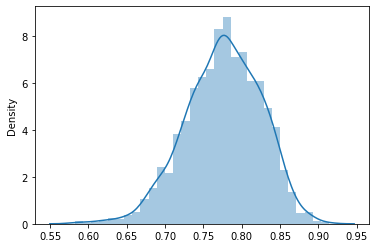

In [17]:
sns.distplot(theta_arr1)
print(np.quantile(theta_arr1,q=0.05), np.quantile(theta_arr1,q=0.95))

In [456]:
np.std(theta_arr1)

0.04948521899508149

In [21]:
%time C2.canonical_calibrate(u,v)

Optimization terminated successfully.
         Current function value: -0.384937
         Iterations: 102
         Function evaluations: 221
CPU times: user 3.16 s, sys: 15.2 ms, total: 3.17 s
Wall time: 3.18 s


array([0.76284551, 3.16165841])

In [57]:
g = np.array([[C1.tau() - stats.kendalltau(u,v)[0]],
              [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
              [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
              [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)]])
np.linalg.inv(g.dot(g.T))

array([[-1.19511378e+18,  5.38535659e+17, -9.20313035e+16,
        -6.01985322e+16],
       [ 0.00000000e+00,  7.20575940e+16, -7.72298081e+16,
        -2.88230376e+17],
       [-0.00000000e+00, -7.20575940e+16,  2.48640386e+16,
        -0.00000000e+00],
       [-5.76460752e+17, -0.00000000e+00, -5.42144897e+16,
        -5.76460752e+17]])

In [75]:
def loss(rho):
    C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
    
    def GMM_loss(W):
        g = np.array([[C1.tau() - stats.kendalltau(u,v)[0]],
                      [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                      [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                      [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                      [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
        W = np.linalg.inv(g.dot(g.T))
        return g.T.dot(W).dot(g), W
    
    
    return


In [92]:
def GMM_loss(C1, W):
    g = np.array([[C1.tau() - stats.kendalltau(u,v)[0]],
                  [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                  [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                  [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                  [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
    W = np.linalg.inv(g.dot(g.T))
    return g.T.dot(W).dot(g), W

In [106]:
x0 = Gaussian({"rho":rho}, stats.norm, stats.norm).canonical_calibrate(u,v)
rho = x0
C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
# GMM_loss(C1, W)
g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])[0]],
              [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
              [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
              [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
              [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
W = np.linalg.inv(g.dot(g.T))

Optimization terminated successfully.
         Current function value: -0.357310
         Iterations: 30
         Function evaluations: 64


LinAlgError: Singular matrix

In [110]:
np.linalg.svd(g.dot(g.T))

(array([[-8.12738507e-02, -9.93164261e-01, -7.55879027e-02,
         -3.56087580e-02,  6.14788827e-03],
        [-3.20018090e-01,  1.04557663e-01, -9.00390026e-01,
         -2.75534470e-01, -5.88855354e-03],
        [-9.27433154e-01,  5.14347485e-02,  3.60967131e-01,
         -8.30107873e-02,  5.84391967e-03],
        [ 1.68496299e-01,  6.29676974e-04,  2.24592303e-01,
         -9.23820079e-01, -2.60237122e-01],
        [ 4.95956242e-02,  6.82020979e-03,  5.33413377e-02,
         -2.49956882e-01,  9.65489522e-01]]),
 array([3.77127141e-01, 2.06924972e-17, 3.25004607e-18, 4.20211976e-19,
        1.04174399e-19]),
 array([[-0.08127385, -0.32001809, -0.92743315,  0.1684963 ,  0.04959562],
        [ 0.15862083,  0.91930123, -0.34592496, -0.09276133,  0.0381568 ],
        [ 0.96260873, -0.19935545, -0.03735398, -0.14929136,  0.09979278],
        [ 0.1705771 ,  0.11256319,  0.126044  ,  0.9678743 ,  0.07460053],
        [ 0.11190117,  0.00778517, -0.05404864,  0.0627357 , -0.99023255]]))

In [168]:
W = scipy.linalg.pinvh(g.dot(g.T))

array([[ 0.25864921,  0.1579218 , -0.09128647,  0.39358033,  0.38003059],
       [ 0.1579218 ,  0.0964213 , -0.0557362 ,  0.24030583,  0.23203285],
       [-0.09128647, -0.0557362 ,  0.03221823, -0.13890845, -0.13412626],
       [ 0.39358033,  0.24030583, -0.13890845,  0.59890178,  0.57828347],
       [ 0.38003059,  0.23203285, -0.13412626,  0.57828347,  0.55837497]])

In [439]:
W = [np.identity(5)]

def loss(rho, W):
    C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
    g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])],
                      [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                      [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                      [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                      [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
    return g.T.dot(W).dot(g)[0][0]


for i in range(5):
    fn = lambda rho: loss(rho, W=(-1*(i%2!=0)+1)*W[i])
    result = scipy.optimize.fmin(fn, x0=0.7)
    C1 = Gaussian({'rho':result}, stats.norm, stats.norm)
    g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])[0]],
                      [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                      [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                      [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                      [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
    W1 = np.linalg.pinv(g.dot(g.T))
    W.append(W1)

Optimization terminated successfully.
         Current function value: 0.276375
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 29


ValueError: the input matrix must be positive semidefinite

In [448]:
fn(0.9999)

0.01939716095991614

In [417]:
W = np.linalg.inv(g.dot(g.T))
g.T.dot(W).dot(g)

array([[0.11381921]])

In [395]:
i

1

-0.99

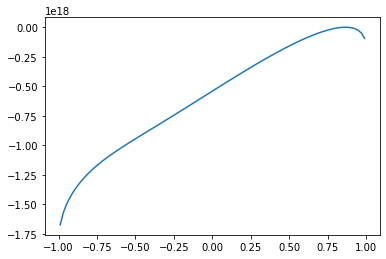

In [381]:
rho_arr = np.linspace(-0.99,0.99,100)
fn = lambda rho: loss(rho=rho, W=W1)
loss_arr = []
# result = scipy.optimize.fmin(fn, x0=result)
for rho in rho_arr:
    loss_arr.append(loss(rho, W=W1))
plt.plot(rho_arr, loss_arr)
rho_arr[np.argmin(loss_arr)]

In [299]:
C1 = Gaussian({'rho':rho_arr[np.argmin(loss_arr)]}, stats.norm, stats.norm)
g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])],
                  [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                  [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                  [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                  [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
W2 = g.dot(g.T)

In [303]:
-1*W2

array([[-0.00641433,  0.00527034,  0.03400078, -0.01875652, -0.01405294],
       [ 0.00527034, -0.00433038, -0.02793678,  0.01541131,  0.01154662],
       [ 0.03400078, -0.02793678, -0.18022962,  0.0994236 ,  0.07449114],
       [-0.01875652,  0.01541131,  0.0994236 , -0.05484699, -0.04109301],
       [-0.01405294,  0.01154662,  0.07449114, -0.04109301, -0.03078811]])

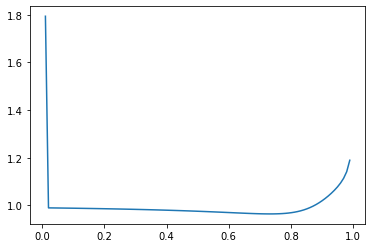

In [161]:
result = []
rho_arr = np.linspace(0.01,.99,100)
W = [np.identity(5)]
for i, rho in enumerate(rho_arr):
    def loss(rho, W):
        C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
        g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])],
                  [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
                  [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
                  [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
                  [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
        W1 = scipy.linalg.pinvh(g.dot(g.T))
        return g.T.dot(W).dot(g)[0][0], W1
    fn = lambda rho: loss(rho, W=W[i])[0]
    scipy.optimize.fmin(fn, x0=0.7)    
    W.append(scipy.linalg.pinvh(g.dot(g.T)))


In [183]:
from functools import partial

In [208]:
W = [np.identity(5)]

def loss(rho, W):
    C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
    g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])],
              [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
              [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
              [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
              [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
#     W1 = scipy.linalg.pinvh(g.dot(g.T))
    return g.T.dot(W).dot(g)[0][0]
# fn = lambda rho: loss(rho, W=W[0])[0]
fn = partial(loss, W=W)
opt = lambda rho: fn(rho)[0]
scipy.optimize.fmin(opt, x0=0.7) 
# opt(0.1)

Optimization terminated successfully.
         Current function value: 0.276375
         Iterations: 13
         Function evaluations: 26


0.28878399632591156

In [244]:
def loss(rho, W):
    C1 = Gaussian({'rho':rho}, stats.norm, stats.norm)
    g = np.array([[(C1.tau() - stats.kendalltau(u,v)[0])],
              [C1._lambda(0.1) - empirical_lambda(u,v, 0.1)], 
              [C1._lambda(0.05) - empirical_lambda(u,v, 0.05)],
              [C1._lambda(0.90) - empirical_lambda(u,v, 0.90)], 
              [C1._lambda(0.95) - empirical_lambda(u,v, 0.95)]])
    W1 = scipy.linalg.pinvh(g.dot(W).dot(g.T))
    return g.T.dot(W).dot(g)[0][0], W1

In [245]:
opt = lambda rho: loss(rho, W1)[0]
scipy.optimize.fmin(opt, x0=0.5)

ValueError: shapes (5,1) and (5,5) not aligned: 1 (dim 1) != 5 (dim 0)

In [246]:
opt(0.1)

ValueError: shapes (5,1) and (5,5) not aligned: 1 (dim 1) != 5 (dim 0)

In [520]:
from scipy.special import beta, zeta, exp1
def Fisher_information(rho): # Gaussian
    return (1+rho**2)/(1-rho**2)**2

def Fisher_information(rho, nu): # t-copula
    # I_rho
    part1 = (1+rho**2)/(1-rho**2)**2 
    part2 = (nu**2+2*nu)*(rho**2)/(4*(1-rho**2)**2)*beta(3, nu/2)
    part3 = (nu**2+2*nu)*(2-3*rho**2+rho**6)/(16*(1-rho**2)**4)*beta(3, nu/2)
    part4 = (nu**2+2*nu)*(1+rho**2)/(2*(1-rho**2)**2)*beta(2, nu/2)
    I_rho = part1 + part2 + part3 + part4
    
    # I_nu
    I_nu = 1/nu*beta(2, nu/2) - (nu+2)/(4*nu)*beta(3, nu/2)
    
    # I_rhonu
    I_rhonu = -rho/(2*(1-rho**2))*(beta(2, nu/2)-(nu+2)/2*beta(3,nu/2))
    return I_rho, I_nu, I_rhonu

def Fisher_information(theta): # Clayton
    # rho(theta)
    part1  = 1/((3*theta-2)*(2*theta-1))
    
    part2a = theta/(2*(3*theta-2)*(2*theta-1)*(theta-1))
    part2b = zeta(2,1/(2*(theta-1)))-zeta(2,theta/(2*(theta-1)))     # Trigamma is a special case of Huritz zeta function
    part2  = part2a*part2b   
    
    part3a = 1/(2*(3*theta-2)*(2*theta-1)*(theta-1))
    part3b = zeta(2,theta/(2*(theta-1)))-zeta(2,(2*theta-1)/(2*(theta-1)))     # Trigamma is a special case of Huritz zeta function
    part3  = part3a*part3b
    rho = part1+part2+part3
    
    I = 1/theta**2+2/(theta*(theta-1)*(2*theta-1)) + 4*theta/(3*theta-2) - 2*(2*theta-1)/(theta-1)*rho
    return I
    

In [523]:
def Fisher_information(theta): # Gumbel
    K = 5/6-(np.pi)**2/18
    E1 = exp1(theta-1)
    part1 = theta**2*(-2/3+(np.pi**2)/9)
    part2 = -theta + 2*K/theta
    part3 = (theta**3 + theta**2 +(K-1)*theta - 2*K+K/theta)*E1*np.exp(theta-1)    
    I = 1/theta**4*(part1+part2+part3)
    return I

In [527]:
1/np.sqrt(Fisher_information(10))/np.sqrt(100)

0.8355849078453268

In [515]:
# Trigamma is a special case of Huritz zeta function
zeta(2,100)

0.010050166663333573

In [ ]:
# https://mediatum.ub.tum.de/doc/1119201/1119201.pdf Important for Fisher Imformation